## Compare all tflite 

All tflite models are compared against each other.

As can be seen, the quantized model often loses accuracy.

ana0910s1 - models are not trained on the relabeled data. So the accuracy is much less against the other models.


In [1]:
########### Basic Parameters for Running: ################################
    
input_shape = (32,20,3)

##########################################################################


 
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import math
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [2]:
"""calculate flops of tflite model. only conv and depthwise_conv considered
based on https://github.com/lisosia/tflite-flops/blob/main/tflite_flops/calc.py
"""

import sys
import tflite

def calc_flops(path):
    with open(path, 'rb') as f:
        buf = f.read()
        model = tflite.Model.GetRootAsModel(buf, 0)

    graph = model.Subgraphs(0)

    # help(tflite.BuiltinOperator)
    # ABS = 101
    # CONV_2D = 3
    # CUMSUM = 128

    total_flops = 0.0
    for i in range(graph.OperatorsLength()):
        op = graph.Operators(i)
        op_code = model.OperatorCodes(op.OpcodeIndex())
        op_code_builtin = op_code.BuiltinCode()

        op_opt = op.BuiltinOptions()

        flops = 0.0
        if op_code_builtin == tflite.BuiltinOperator.CONV_2D:
            # input shapes: in, weight, bias
            in_shape = graph.Tensors( op.Inputs(0) ).ShapeAsNumpy()
            filter_shape = graph.Tensors( op.Inputs(1) ).ShapeAsNumpy()
            bias_shape = graph.Tensors( op.Inputs(2) ).ShapeAsNumpy()
            # output shape
            out_shape = graph.Tensors( op.Outputs(0) ).ShapeAsNumpy()
            # ops options
            opt = tflite.Conv2DOptions()
            opt.Init(op_opt.Bytes, op_opt.Pos)
            # opt.StrideH()

            # flops. 2x means mul(1)+add(1). 2x not needed if you calculate MACCs
            # refer to https://github.com/AlexeyAB/darknet/src/convolutional_layer.c `l.blopfs =`
            flops = 2 * out_shape[1] * out_shape[2] * filter_shape[0] * filter_shape[1] * filter_shape[2] * filter_shape[3]
    
        elif op_code_builtin == tflite.BuiltinOperator.DEPTHWISE_CONV_2D:
            in_shape = graph.Tensors( op.Inputs(0) ).ShapeAsNumpy()
            filter_shape = graph.Tensors( op.Inputs(1) ).ShapeAsNumpy()
            out_shape = graph.Tensors( op.Outputs(0) ).ShapeAsNumpy()
            # flops
            flops = 2 * out_shape[1] * out_shape[2] * filter_shape[0] * filter_shape[1] * filter_shape[2] * filter_shape[3]
    
        total_flops += flops
    return total_flops

In [3]:
Input_dir='images'

def ziffer_data_files(input_dir):
    imgfiles = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if (file.endswith(".jpg") and not file.startswith("10_") and not file.startswith("N")):
                #print(root + "/" + file)
                imgfiles.append(root + "/" + file)
    return  imgfiles

files = ziffer_data_files(Input_dir)
y_data = np.empty((len(files)))
y_data10 = np.empty((len(files)))
f_data = np.empty((len(files)), dtype="<U250")
x_data = np.empty((len(files),input_shape[0],input_shape[1],input_shape[2]), dtype="float32")
x_data_gray = np.empty((len(files),input_shape[0],input_shape[1], input_shape[2]-2), dtype="uint8")


for i, aktfile in enumerate(files):
    base = os.path.basename(aktfile)

    # get label from filename (1.2_ new or 1_ old),
    if (base[1]=="."):
        target = base[0:3]
    else:
        target = base[0:1]
    category = float(target)
    
    test_image = Image.open(aktfile).resize((input_shape[1],input_shape[0]), Image.Resampling.NEAREST)
    test_image_gray = Image.open(aktfile).convert("L").resize((input_shape[1],input_shape[0]), Image.Resampling.NEAREST)
    test_image_gray = np.array(test_image_gray, dtype="uint8")
    
    test_image = np.array(test_image, dtype="float32")
    f_data[i] =  aktfile
    x_data[i] = test_image
    x_data_gray[i] = np.expand_dims(test_image_gray, axis=2)

    y_data[i] =  category
    
    y_data10[i] = int((category + 0.4))%10  # for rounding to nearest integer x.0-x.4 -> x ; x.5-x.9 -> x+1

print("Digital data count: ", len(y_data))  

Digital data count:  27253


## functions for evaluation

The functions to evaluate the models.

In [4]:
import numpy as np
import tensorflow as tf

def plot_dataset(images, labels, columns=10, rows=5, figsize=(18, 10)):

    fig = plt.figure(figsize=figsize)
    
    for i in range(1, columns*rows +1):
        if (i>len(labels)):
            break
        fig.add_subplot(rows, columns, i)
        plt.title(labels[i-1])  # set title
        plt.imshow((images[i-1]).astype(np.uint8), aspect='1', extent=[0, 1, 0, 1])
        # yellow lines
        ax=plt.gca()
        ax.get_yaxis().set_visible(False) 
        ax.get_xaxis().set_visible(False) 
        
        plt.tight_layout()
    plt.show()

def plot_divergence(divergationset, title1, nb_classes):
    fig = plt.figure(figsize=(40, 10))
    fig.suptitle(title1, fontsize=32)
    plt.bar(np.arange (0, nb_classes/10, 0.1), divergationset, width=0.09, align='center')
    plt.ylabel('count')
    plt.xlabel('digit class')
    plt.xticks(np.arange(0, nb_classes/10, 0.1))
    plt.show()
    return fig

def evaluate_ziffer_tflite(model_path, x_data, x_data_gray, y_data, y_data10, f_data, title, max_delta = 0.11):
    false_images = []
    false_labels = []
    false_predicted = []

    # we use the tflite model
    print(model_path)
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # ignore models with other shape than 32,32,3
    if ((interpreter.get_input_details()[0]['dtype'] == np.uint8)):
        xd = x_data.astype("uint8")
        yd = y_data10
        print("shape:" + str(interpreter.get_input_details()[0]["shape"]) + " unit8_rgb") 
        
    else: 
        xd = x_data
        yd = y_data
        print("shape:" + str(interpreter.get_input_details()[0]["shape"]) + " rgb")
       
    for x, y, f in zip(xd, yd, f_data):

        interpreter.set_tensor(input_index, np.expand_dims(x, axis=0))
        # Run inference.
        interpreter.invoke()
        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.get_tensor(output_index)
        
        if (len(output[0])==2):
            out_sin = output[0][0]  
            out_cos = output[0][1]
            prediction = ((np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1)*1
        else:
            if (len(output[0])==10):
                output_details = interpreter.get_output_details()
                
                # Handle output quantization if needed
                if output_details[0]['dtype'] in [np.uint8, np.int8]:

                    output_scale, output_zero_point = output_details[0]['quantization']
                    output = (output.astype(np.float32) - output_zero_point) * output_scale
                    
                # Get prediction and confidence
                prediction = np.argmax(output[0])
                confidence = np.max(output[0])
           
                
                #_num = np.argmax(output[0])
                #_num = (np.argmax(output, axis=1).reshape(-1))[0]
                #prediction = _num
            else:
                prediction = (np.argmax(output, axis=1).reshape(-1)/10)[0]

        difference = min(abs(prediction-y), abs(prediction-(10-y)))
        #print(prediction, y, difference)
        if difference>max_delta:
            #print(x)
            false_images.append(x)
            false_labels.append( "Expected: " + str(y) + "\n Predicted: " + str(prediction) + "\n" + str(f)[-28:-5])
            false_predicted.append(difference)

    #print(false_labels)   
    total_flops = "{:.1f}  M FLOPS ".format( calc_flops(model_path) / 1e6)
    accuracy = "{:.2f}%".format((1-len(false_labels)/len(y_data))*100)
    title = f"Model: {os.path.basename(model_path)} ( {total_flops}), Tested images: {len(y_data)}. {len(false_labels)} false predicted. Accuracy is: {accuracy}\nDeviation of false predicted"
    # plot the differences (max difference can only be 5.0)
    plot_divergence(np.bincount(np.array(np.array(false_predicted)*10).astype(int), minlength=51), title, 51)

    # currently only for uint8 input models
    if ((interpreter.get_input_details()[0]['dtype'] == np.uint8)):
        # plot the false predicted images
        plot_dataset(np.array(false_images), false_labels, columns=7, rows=7, figsize=(18,18))


# Evaluate max_delta = 0.1

output/original_haverland_10cls_RGB.tflite
shape:[ 1 32 20  3] unit8_rgb


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


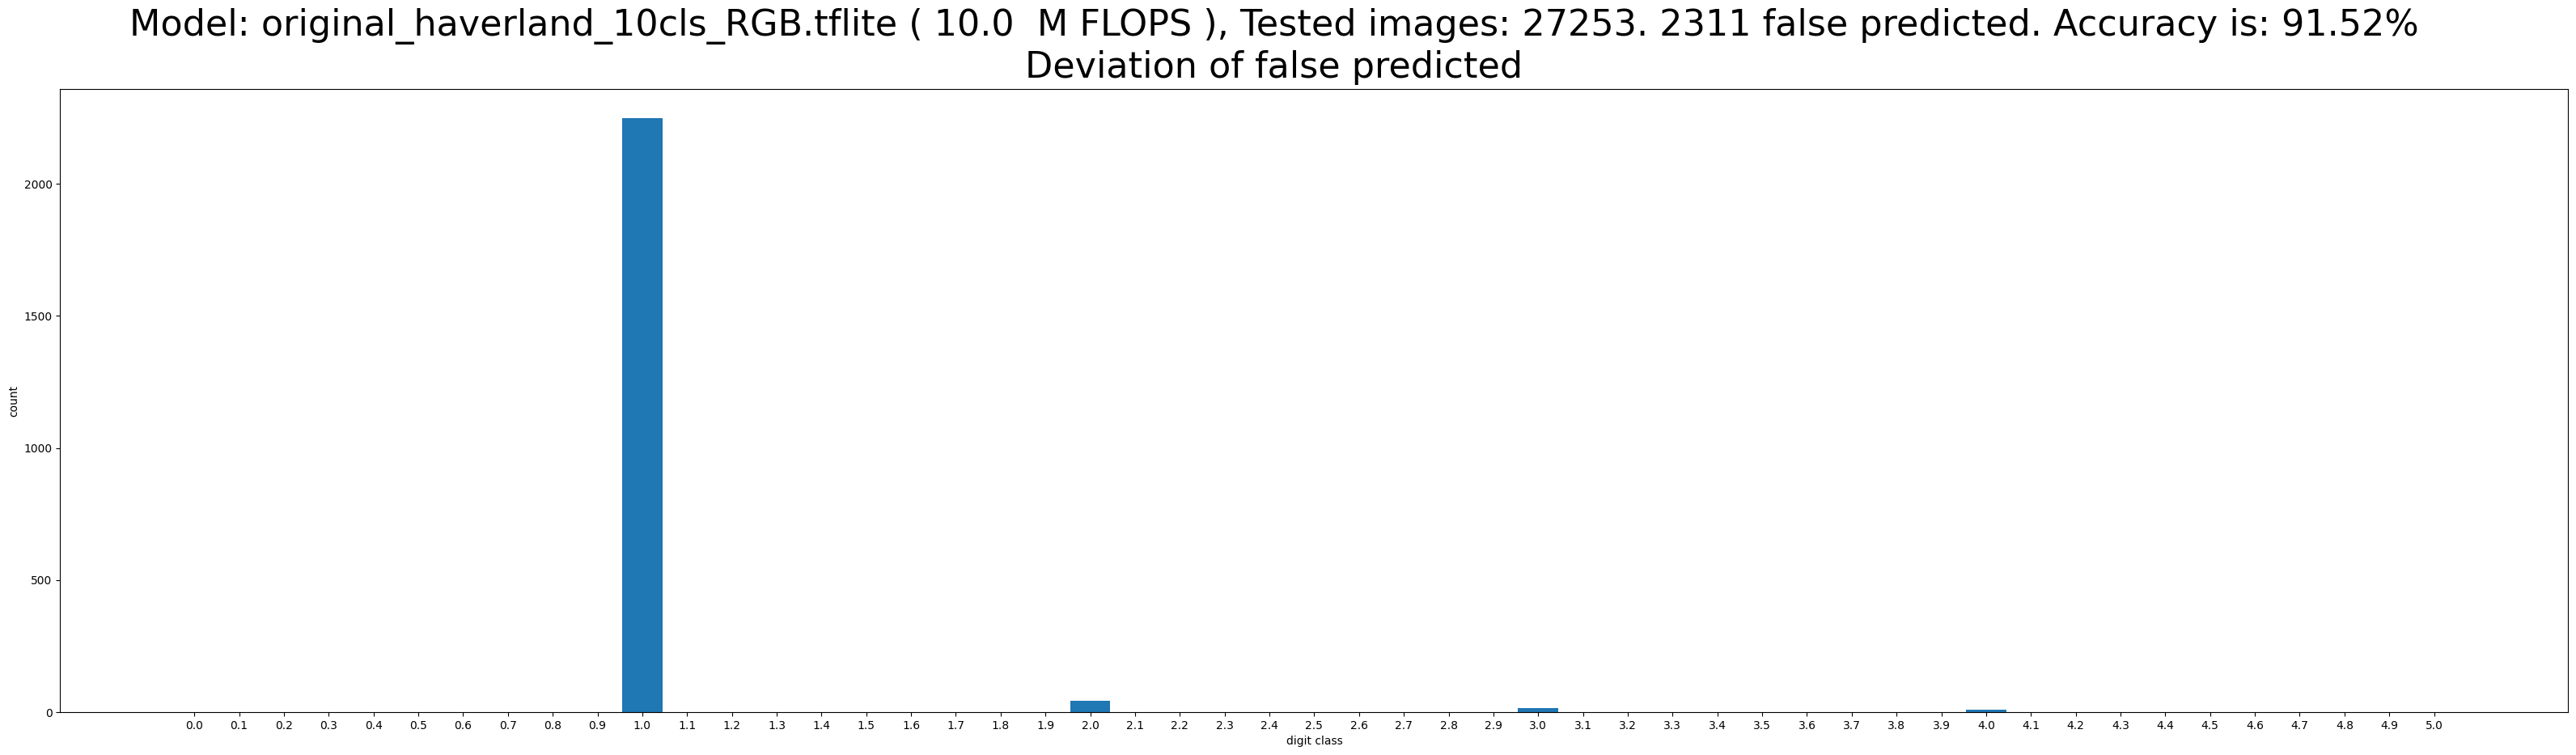

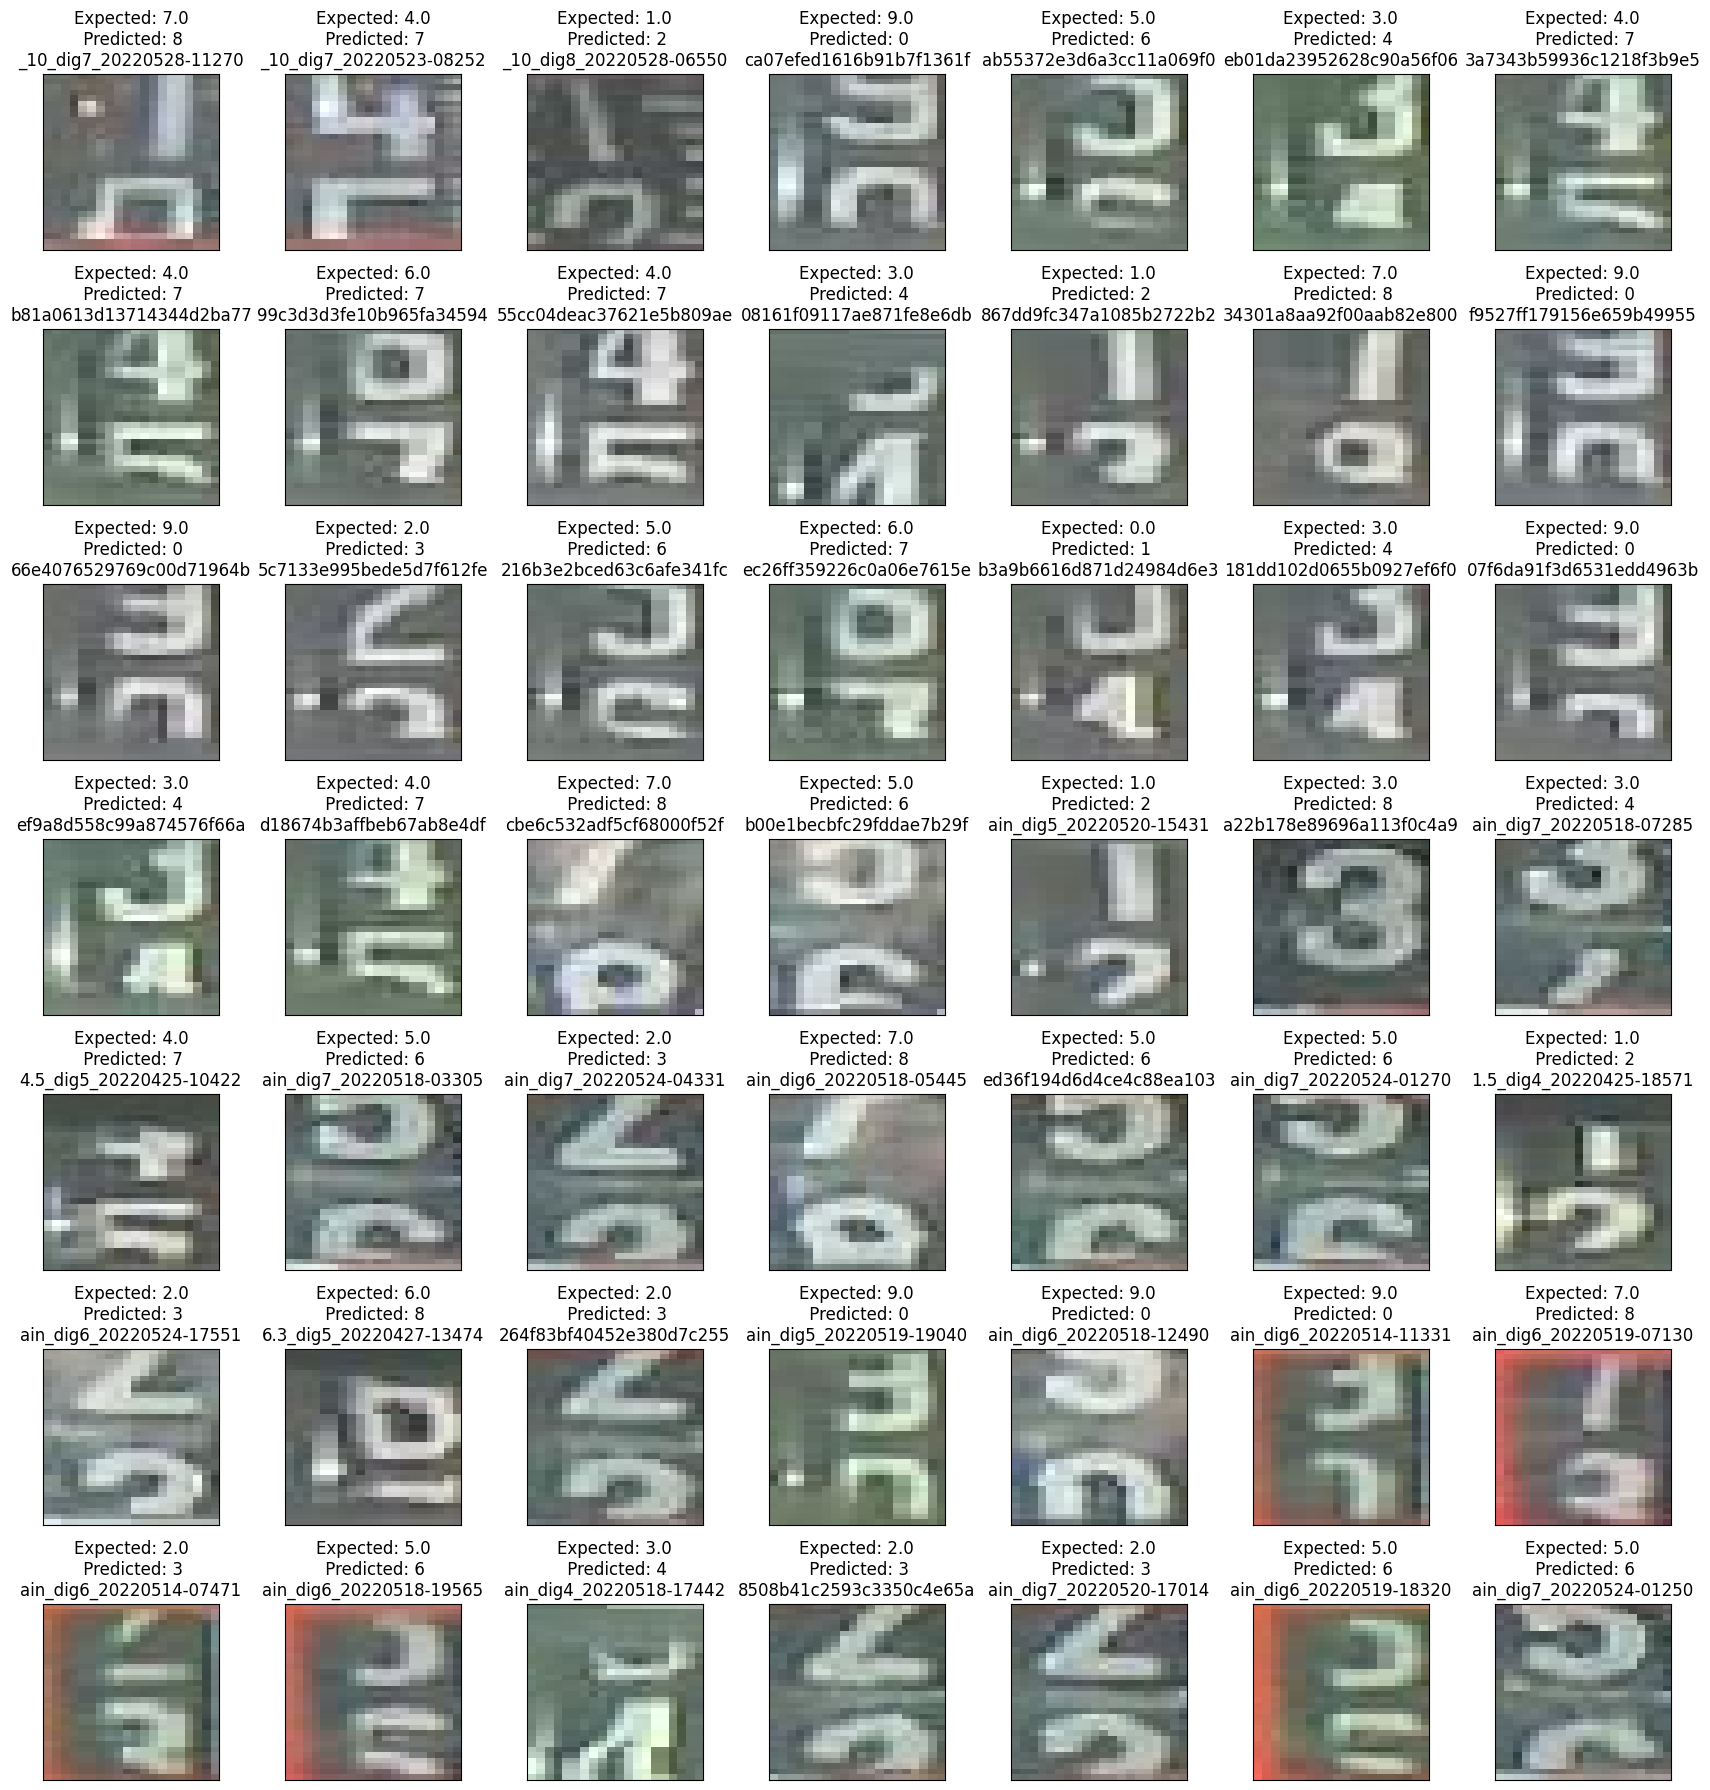

output/digit_recognizer_v4_10cls_RGB.tflite
shape:[ 1 32 20  3] unit8_rgb


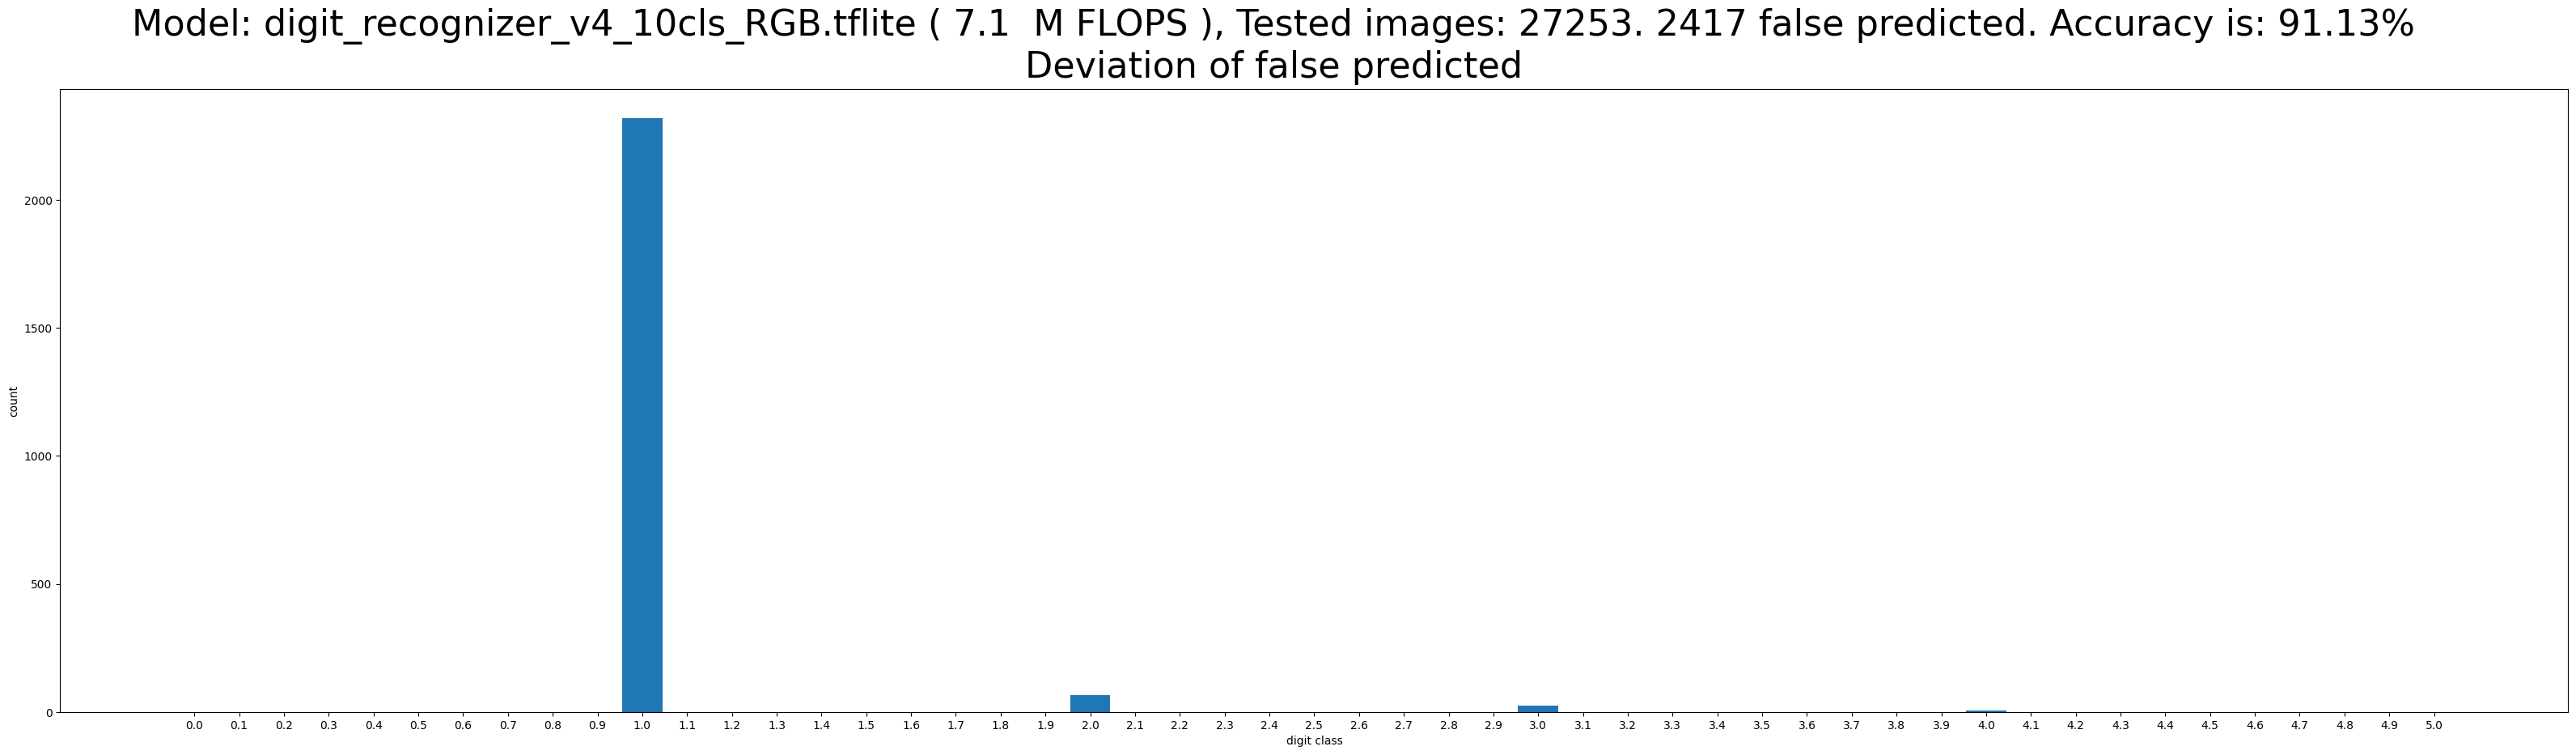

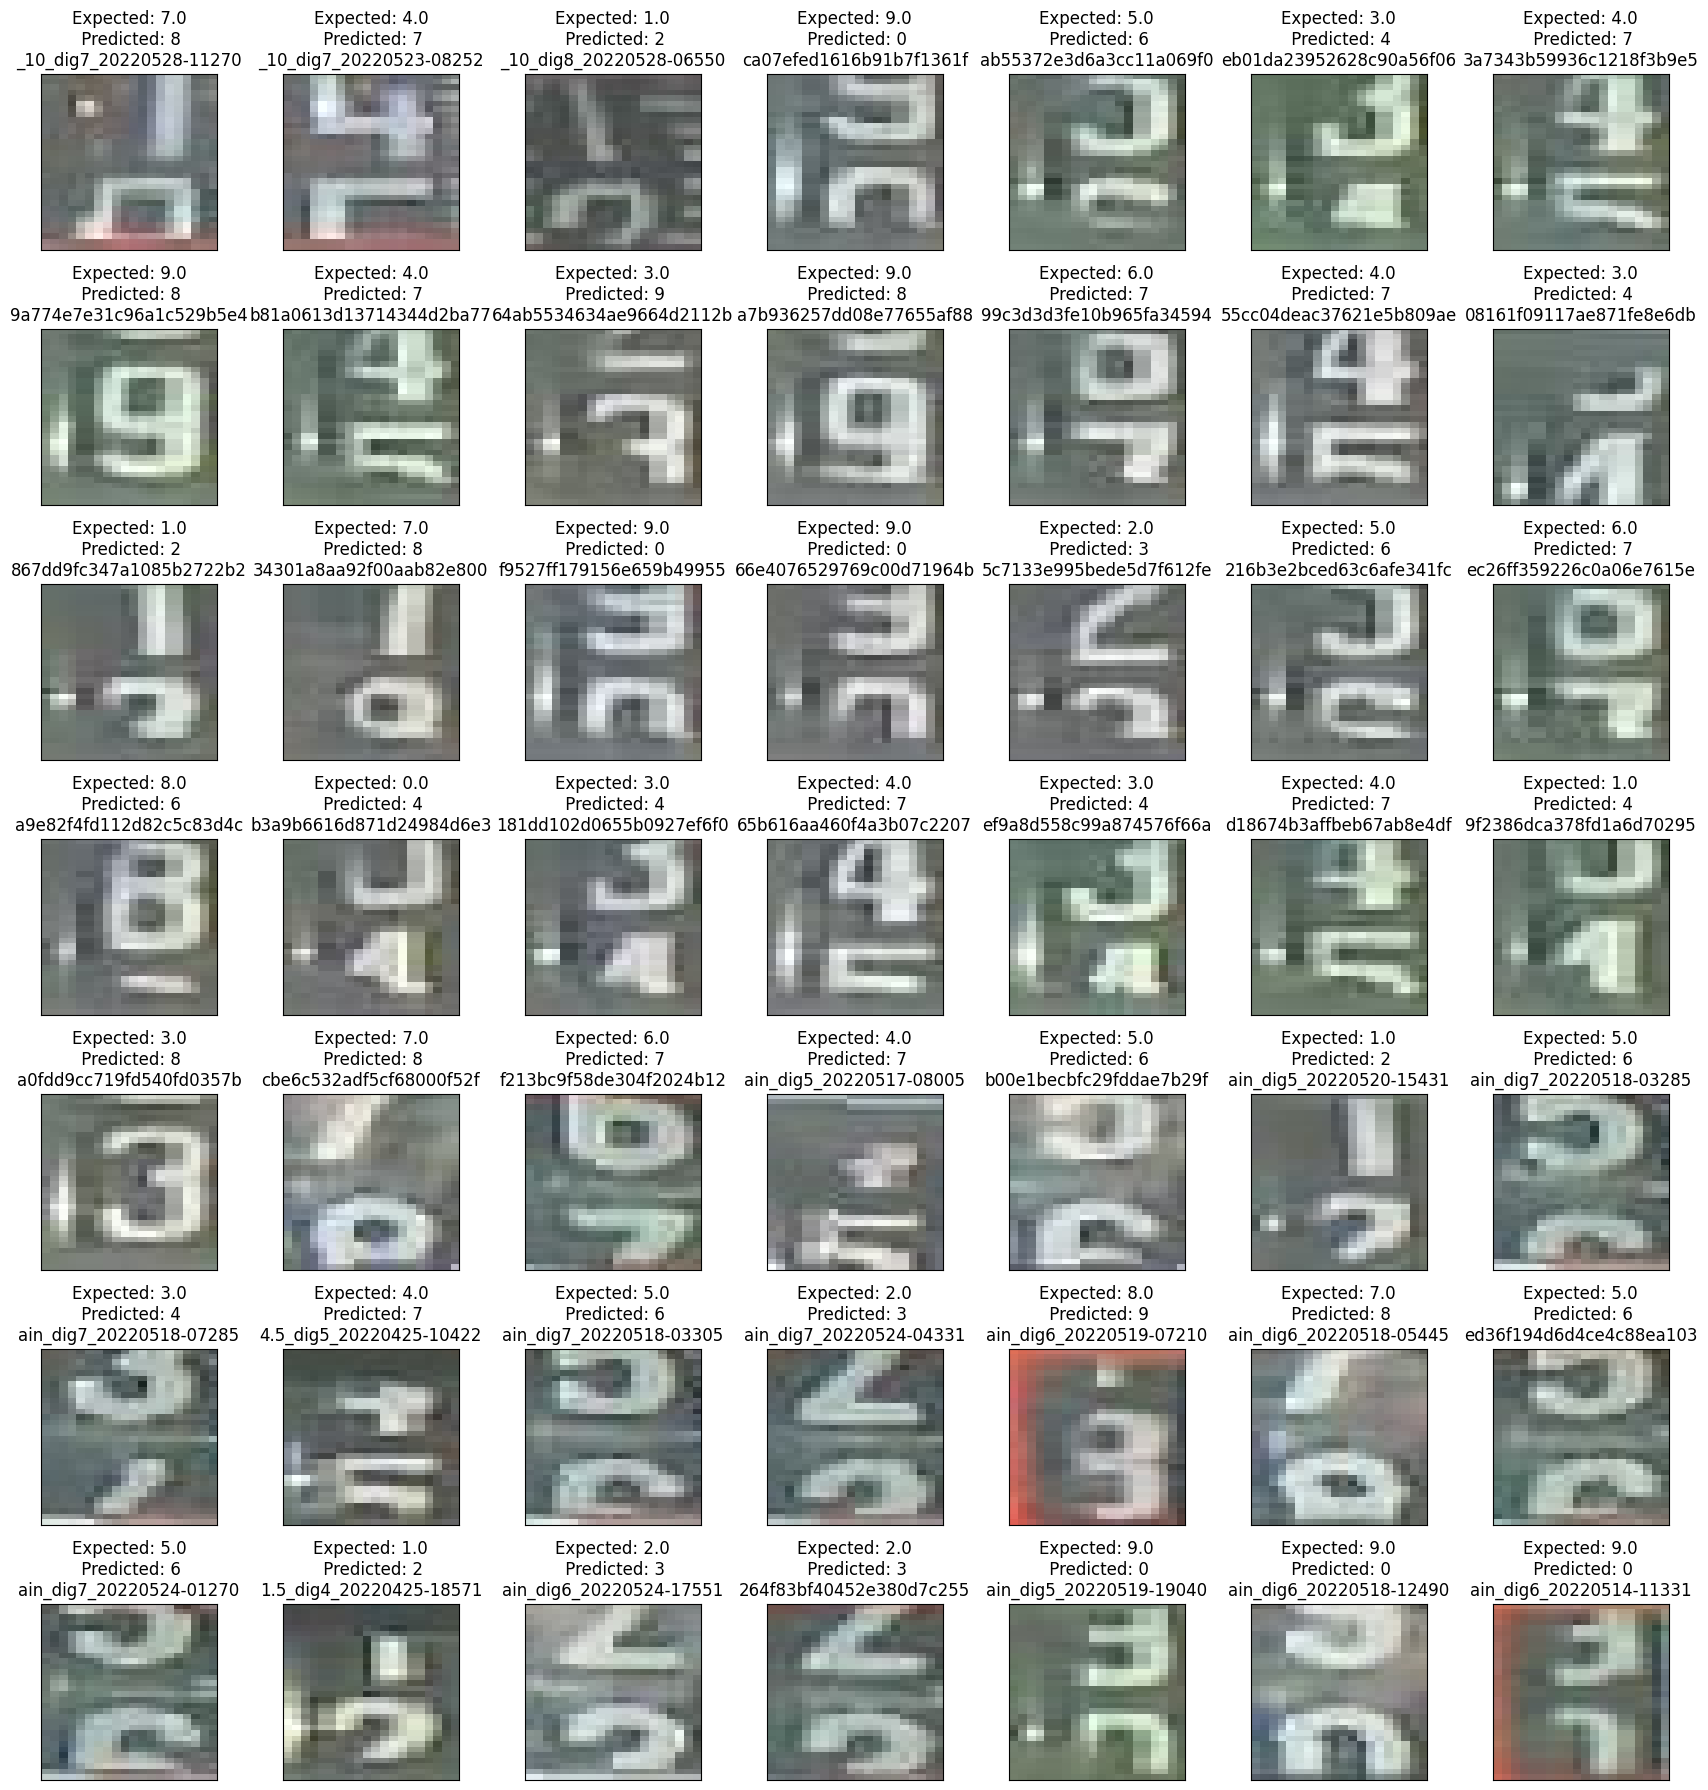

output/dig-class100-s2_20251021-210540_q_neu.tflite
shape:[ 1 32 20  3] rgb


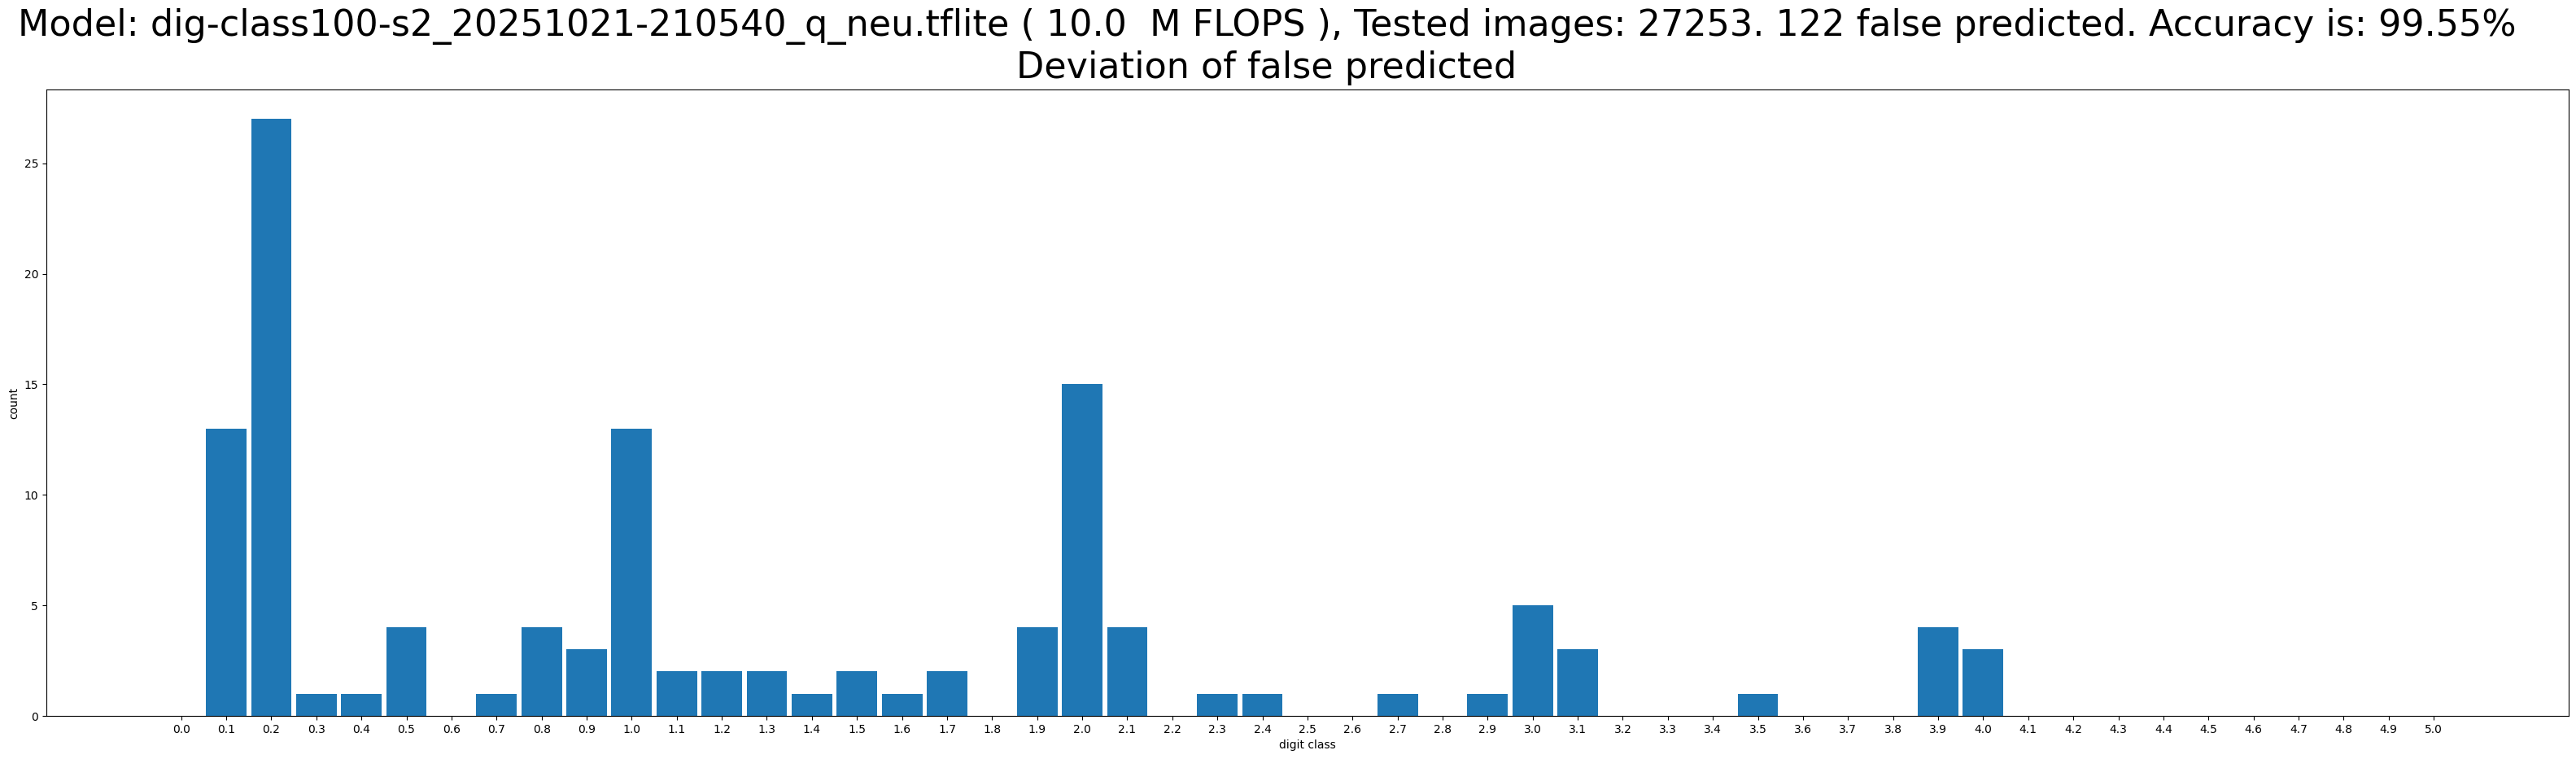

output/dig-class100-s2_20250913-161911_q_neu.tflite
shape:[ 1 32 20  3] rgb


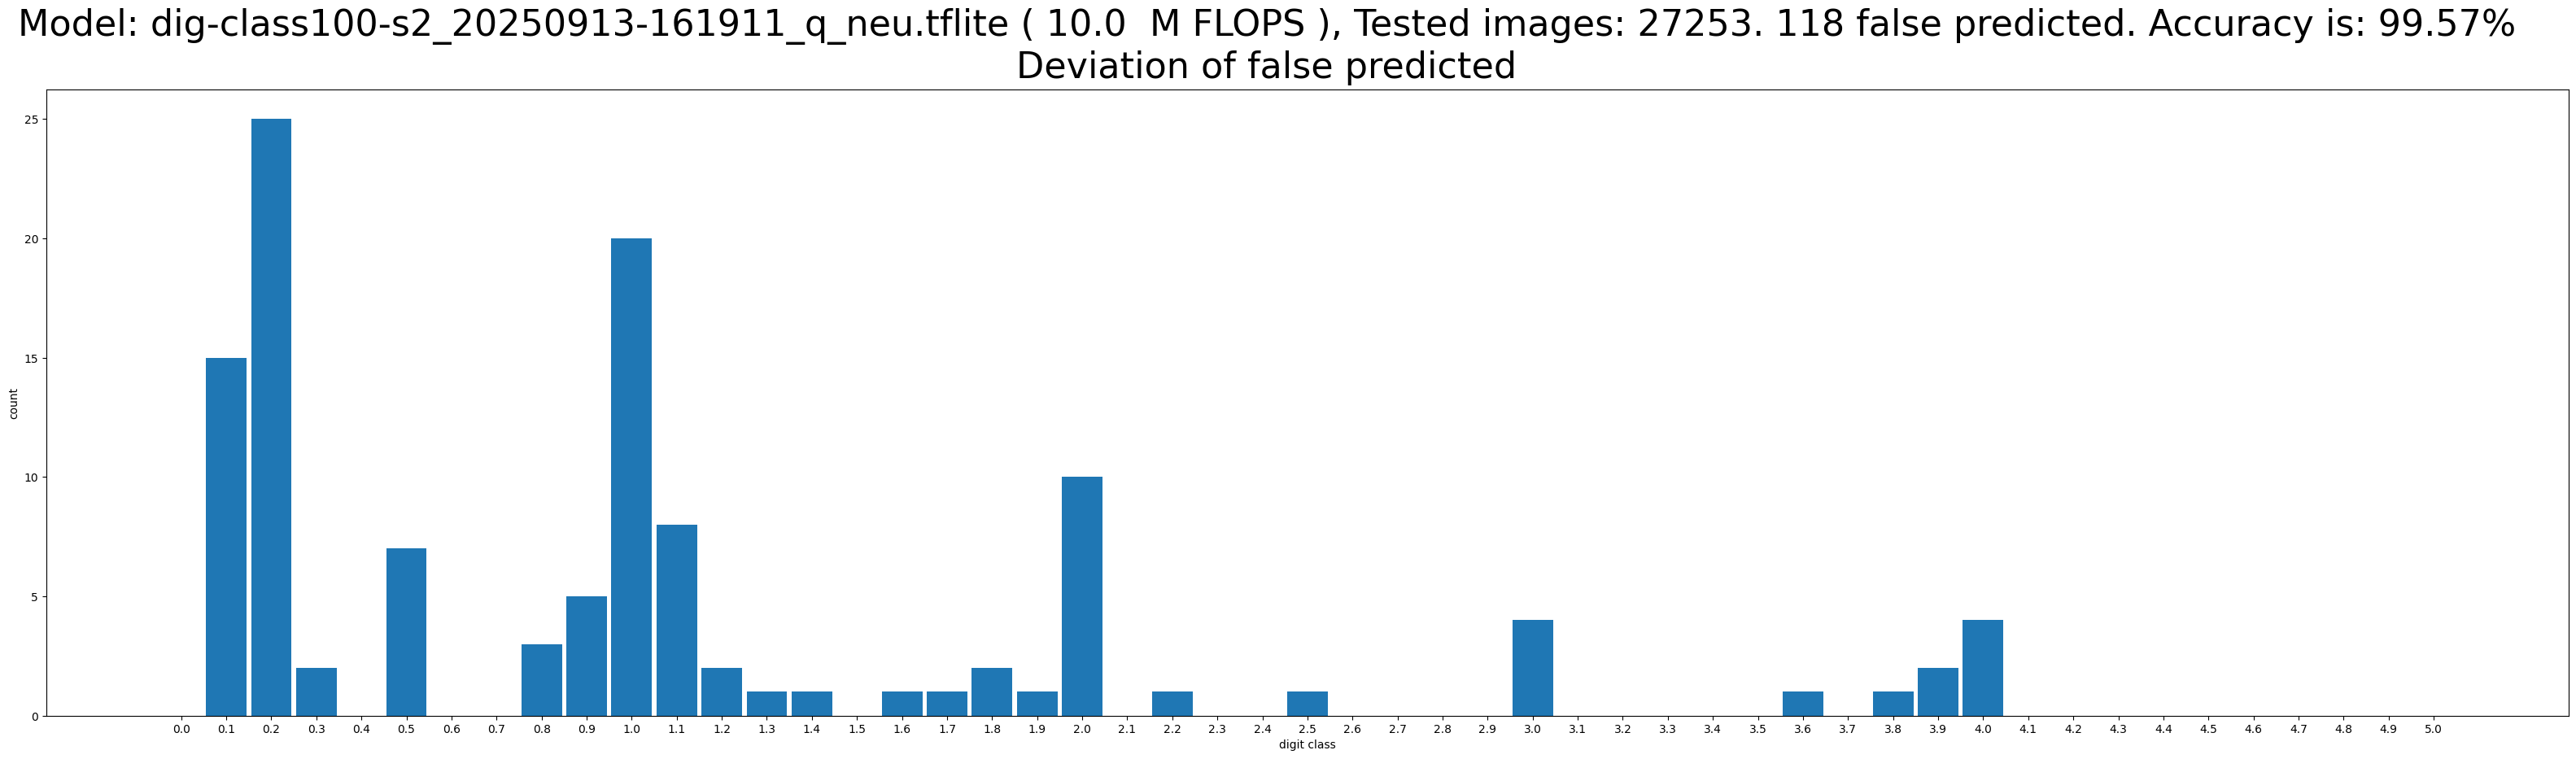

output/dig-class100-s2_20250603-195340_q_neu.tflite
shape:[ 1 32 20  3] rgb


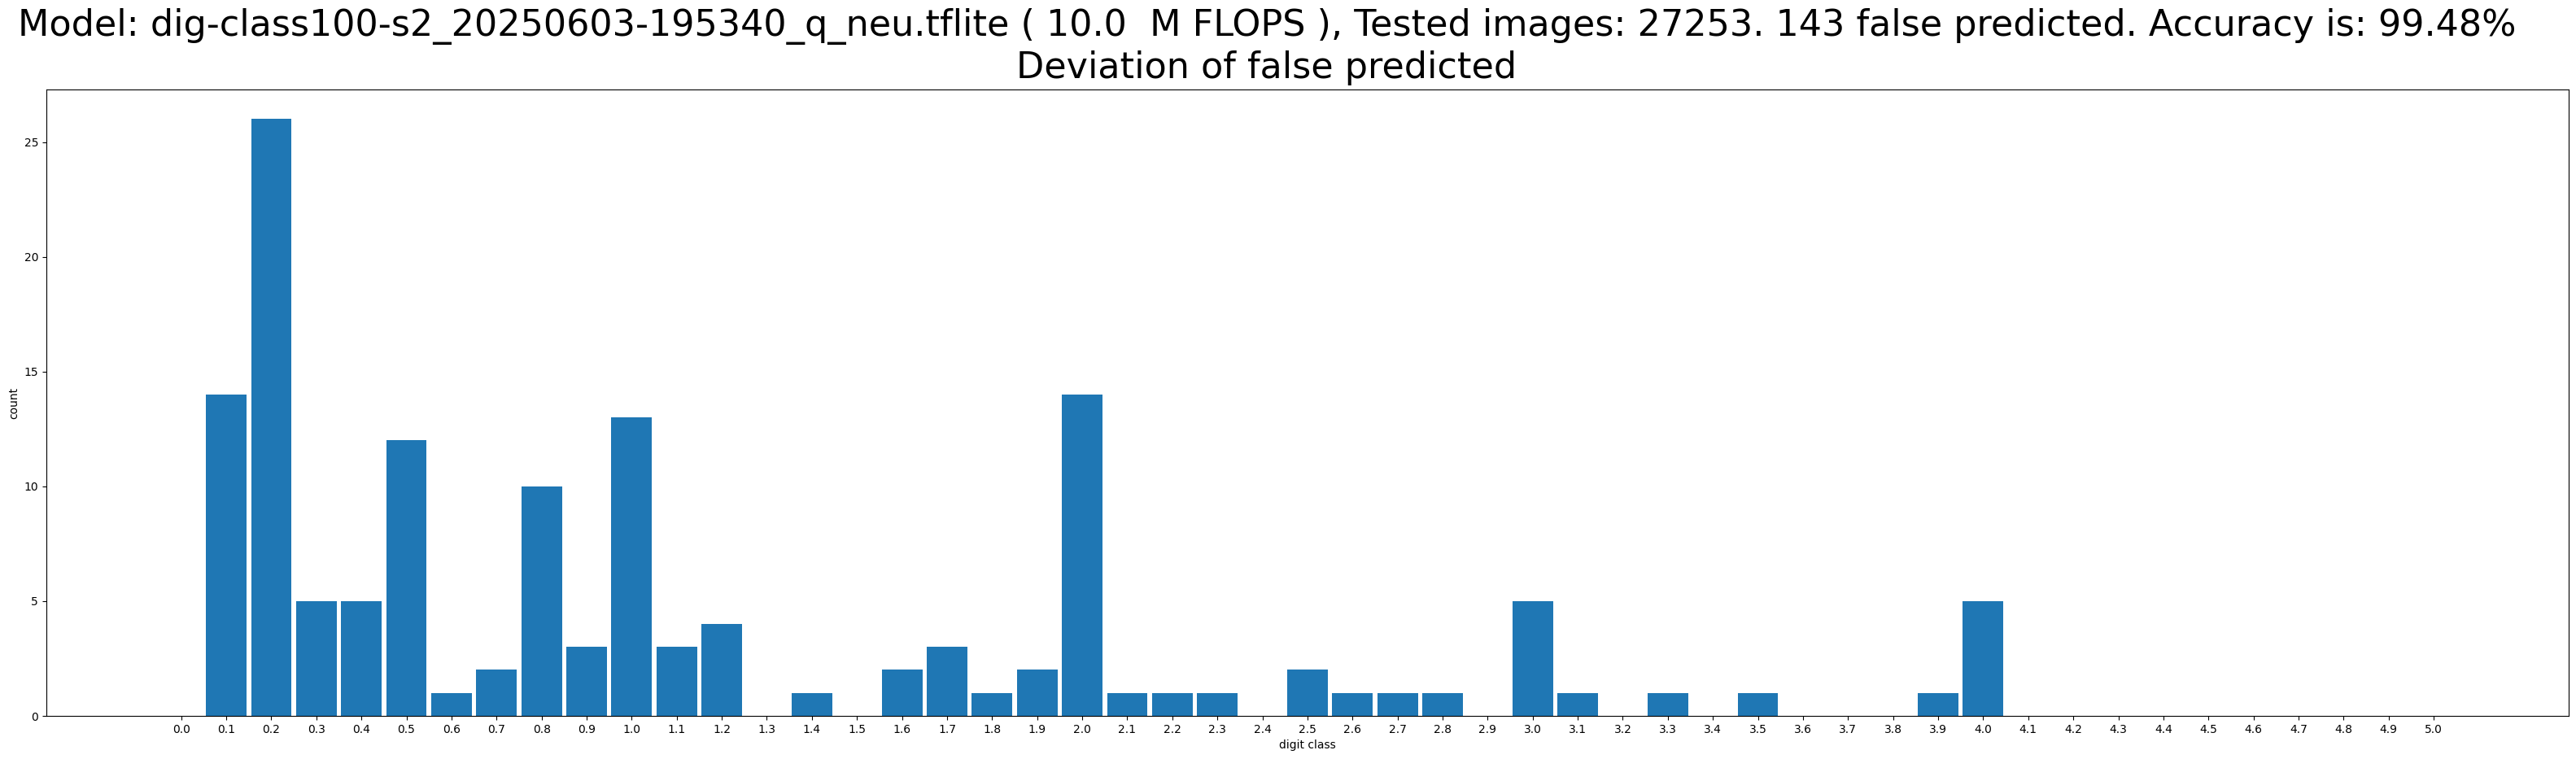

output/dig-class100-0182-s2_q.tflite
shape:[ 1 32 20  3] rgb


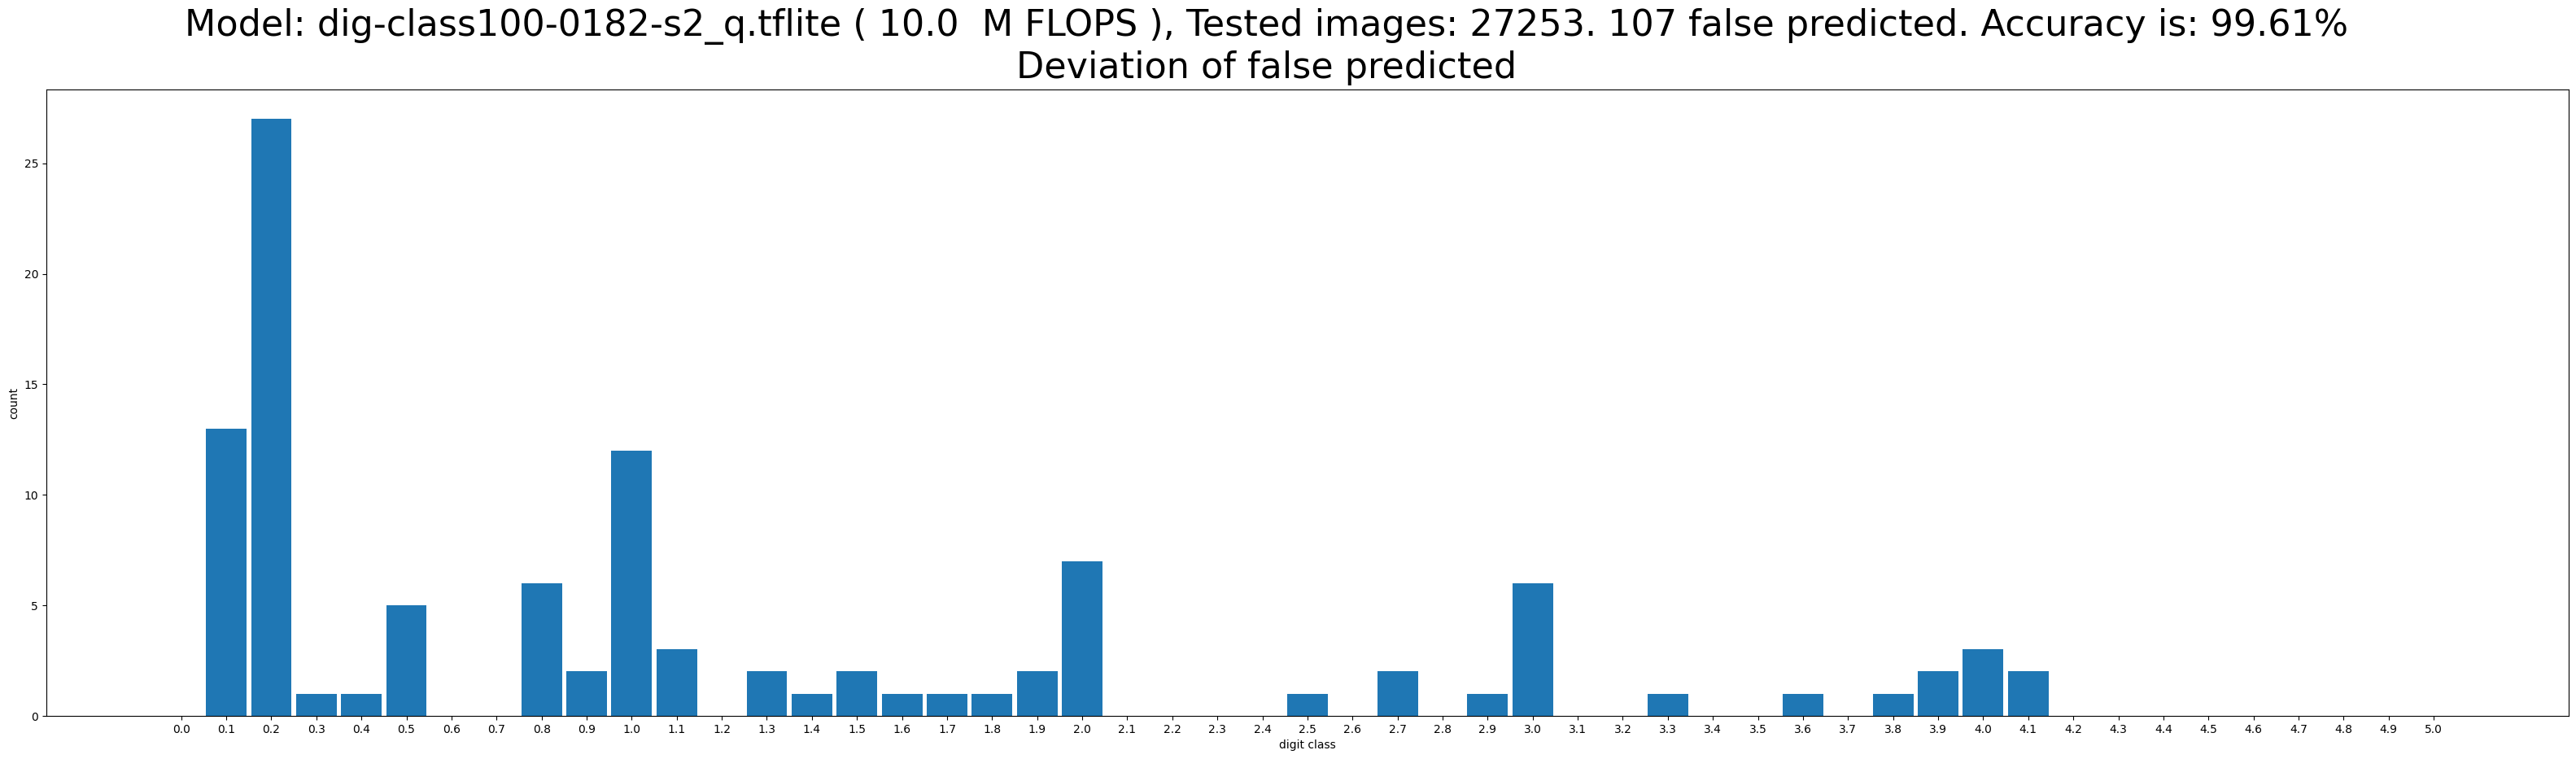

output/dig-class100-0180-s2_q.tflite
shape:[ 1 32 20  3] rgb


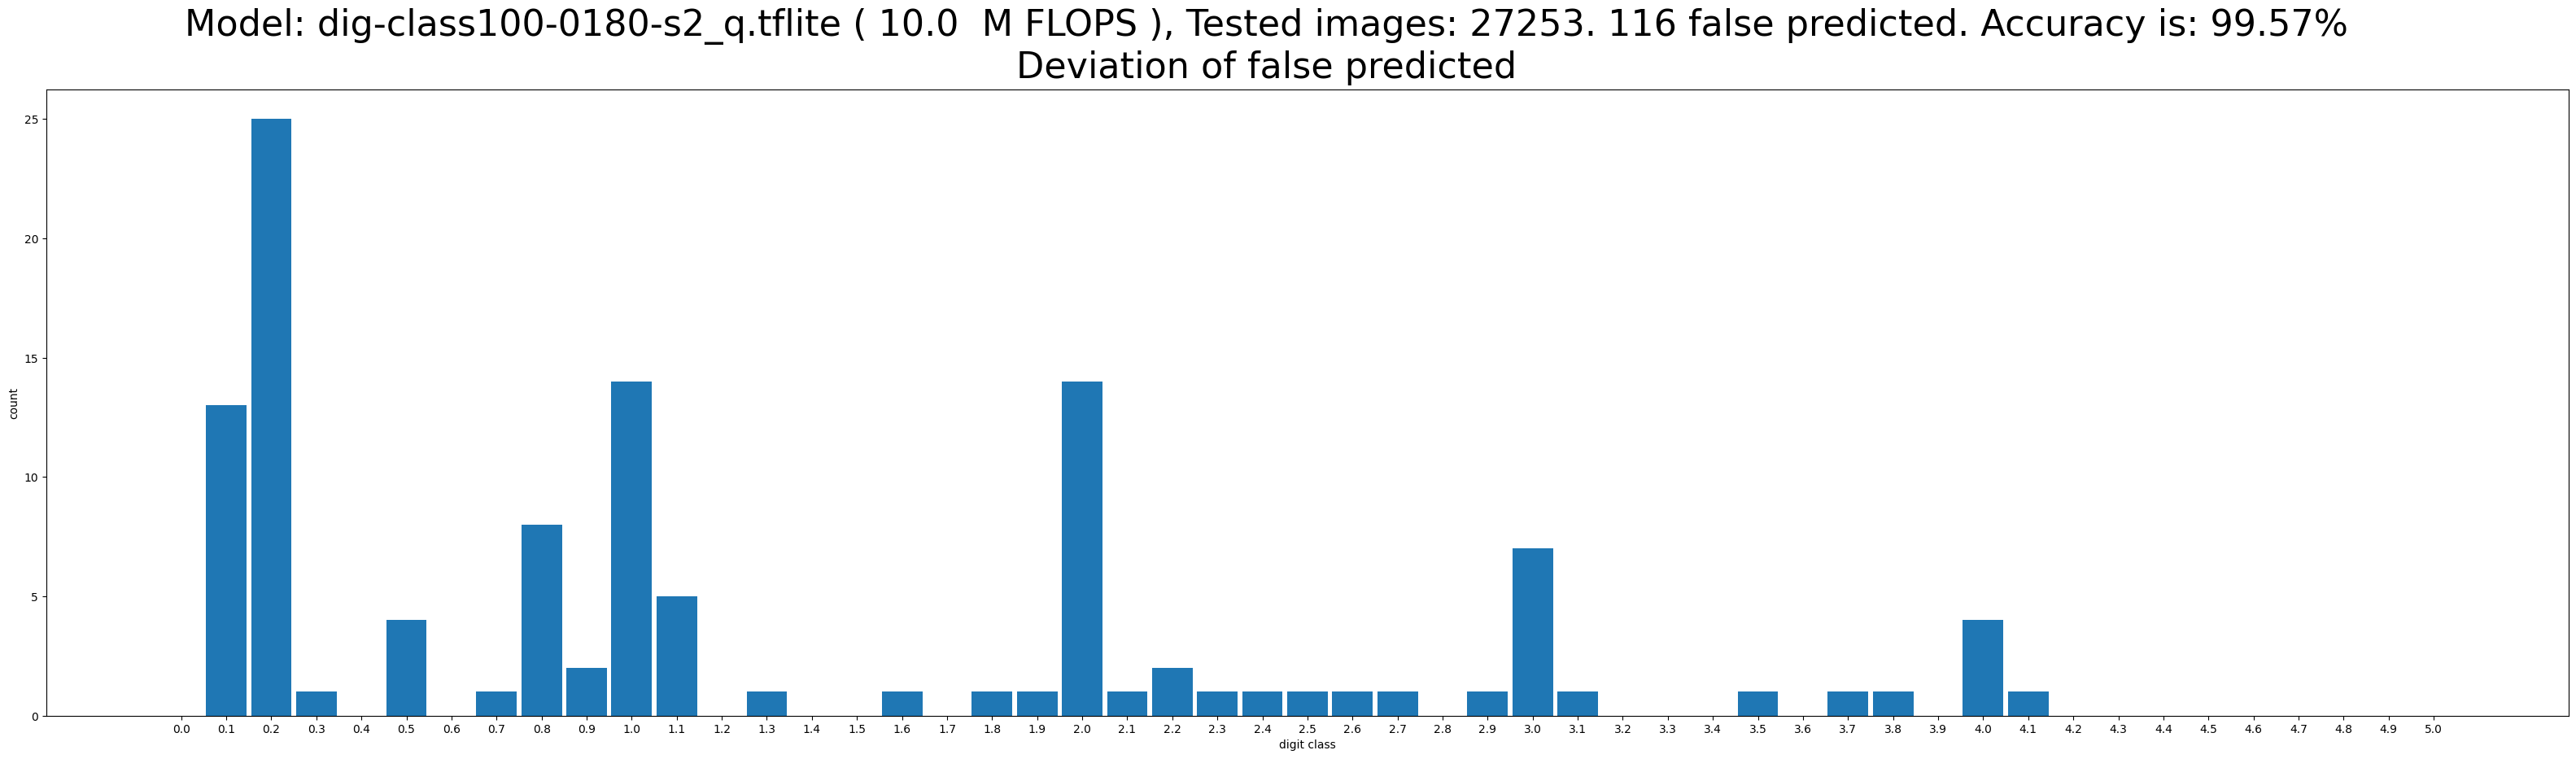

output/dig-class100-0180-s2-q.tflite
shape:[ 1 32 20  3] rgb


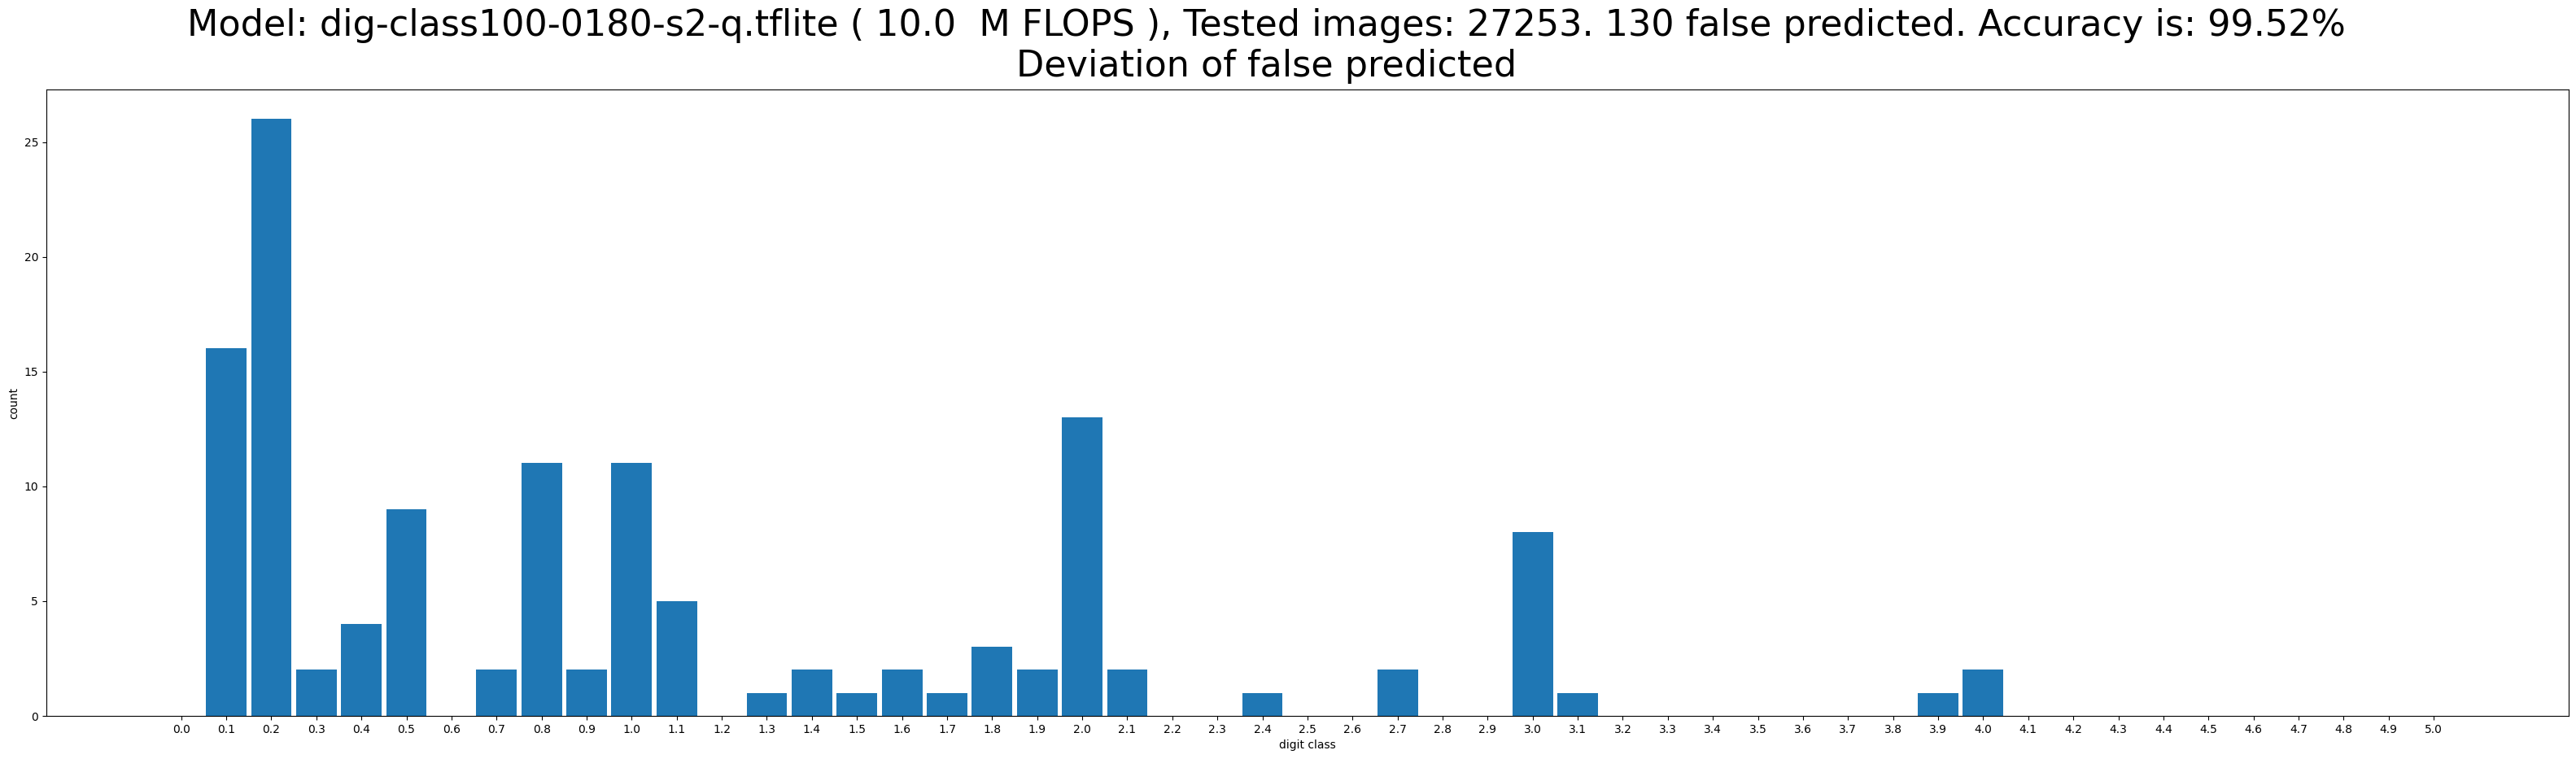

output/dig-class100-0173-s2-q.tflite
shape:[ 1 32 20  3] rgb


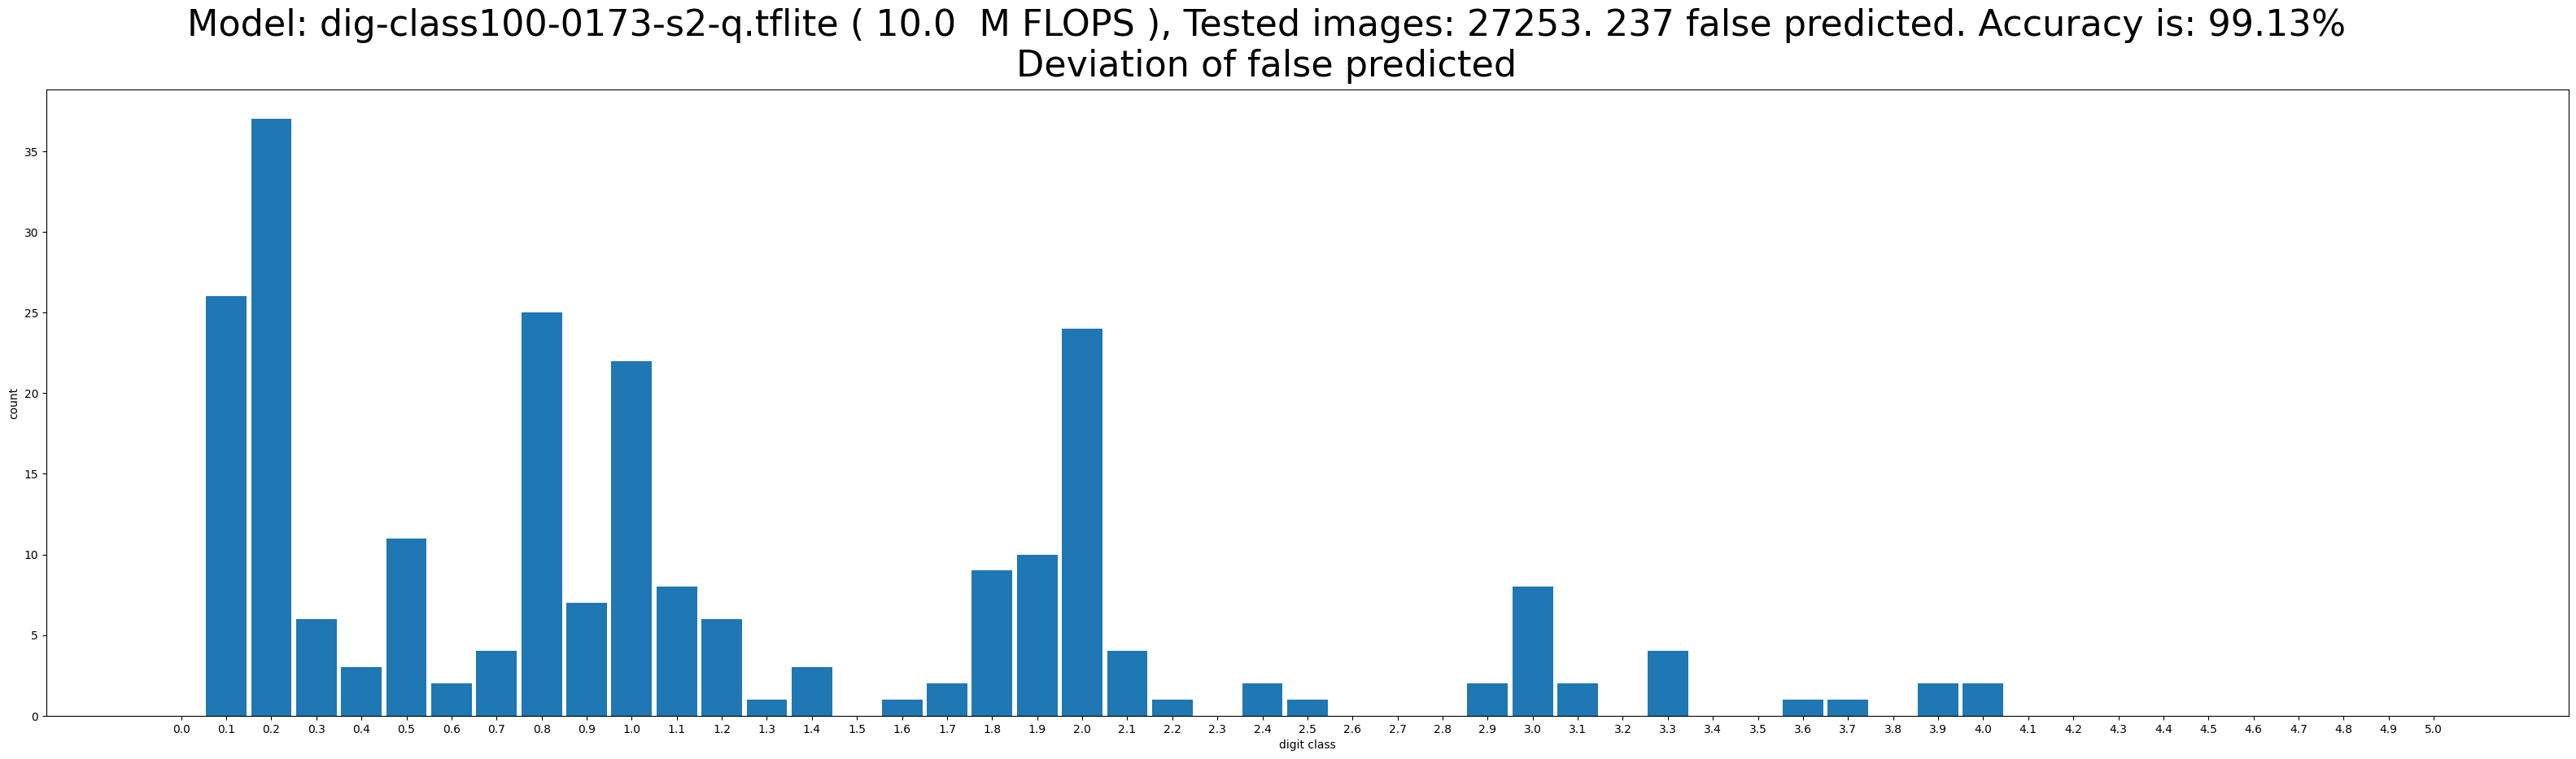

output/dig-class100-0172-s2-q.tflite
shape:[ 1 32 20  3] rgb


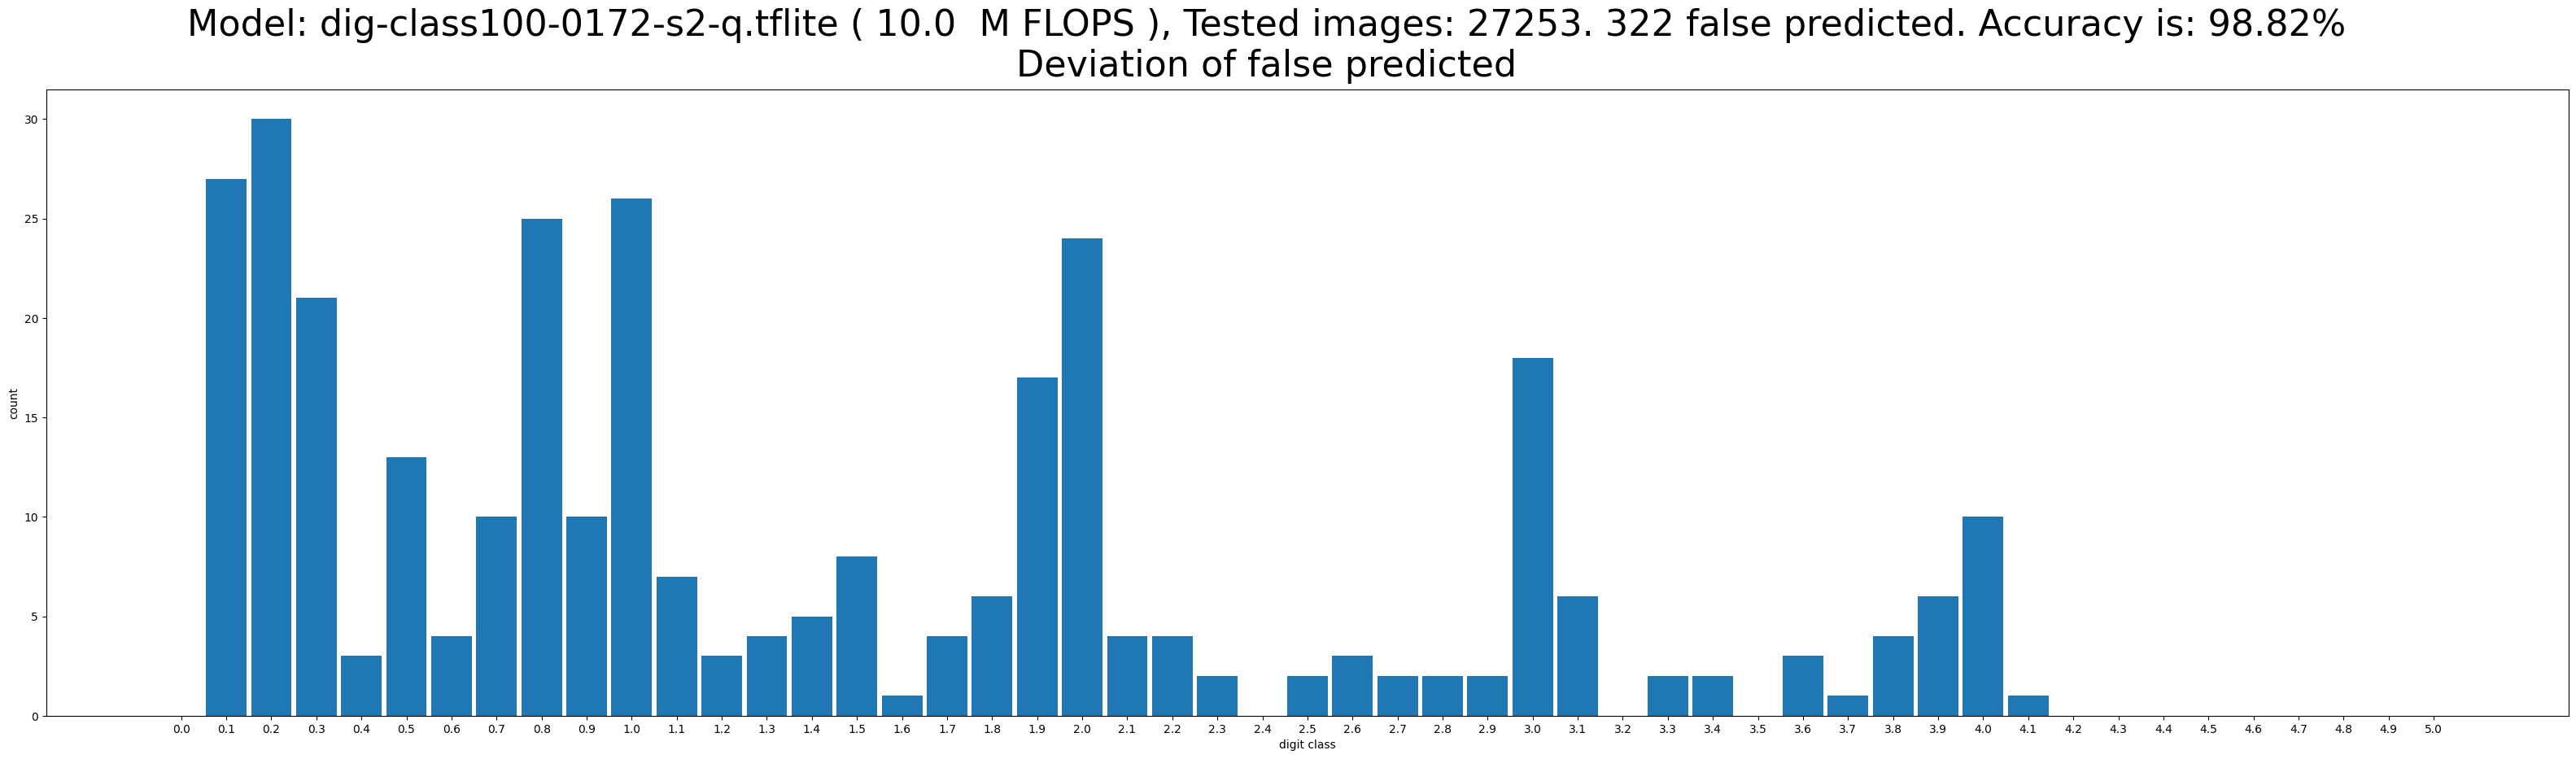

output/dig-class100-0171-s2_q.tflite
shape:[ 1 32 20  3] rgb


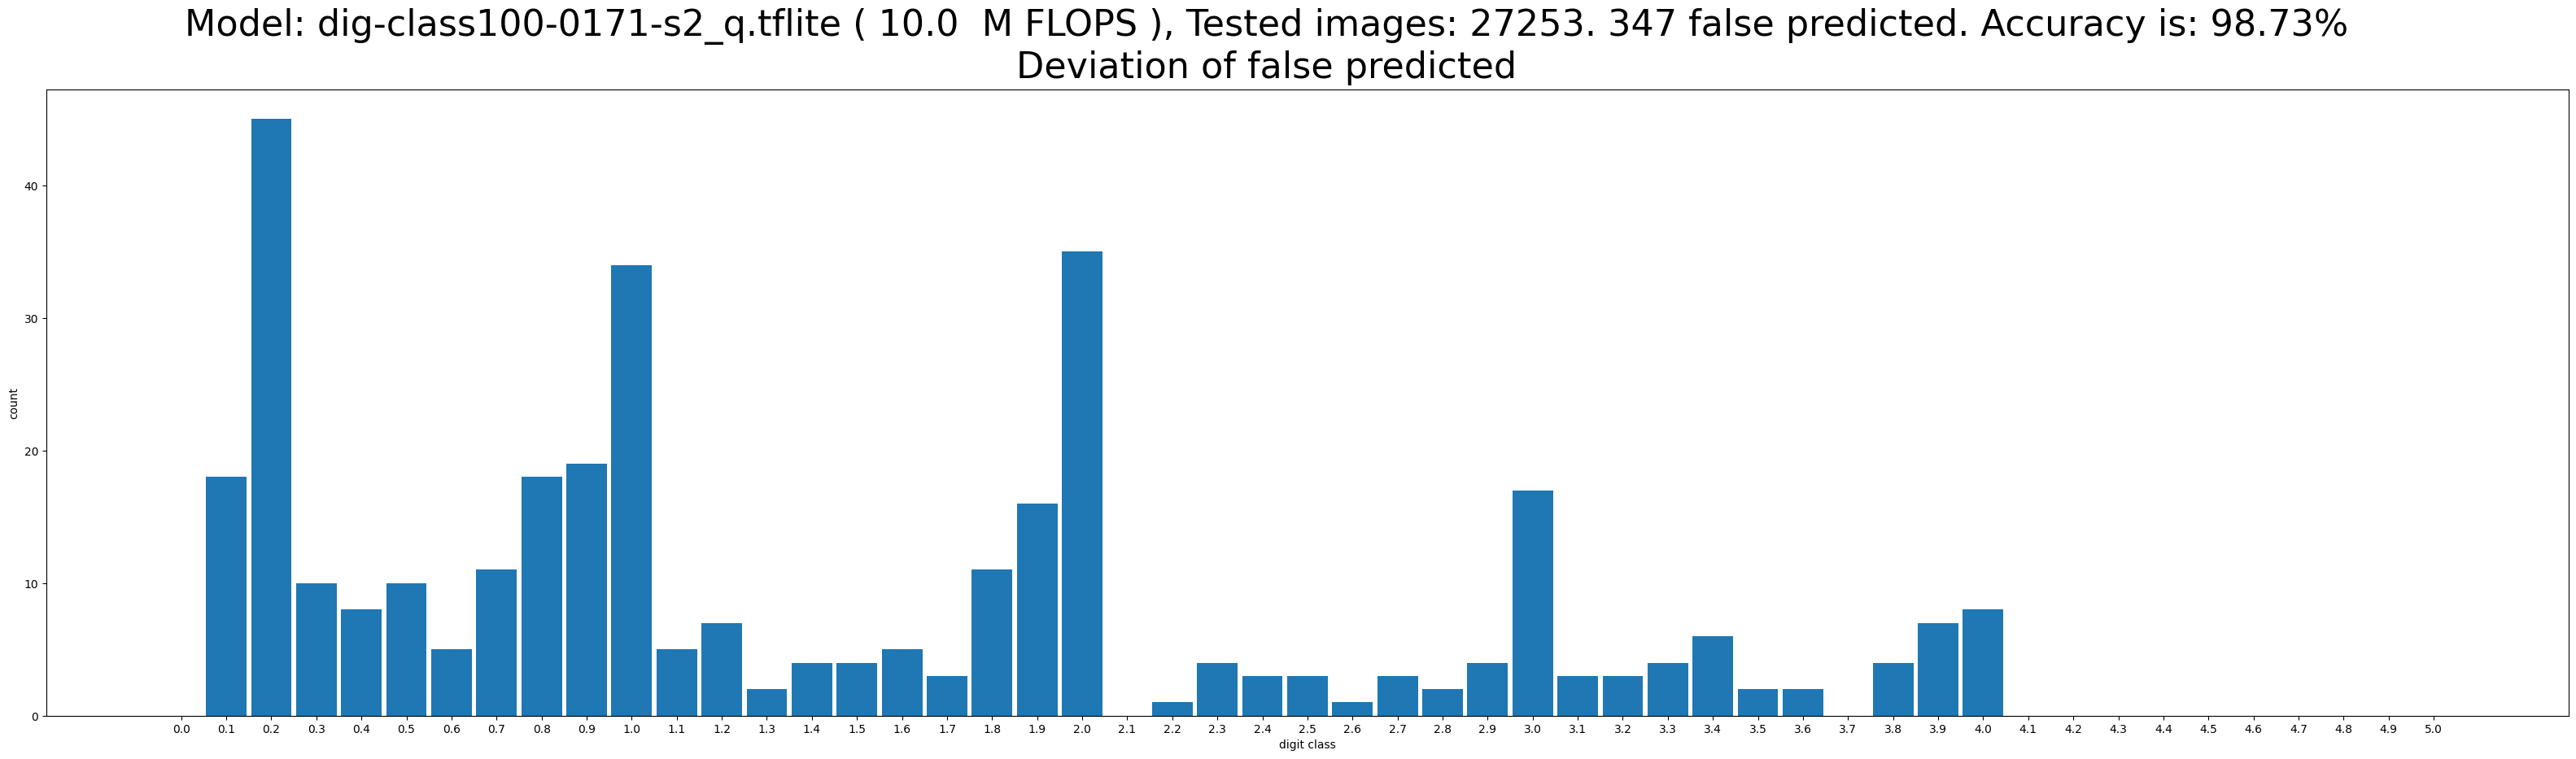

output/dig-class100-0170_s1_q.tflite
shape:[ 1 32 20  3] rgb


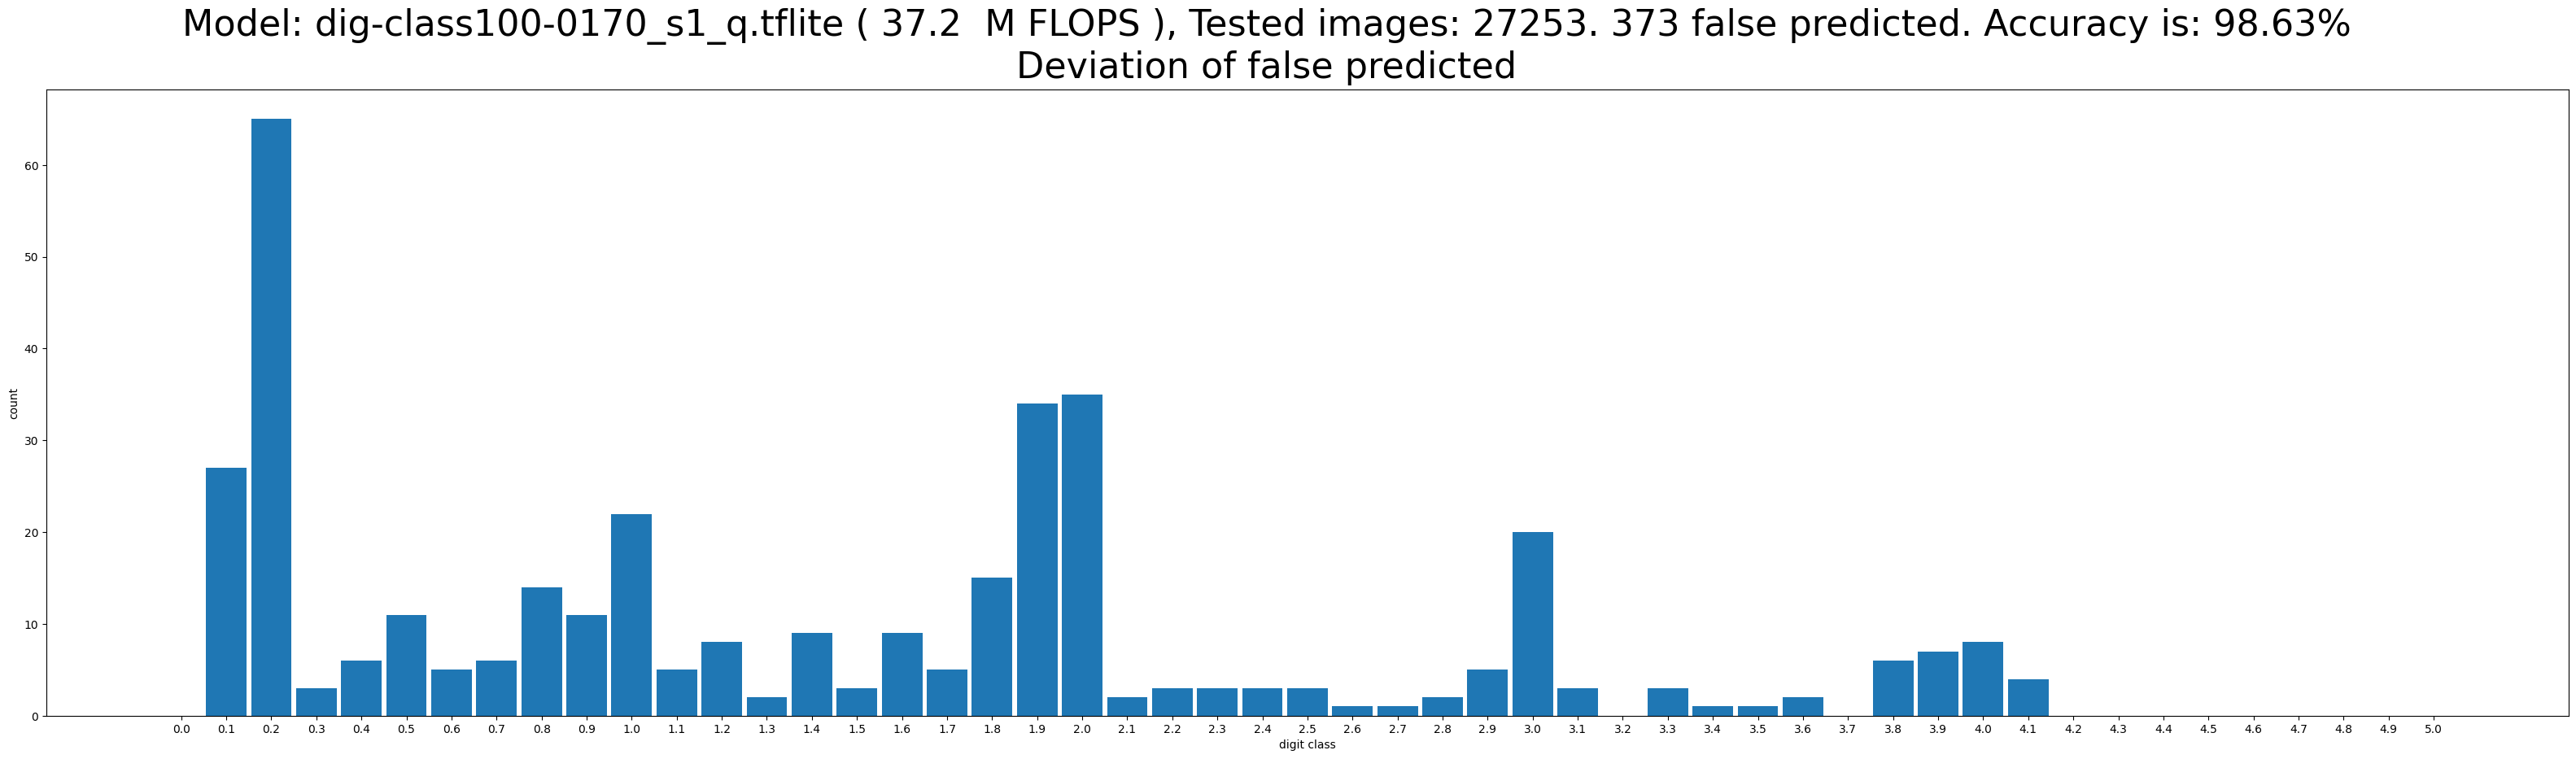

output/dig-class100-0170-s2_q.tflite
shape:[ 1 32 20  3] rgb


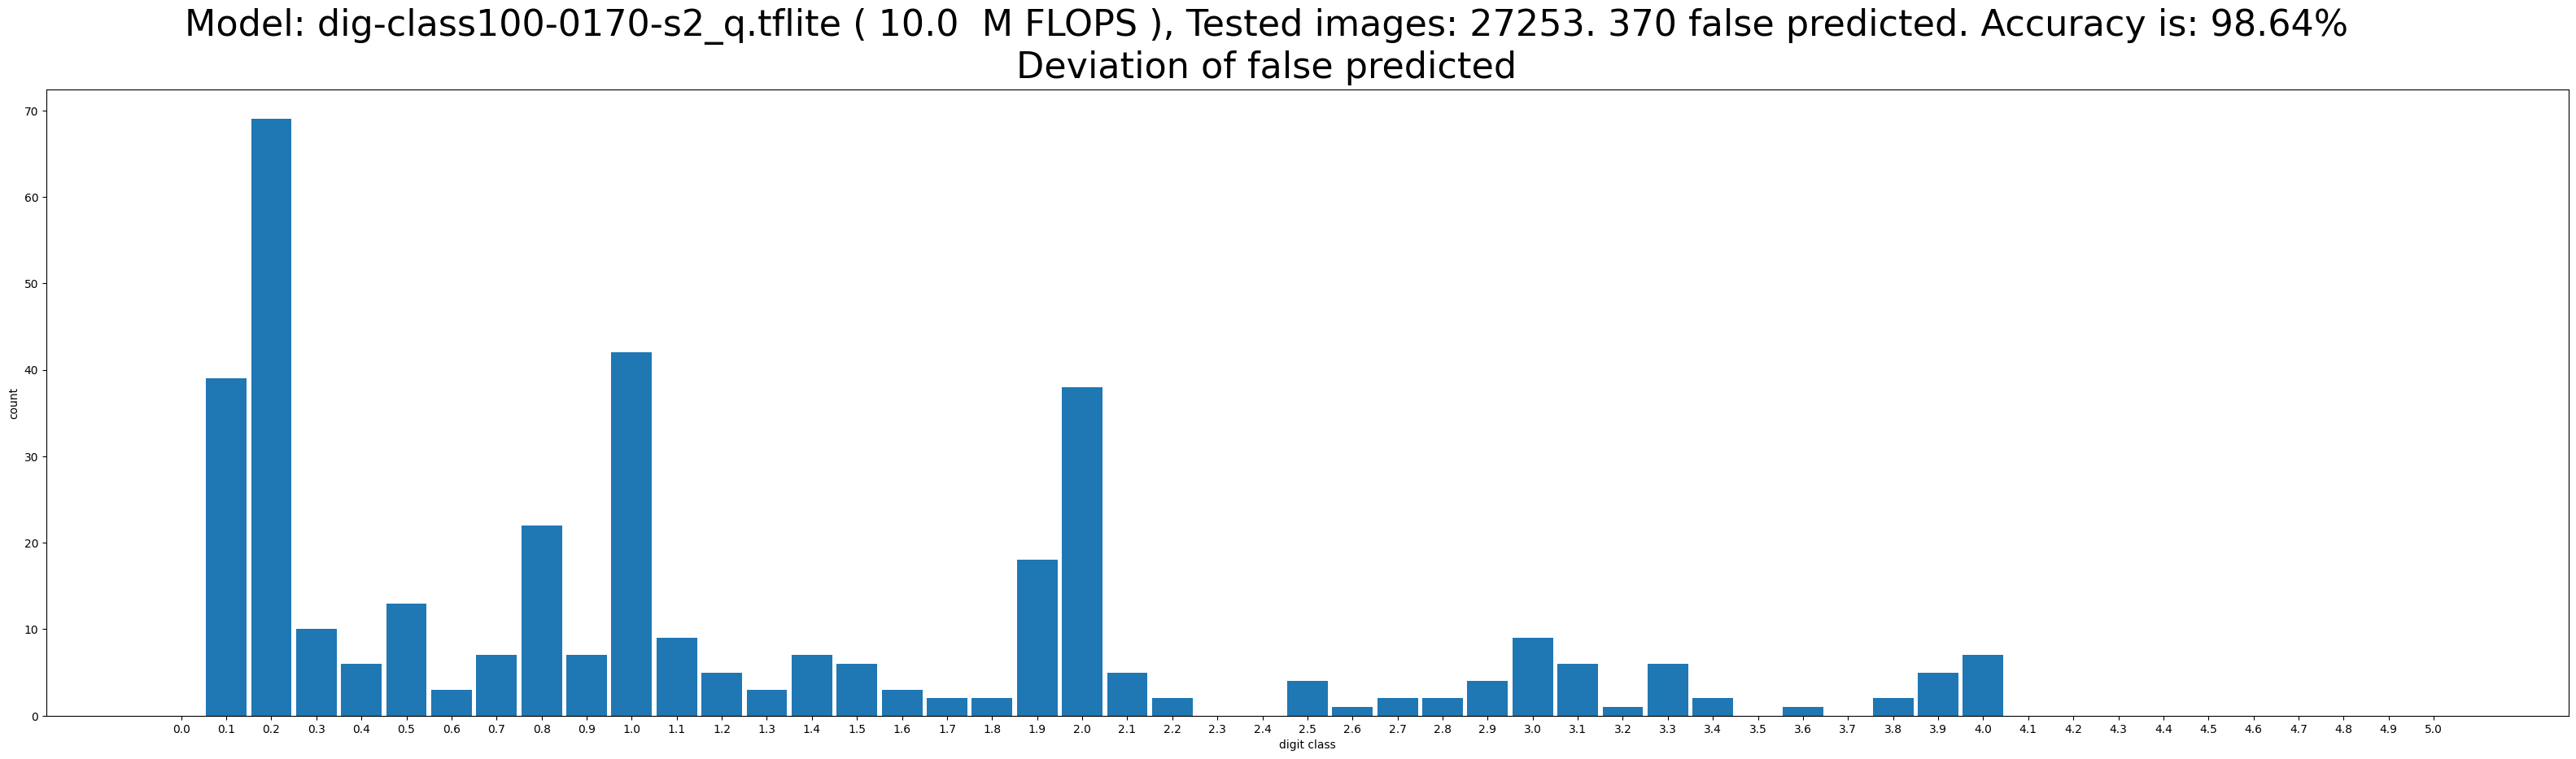

output/dig-class100-0169_s2_q.tflite
shape:[ 1 32 20  3] rgb


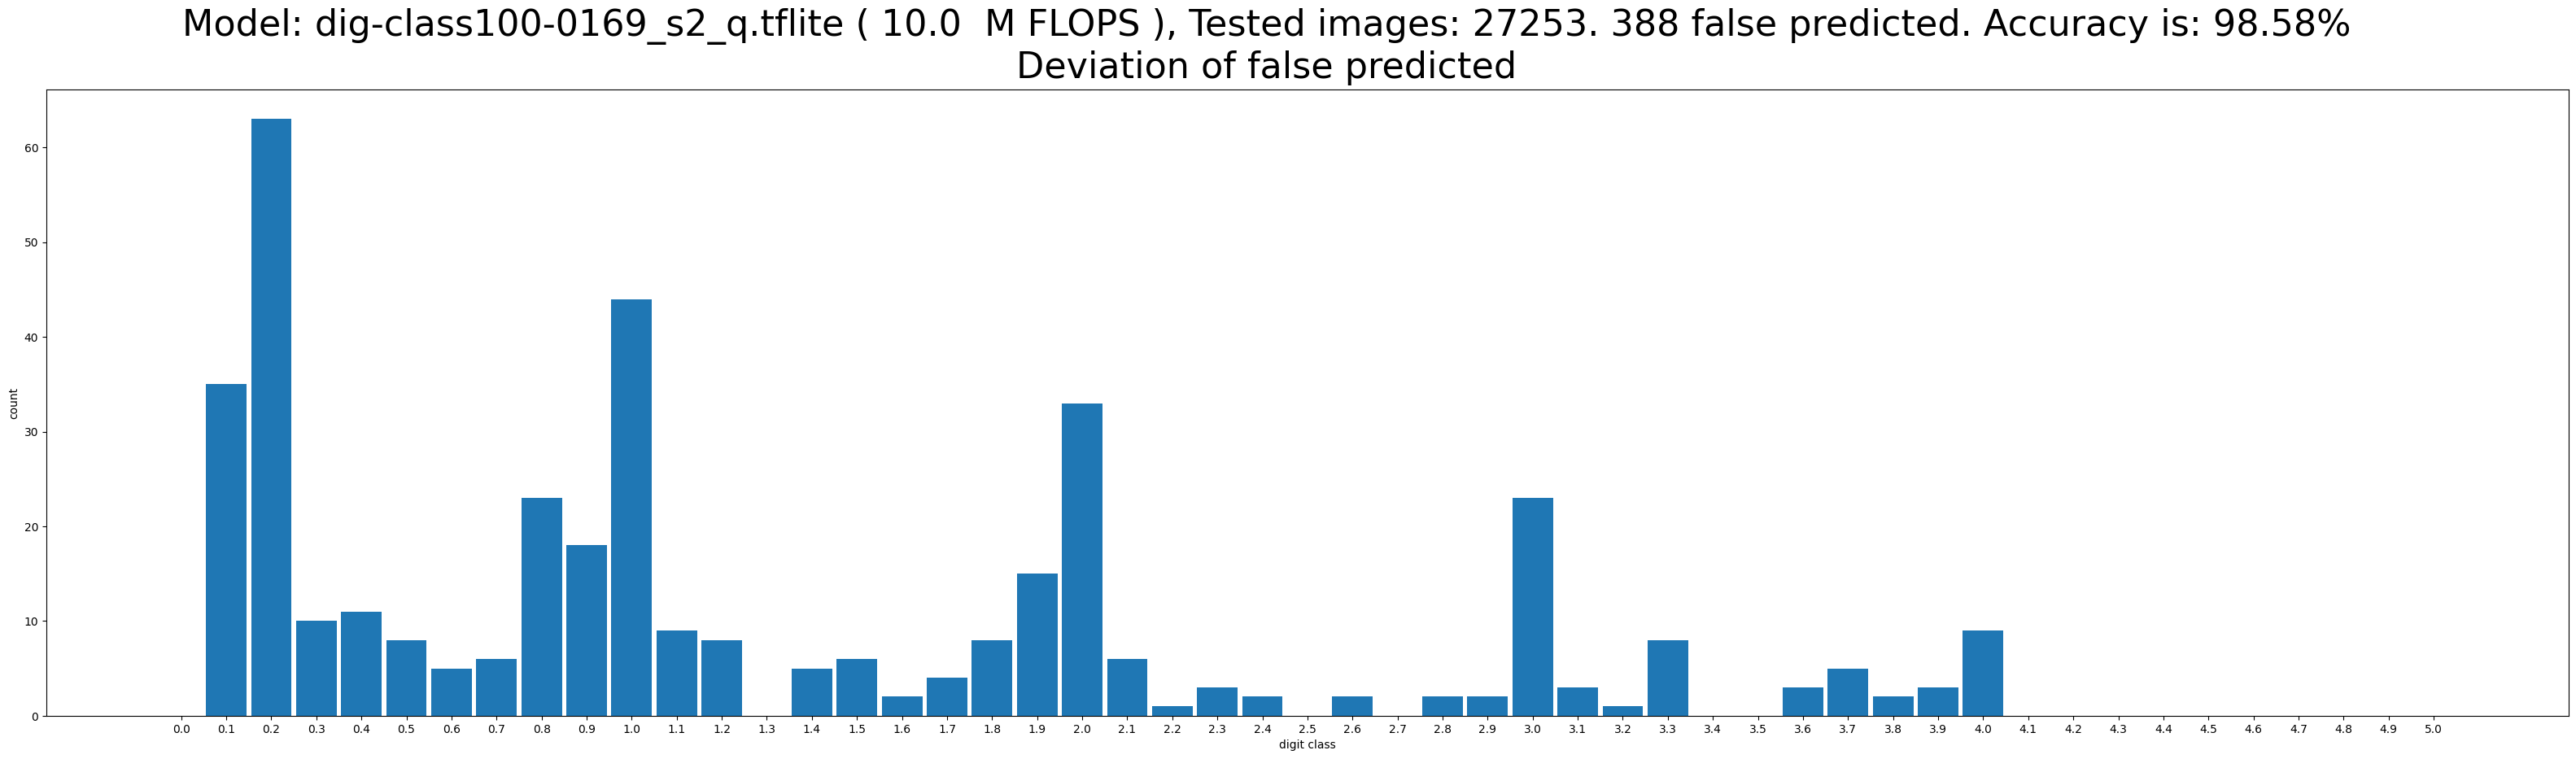

output/dig-class100-0168_s2_q.tflite
shape:[ 1 32 20  3] rgb


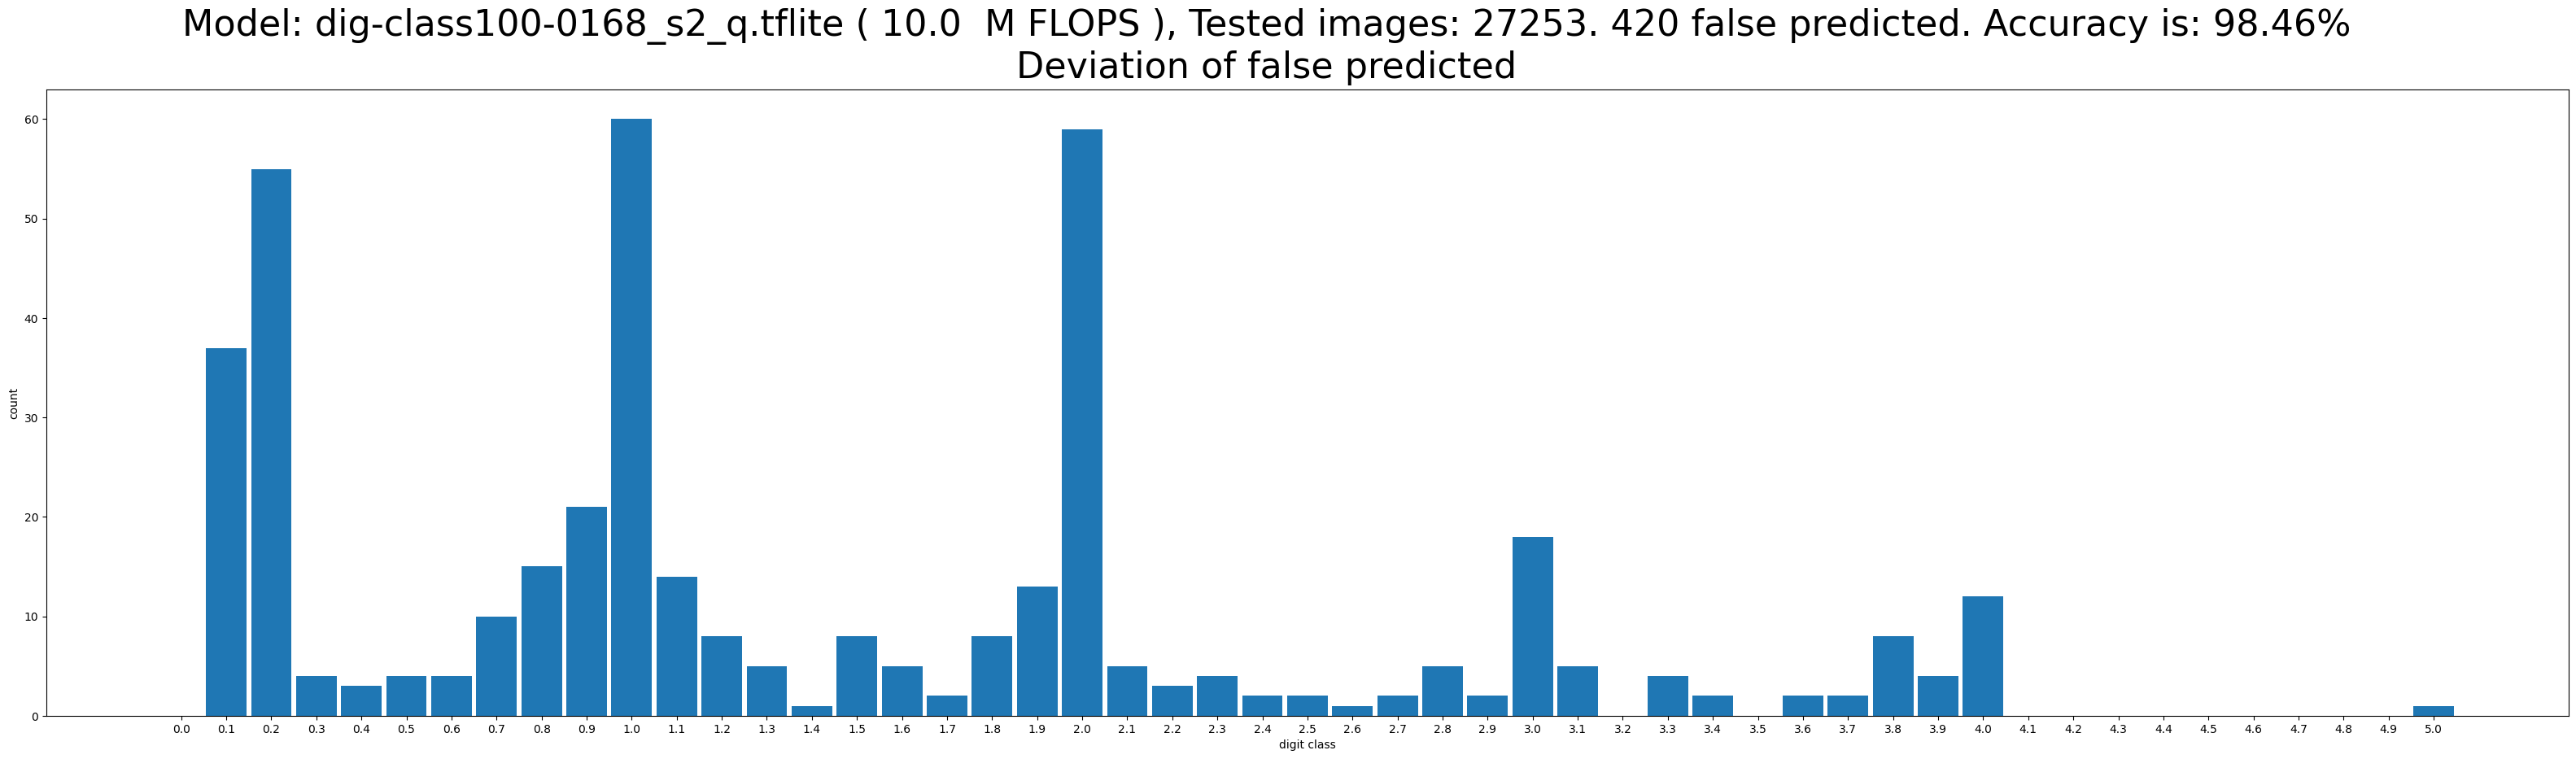

output/dig-class100-0167_s2_q.tflite
shape:[ 1 32 20  3] rgb


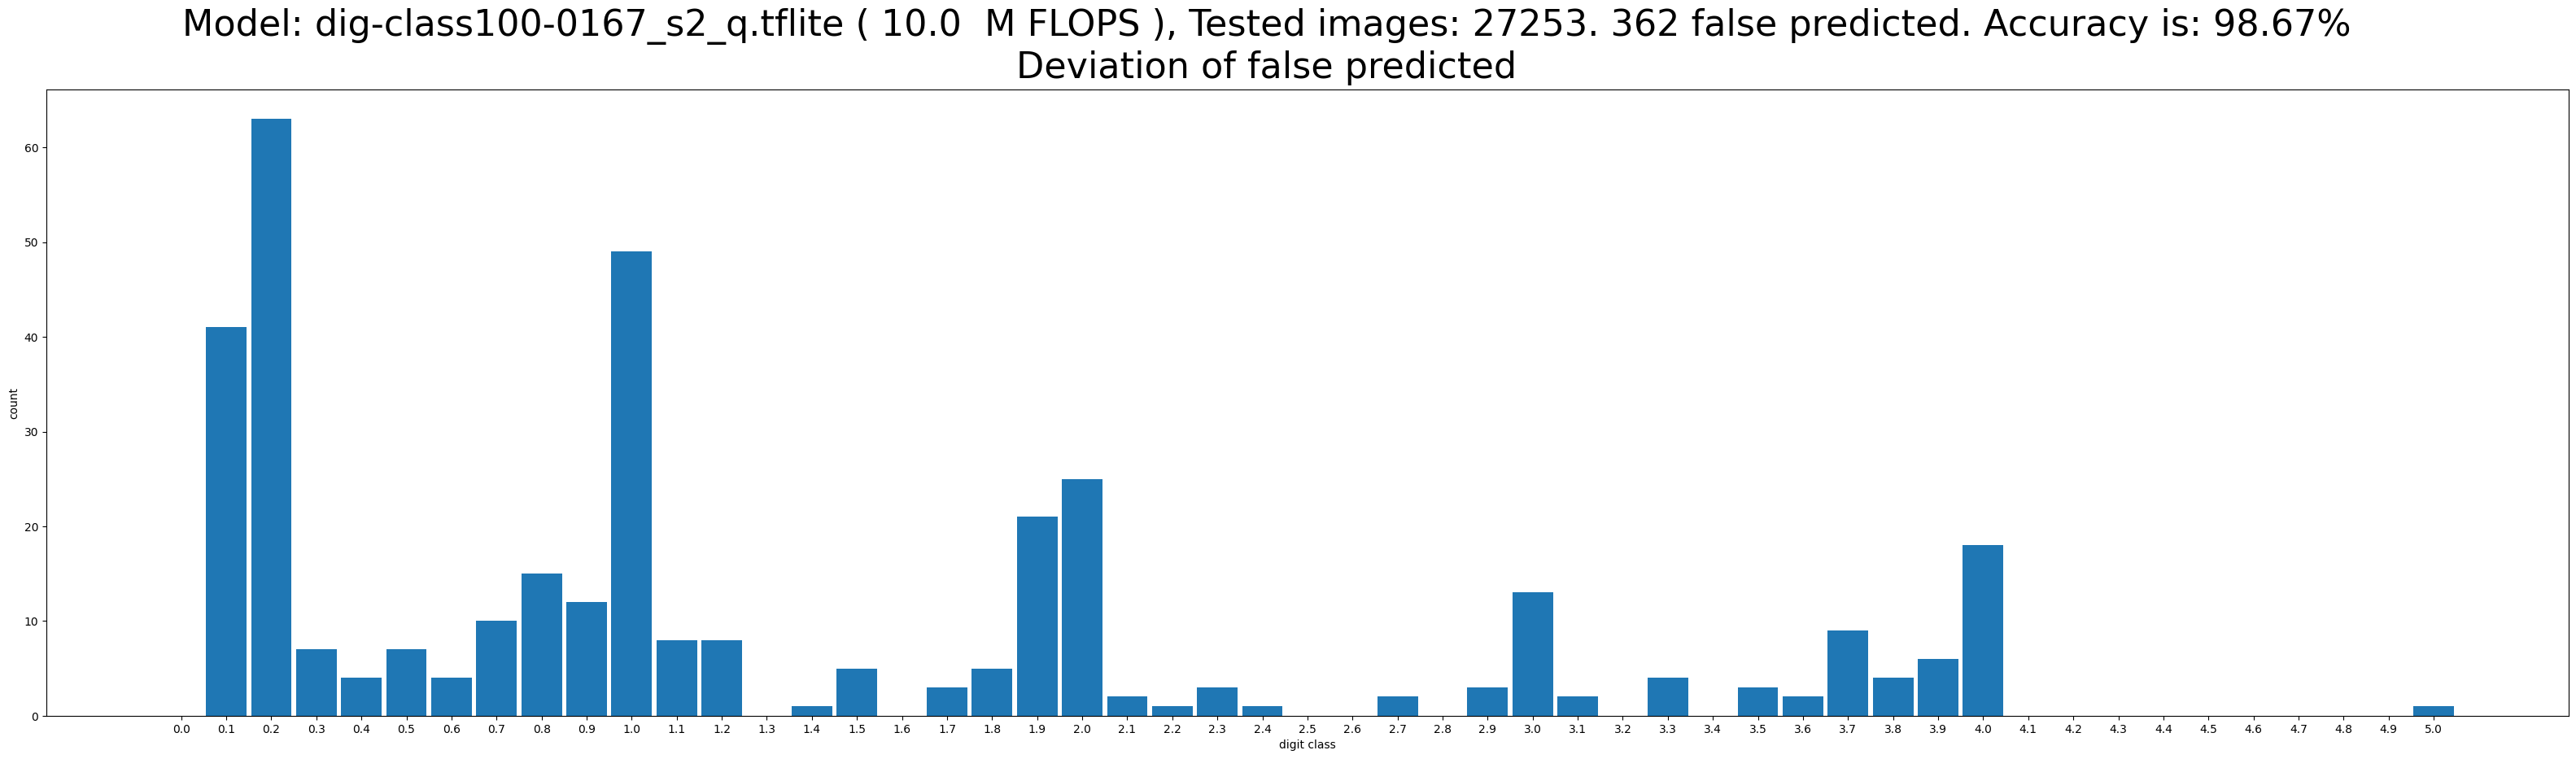

output/dig-class100-0166_s2_q.tflite
shape:[ 1 32 20  3] rgb


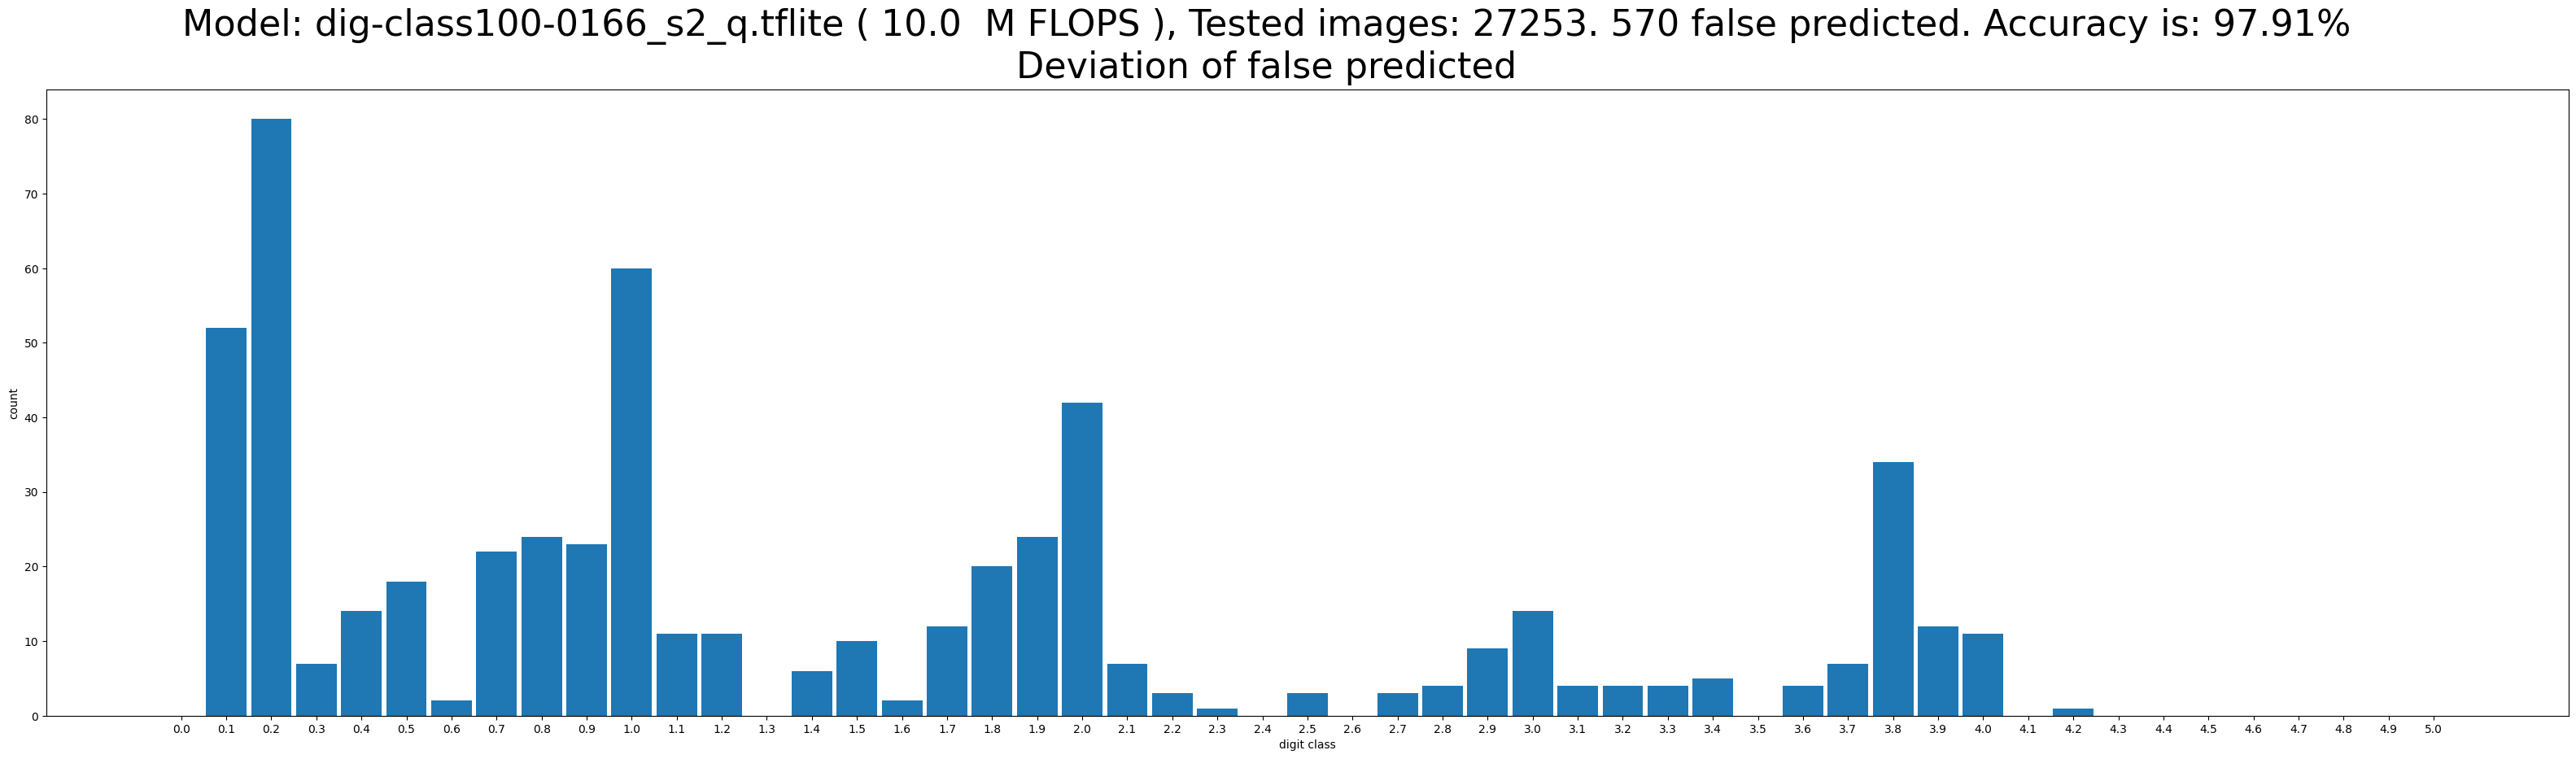

output/dig-class100-0166_s1_q.tflite
shape:[ 1 32 20  3] rgb


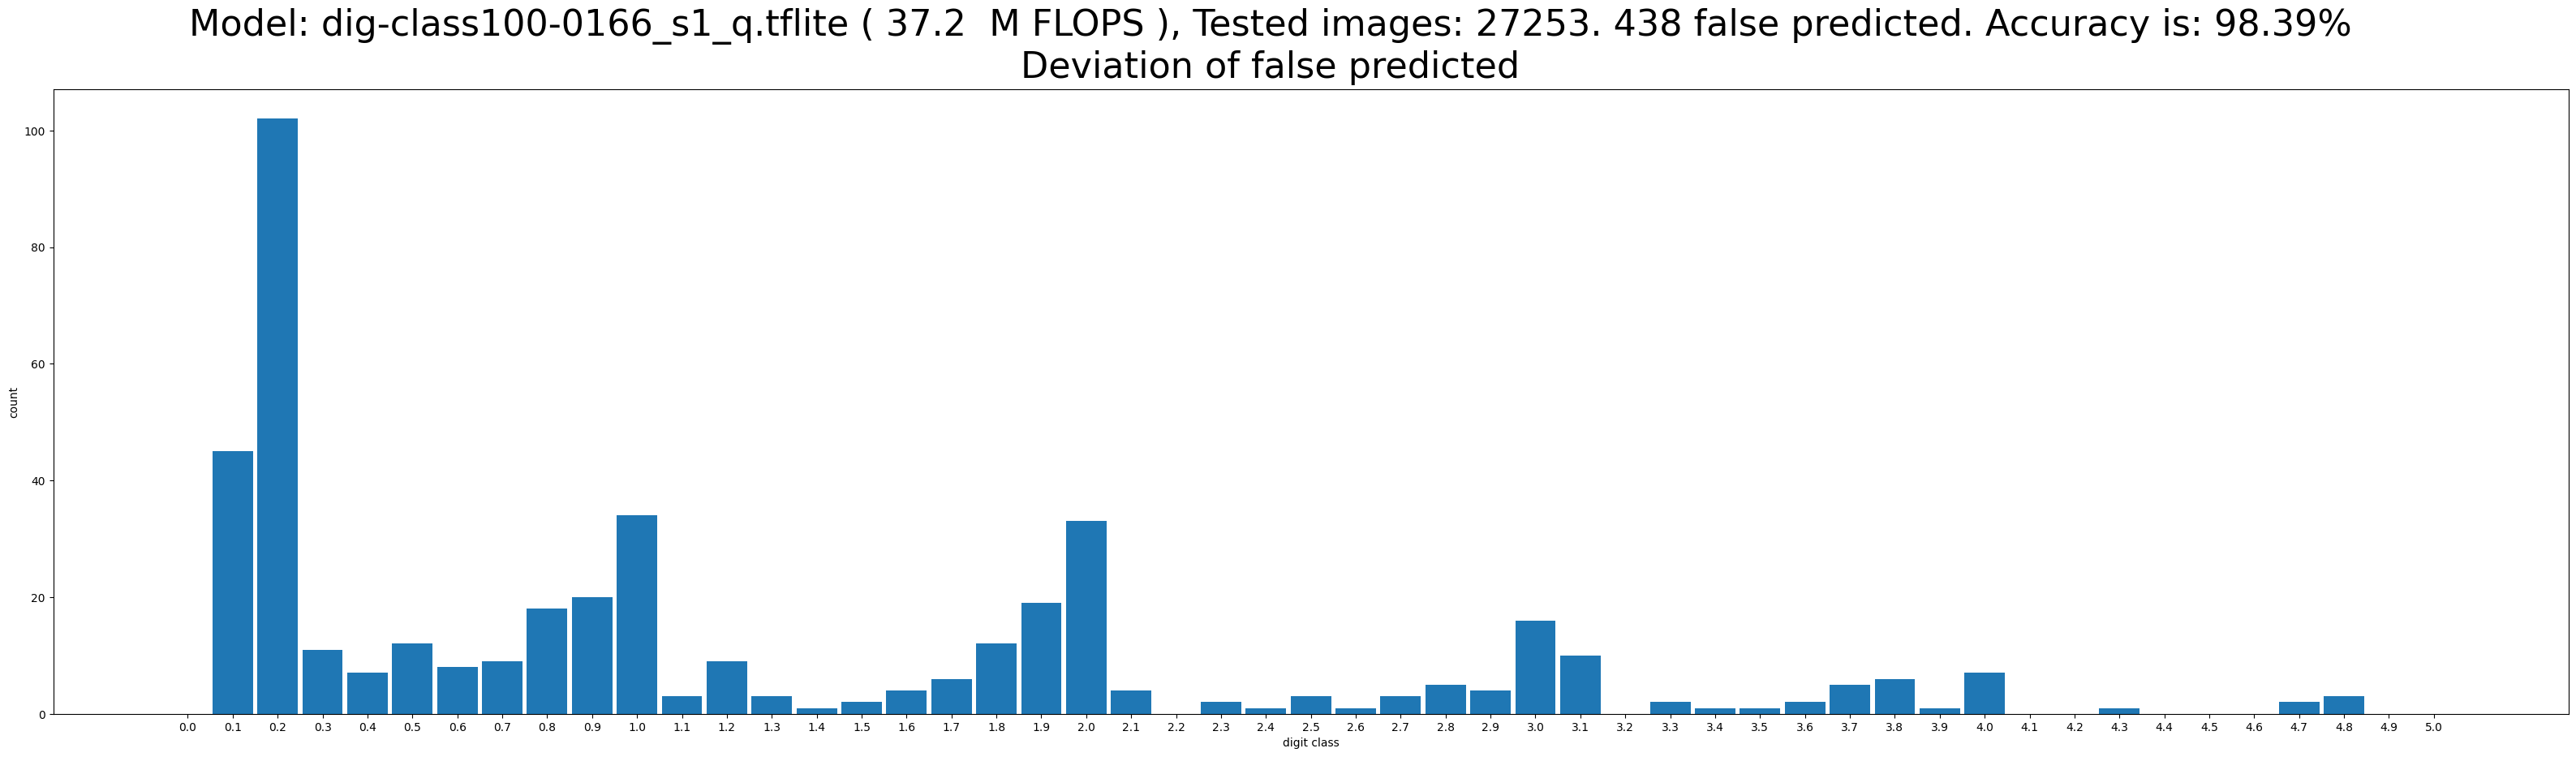

output/dig-class100-0165_s2_q.tflite
shape:[ 1 32 20  3] rgb


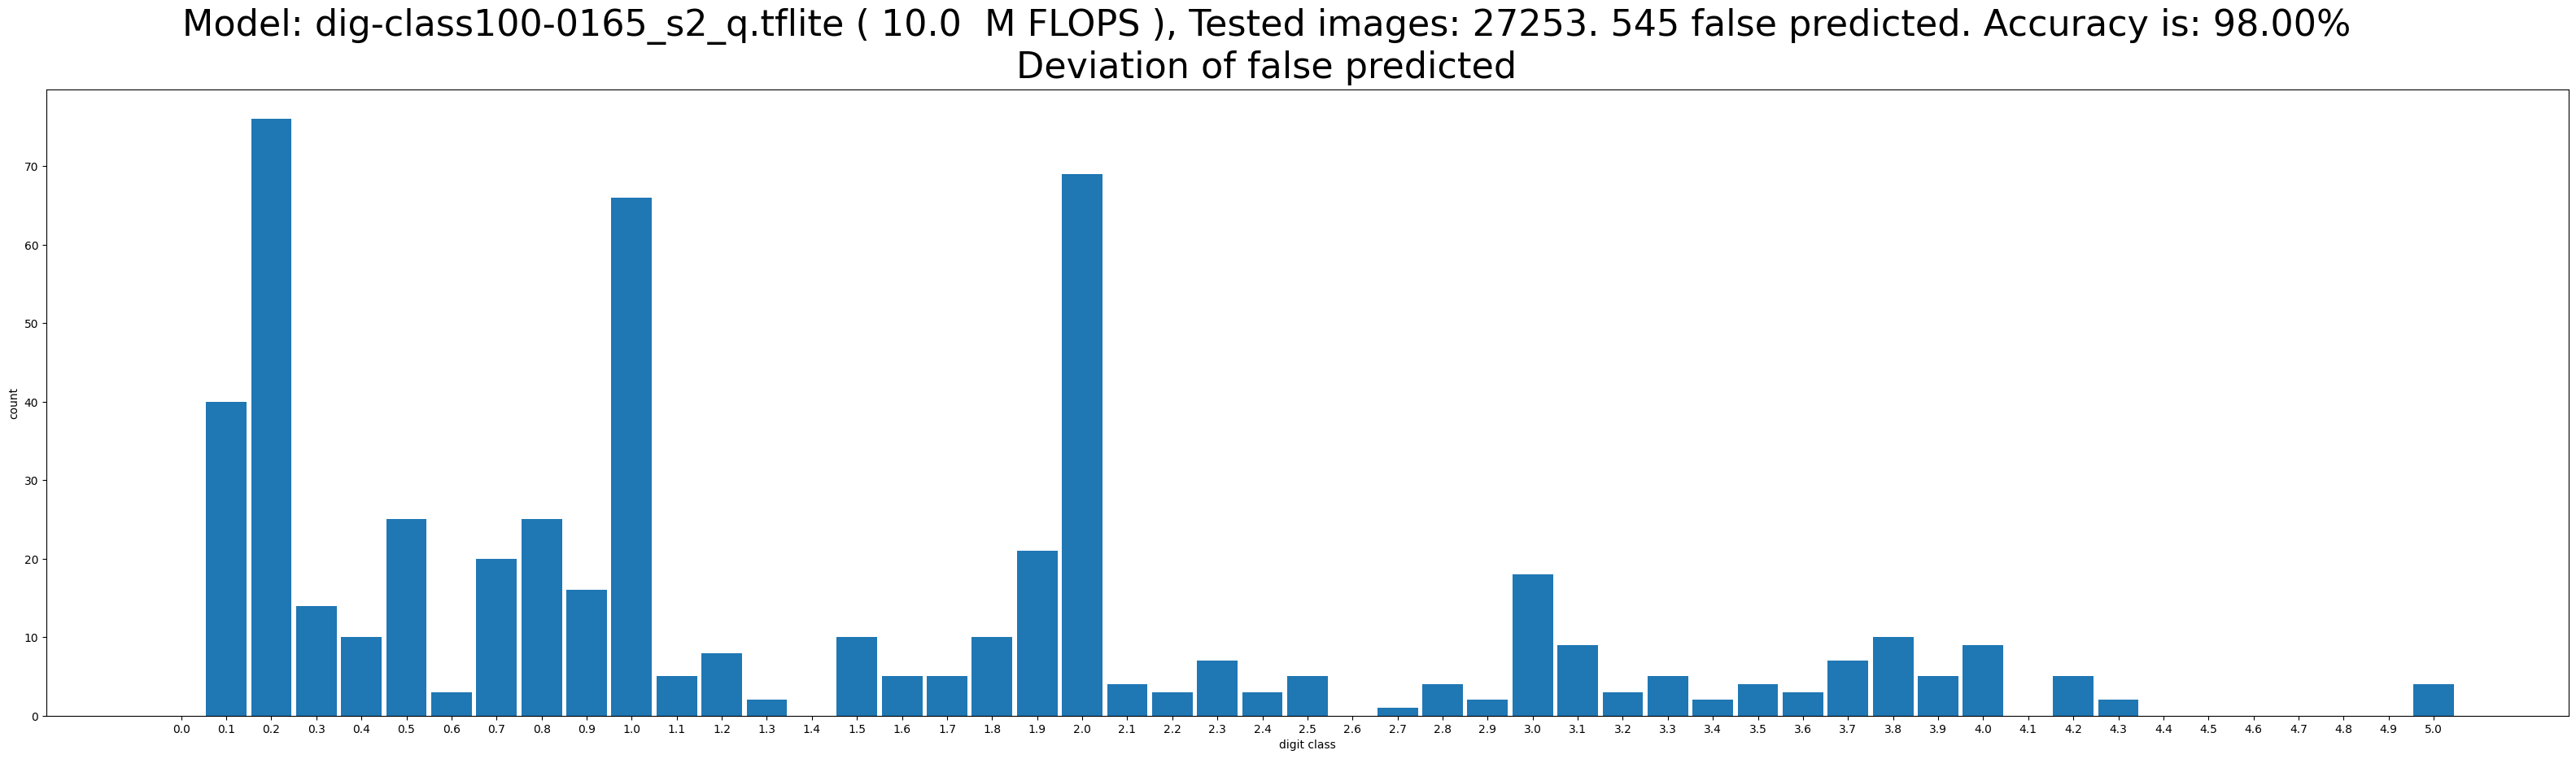

output/dig-class100-0164_s2_q.tflite
shape:[ 1 32 20  3] rgb


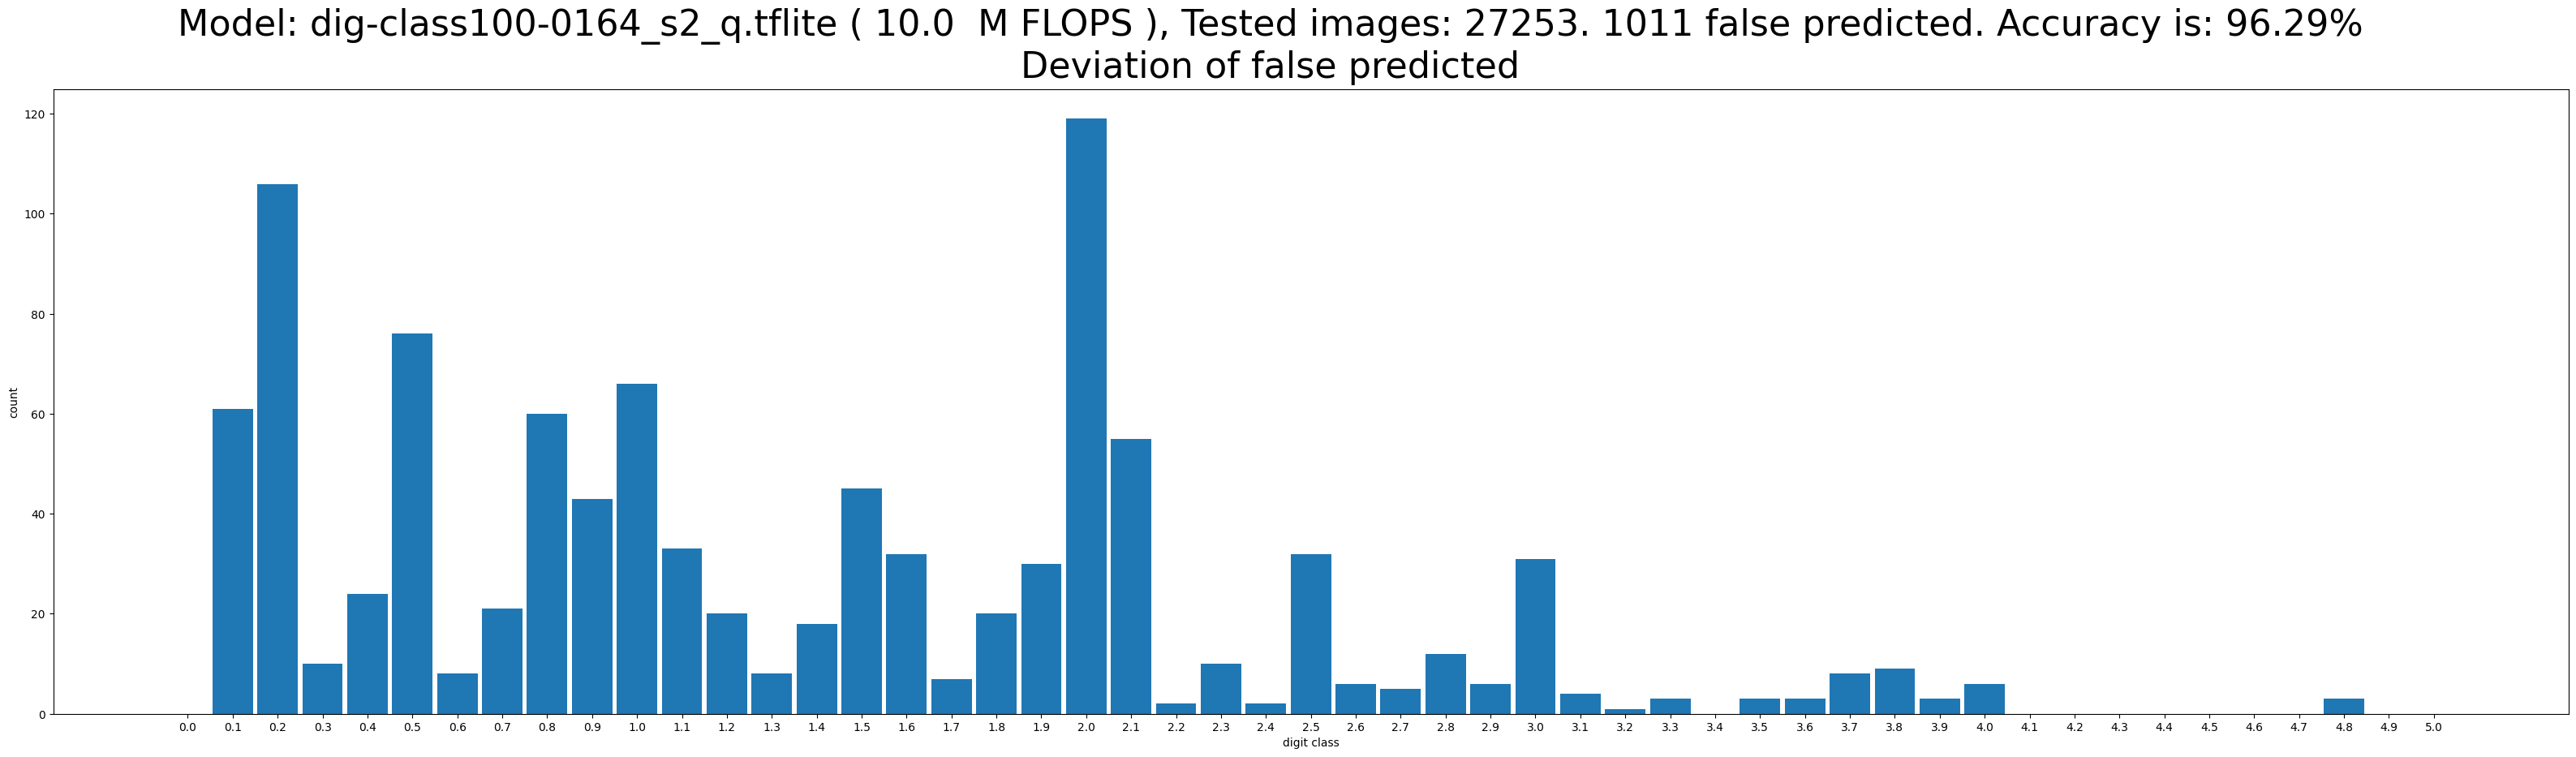

output/dig-class100-0163_s2_q.tflite
shape:[ 1 32 20  3] rgb


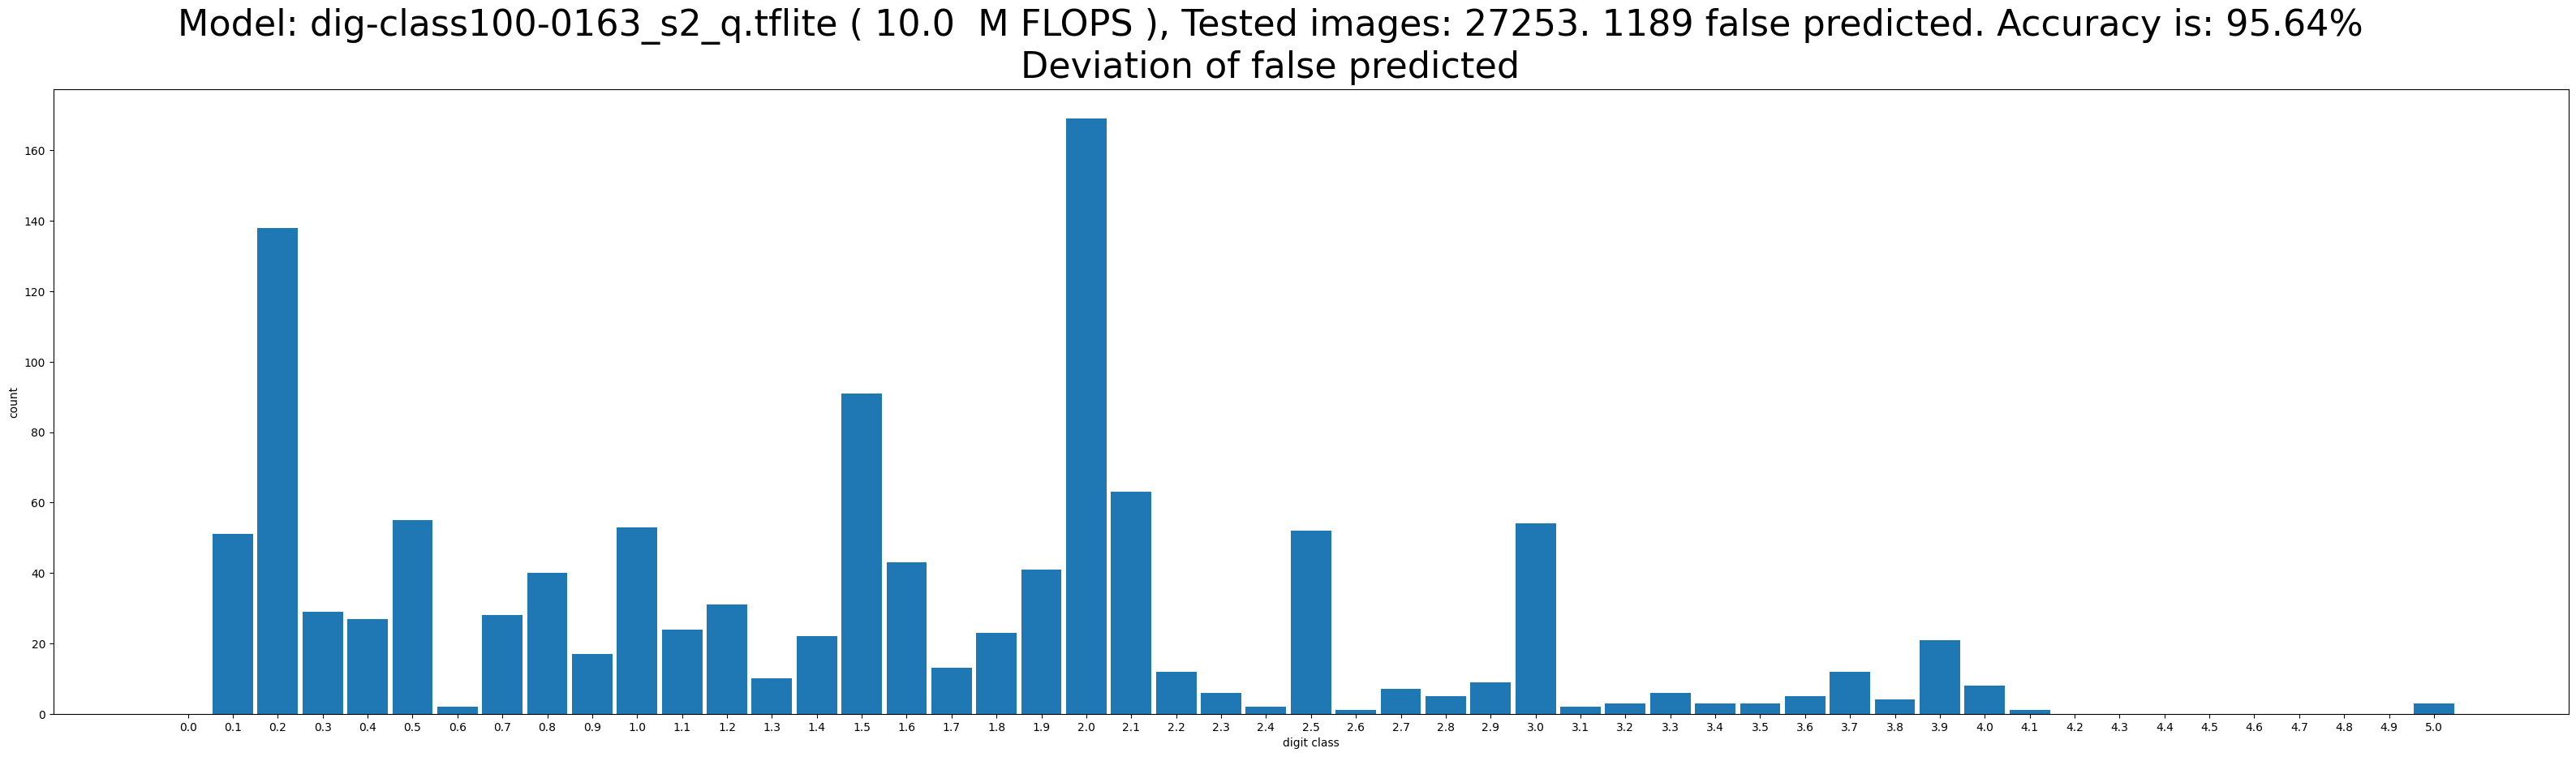

output/dig-class100-0162_s2_q.tflite
shape:[ 1 32 20  3] rgb


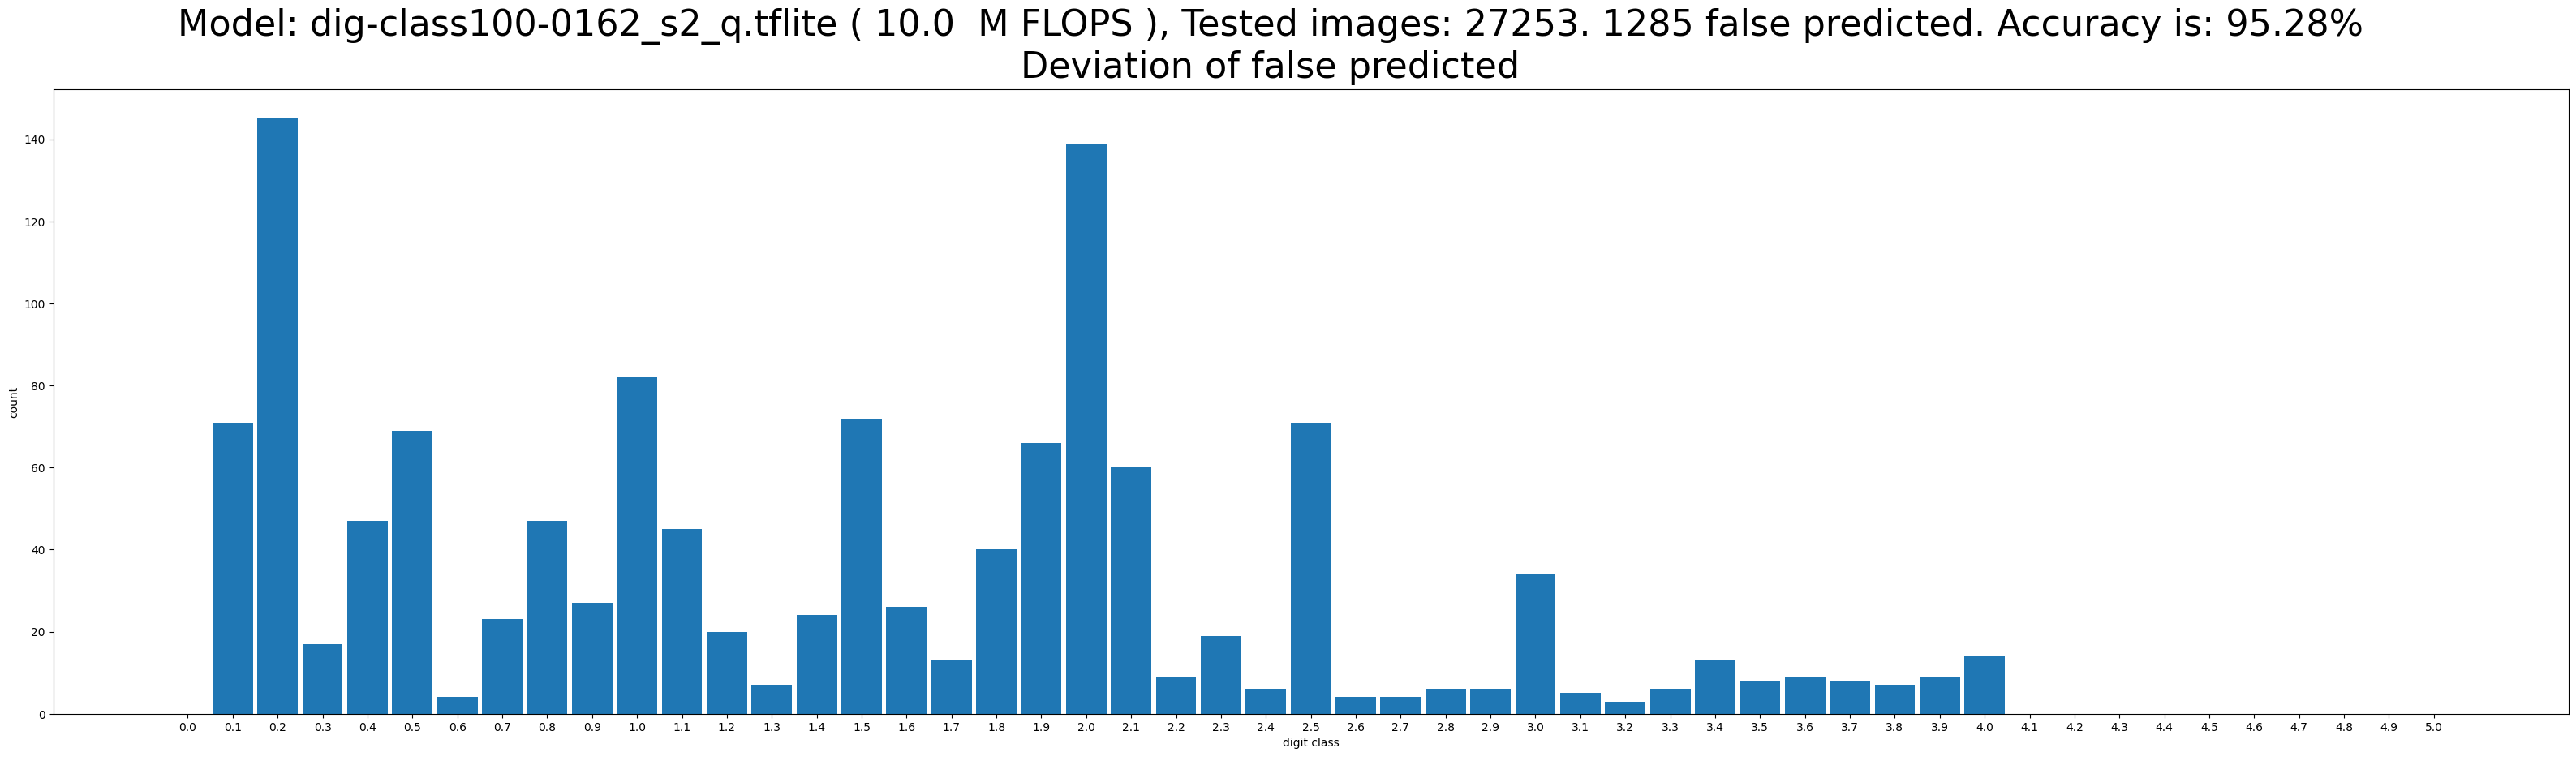

output/dig-class100-0161_s2_q.tflite
shape:[ 1 32 20  3] rgb


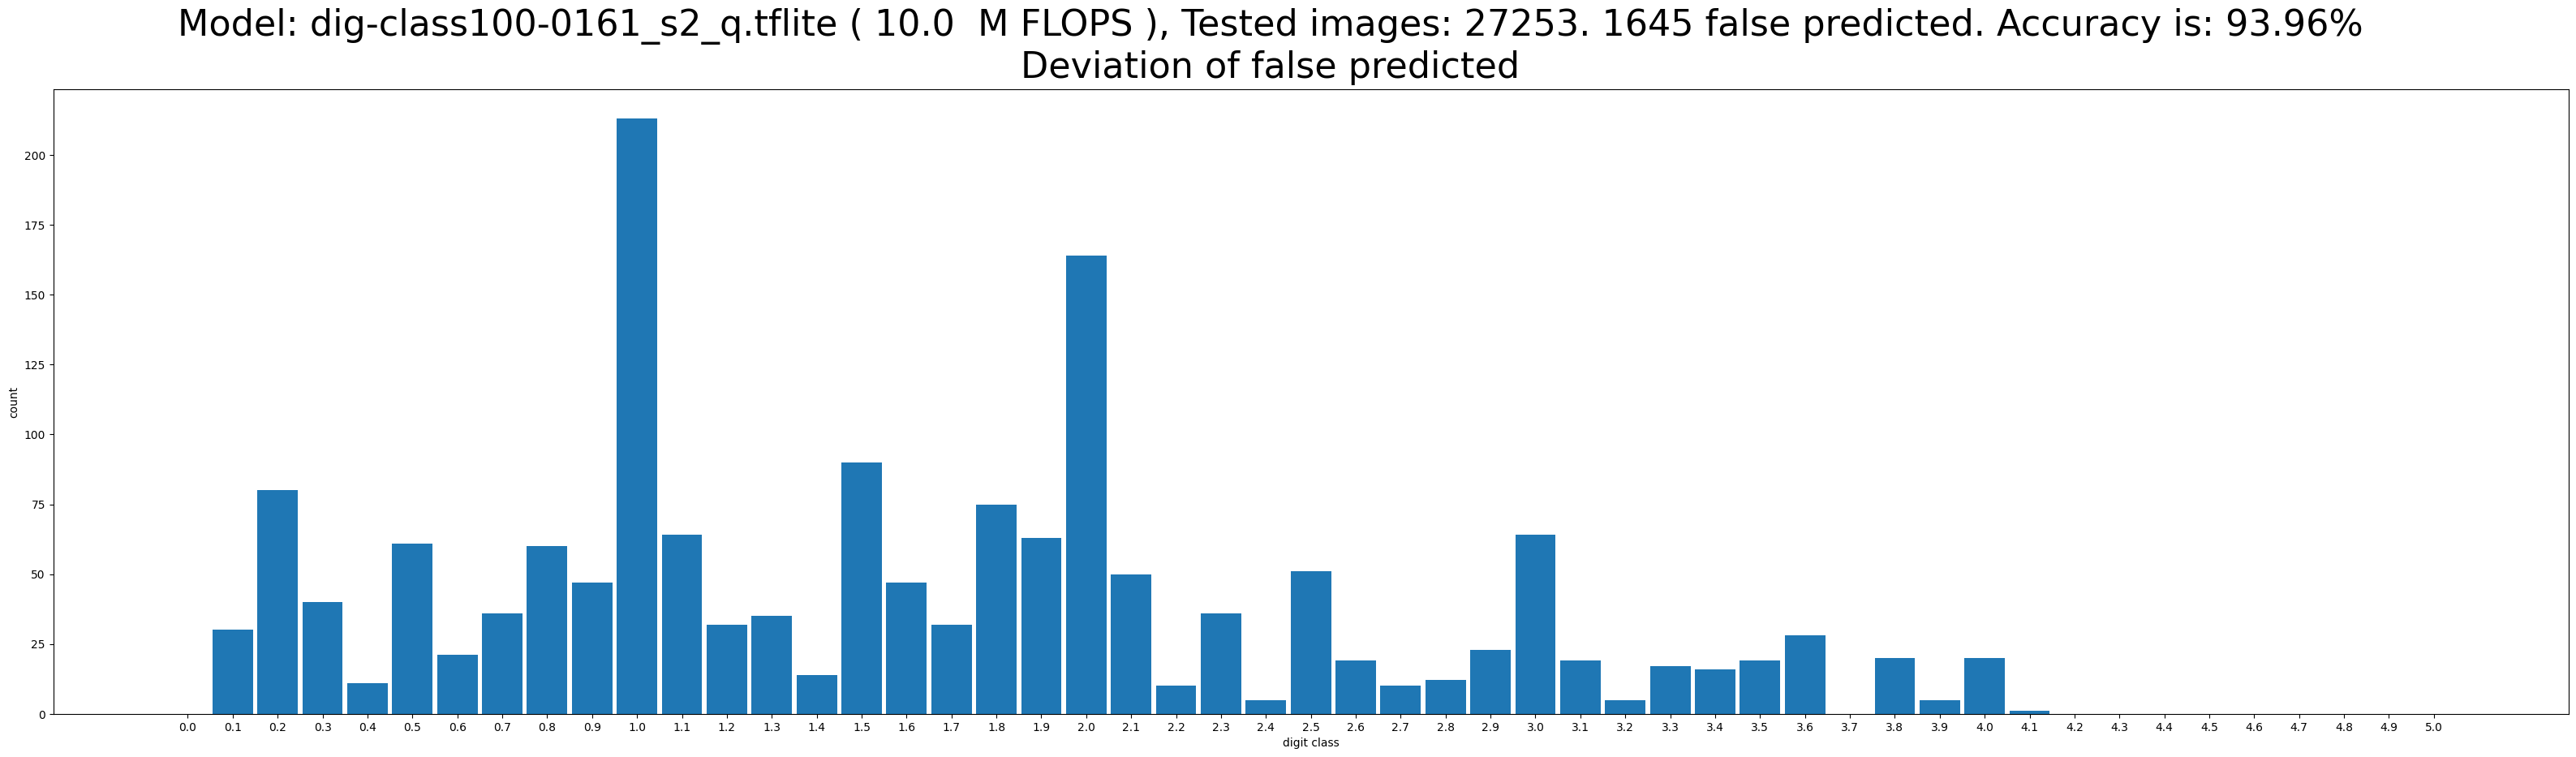

output/dig-class100-0160_s2_q.tflite
shape:[ 1 32 20  3] rgb


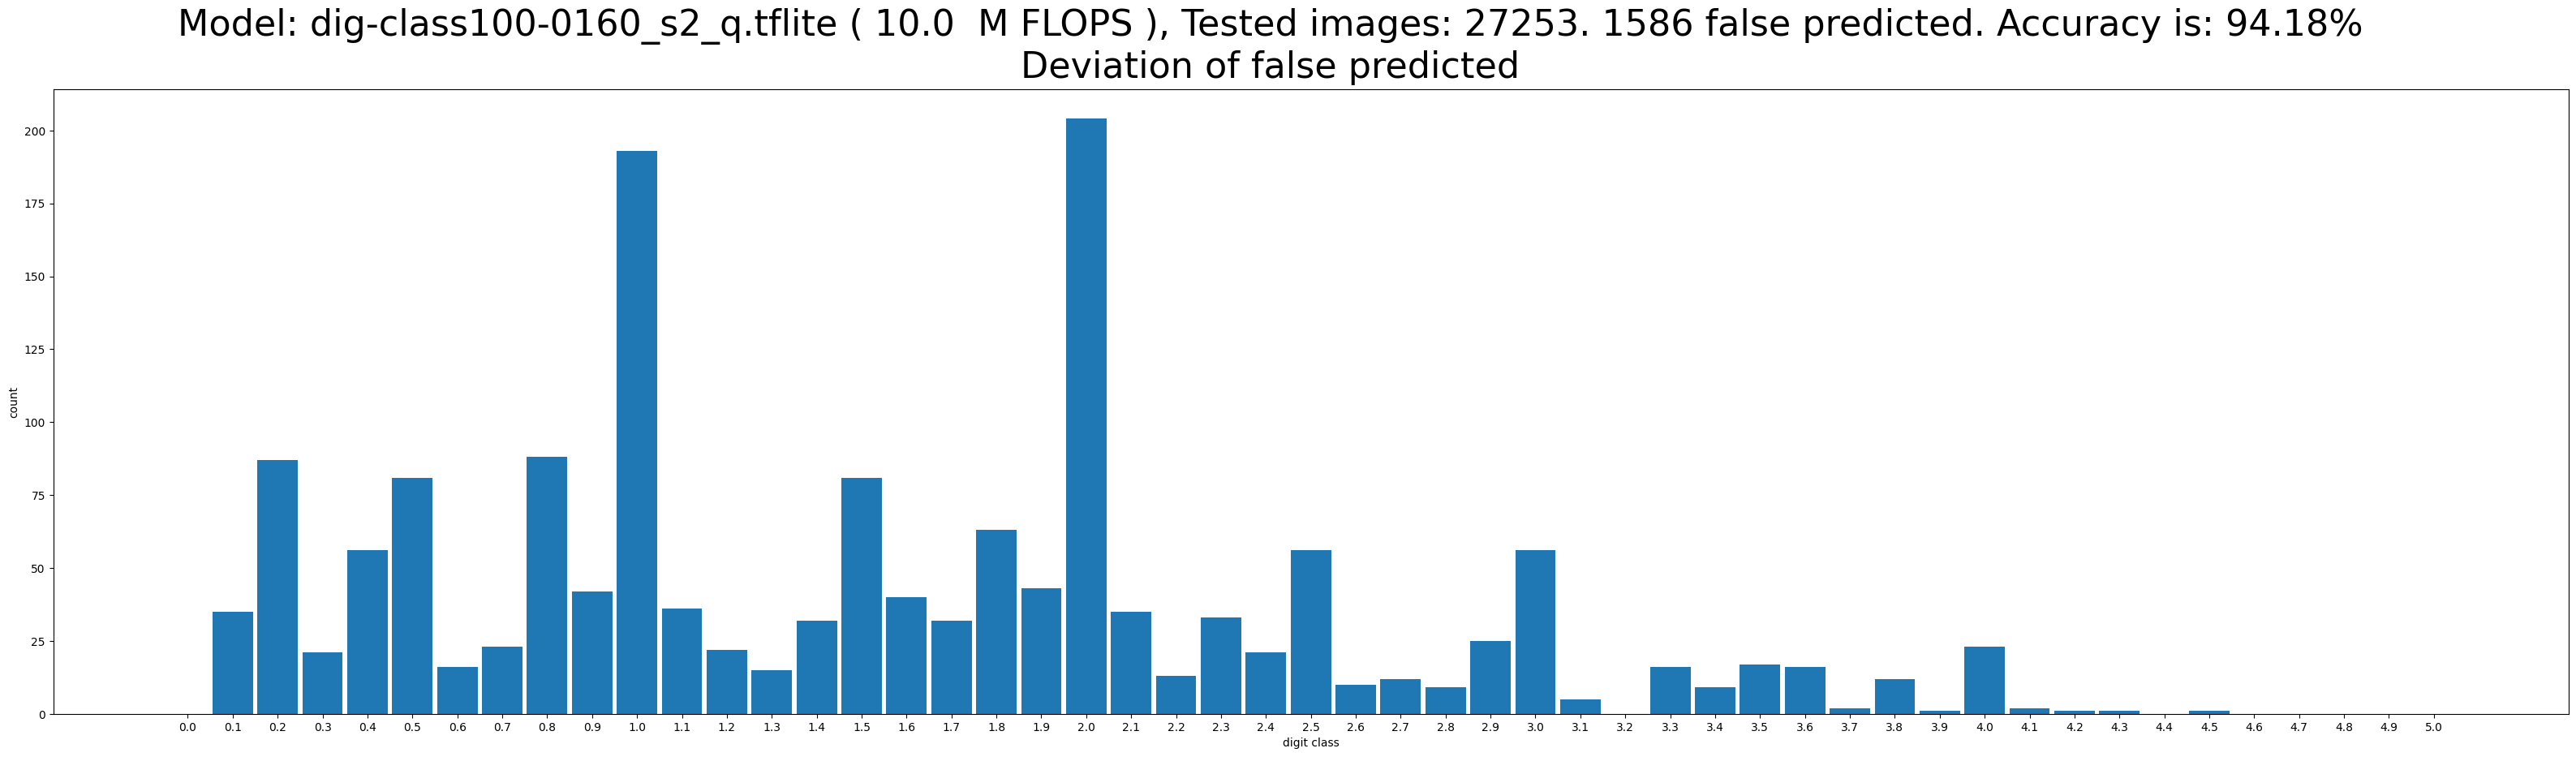

output/dig-class100-0160_s1_q.tflite
shape:[ 1 32 20  3] rgb


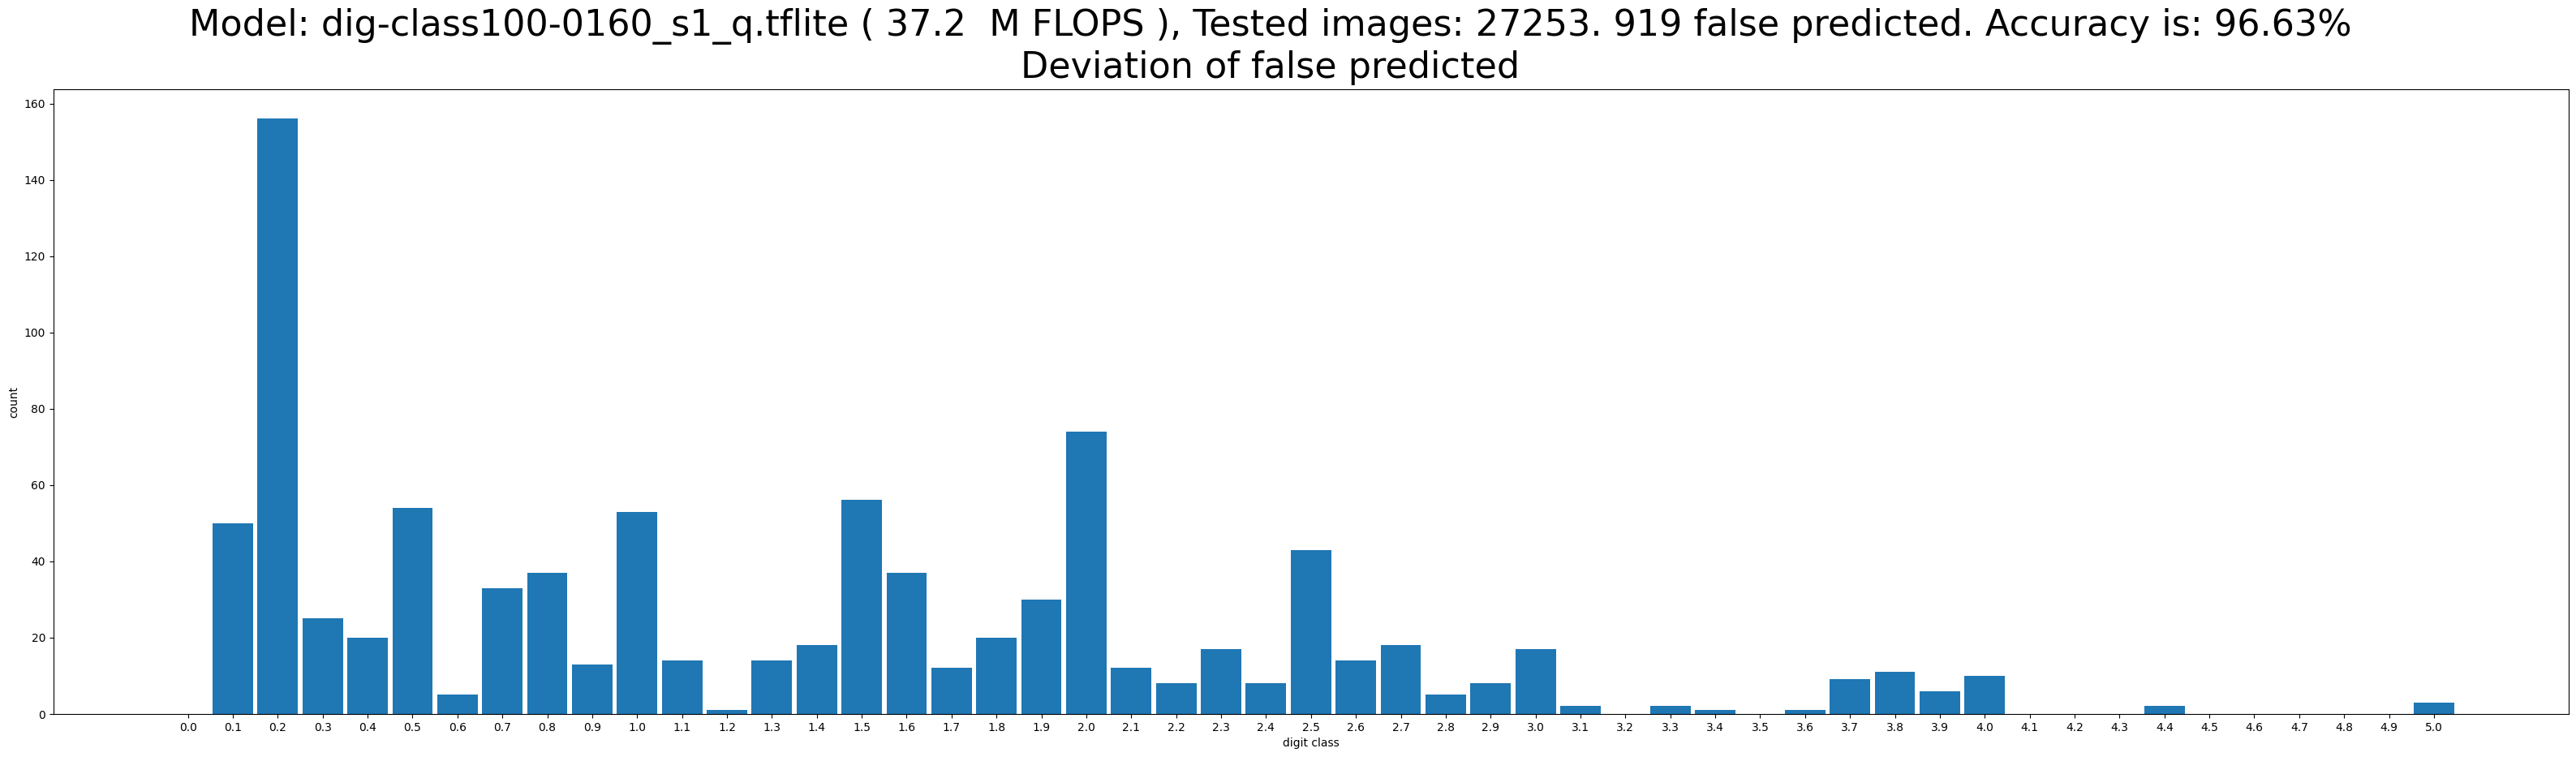

output/dig-class100-0150_s2_q.tflite
shape:[ 1 32 20  3] rgb


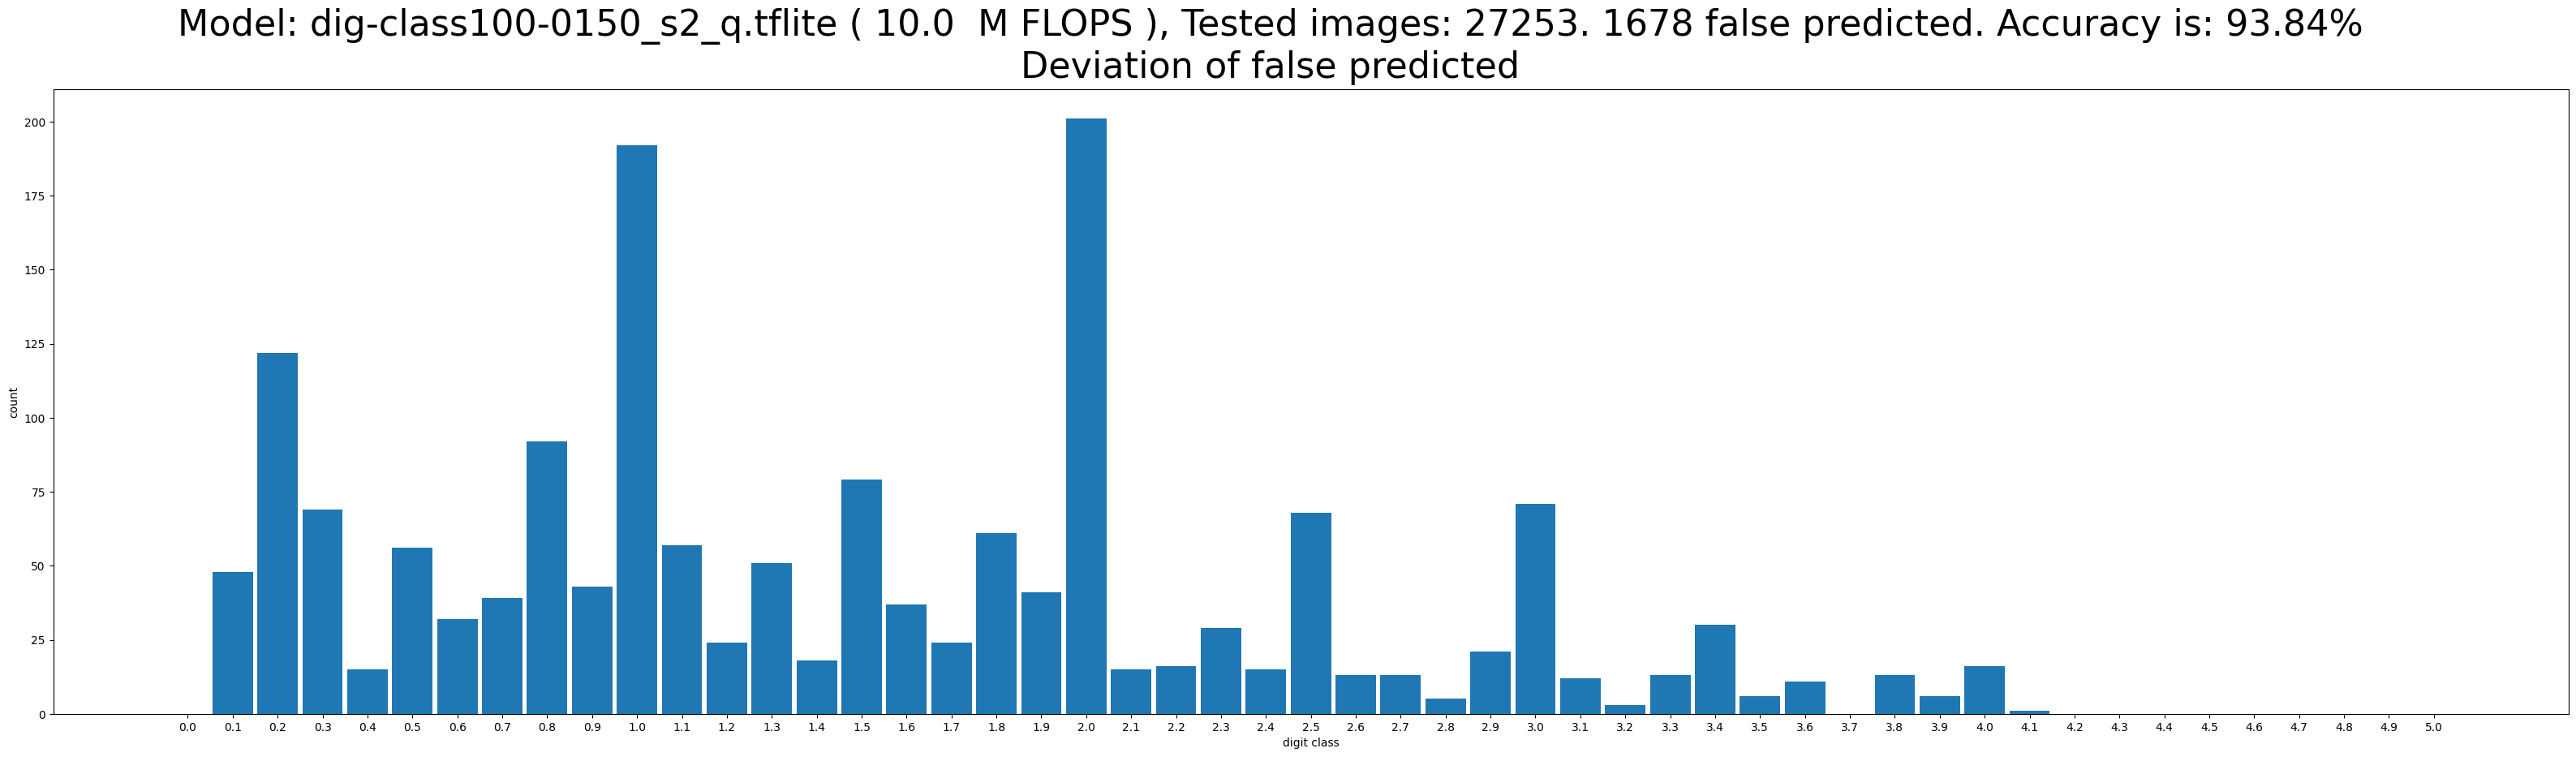

output/dig-class100-0140_s2_q.tflite
shape:[ 1 32 20  3] rgb


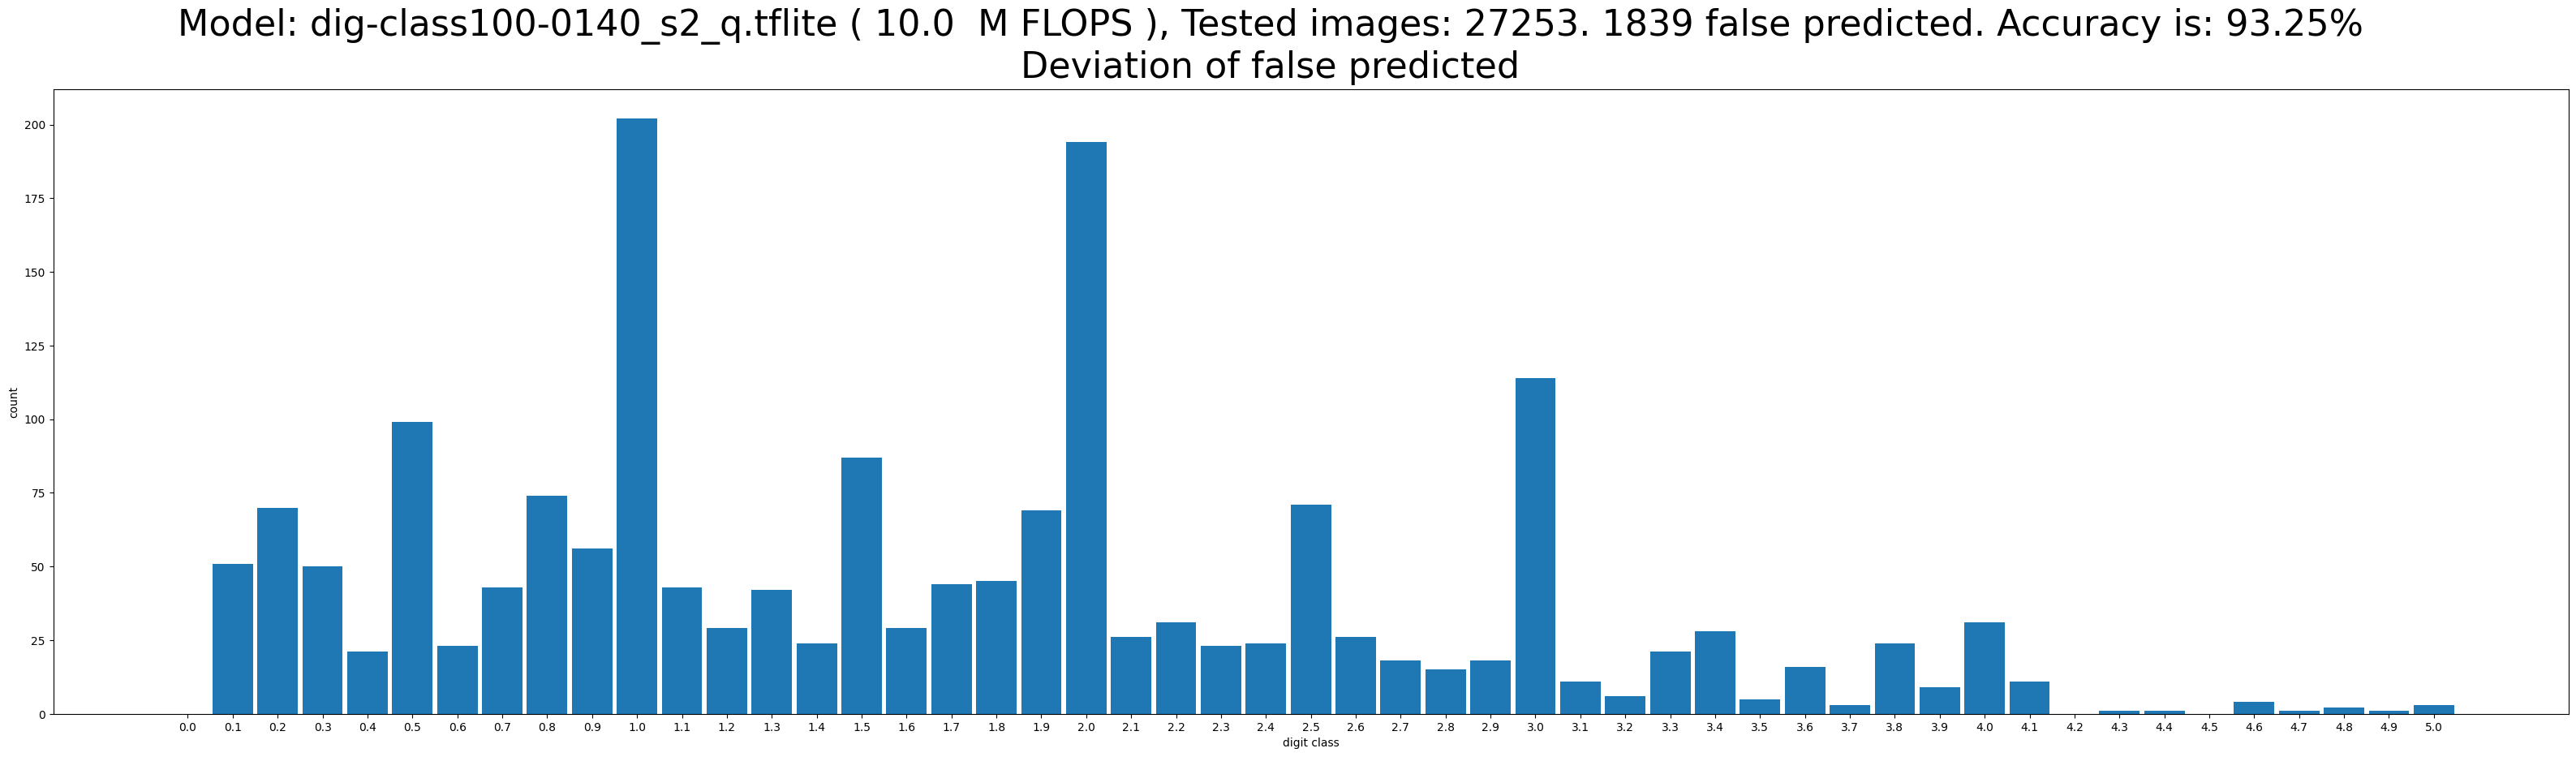

output/dig-class100-0140_s1_q.tflite
shape:[ 1 32 20  3] rgb


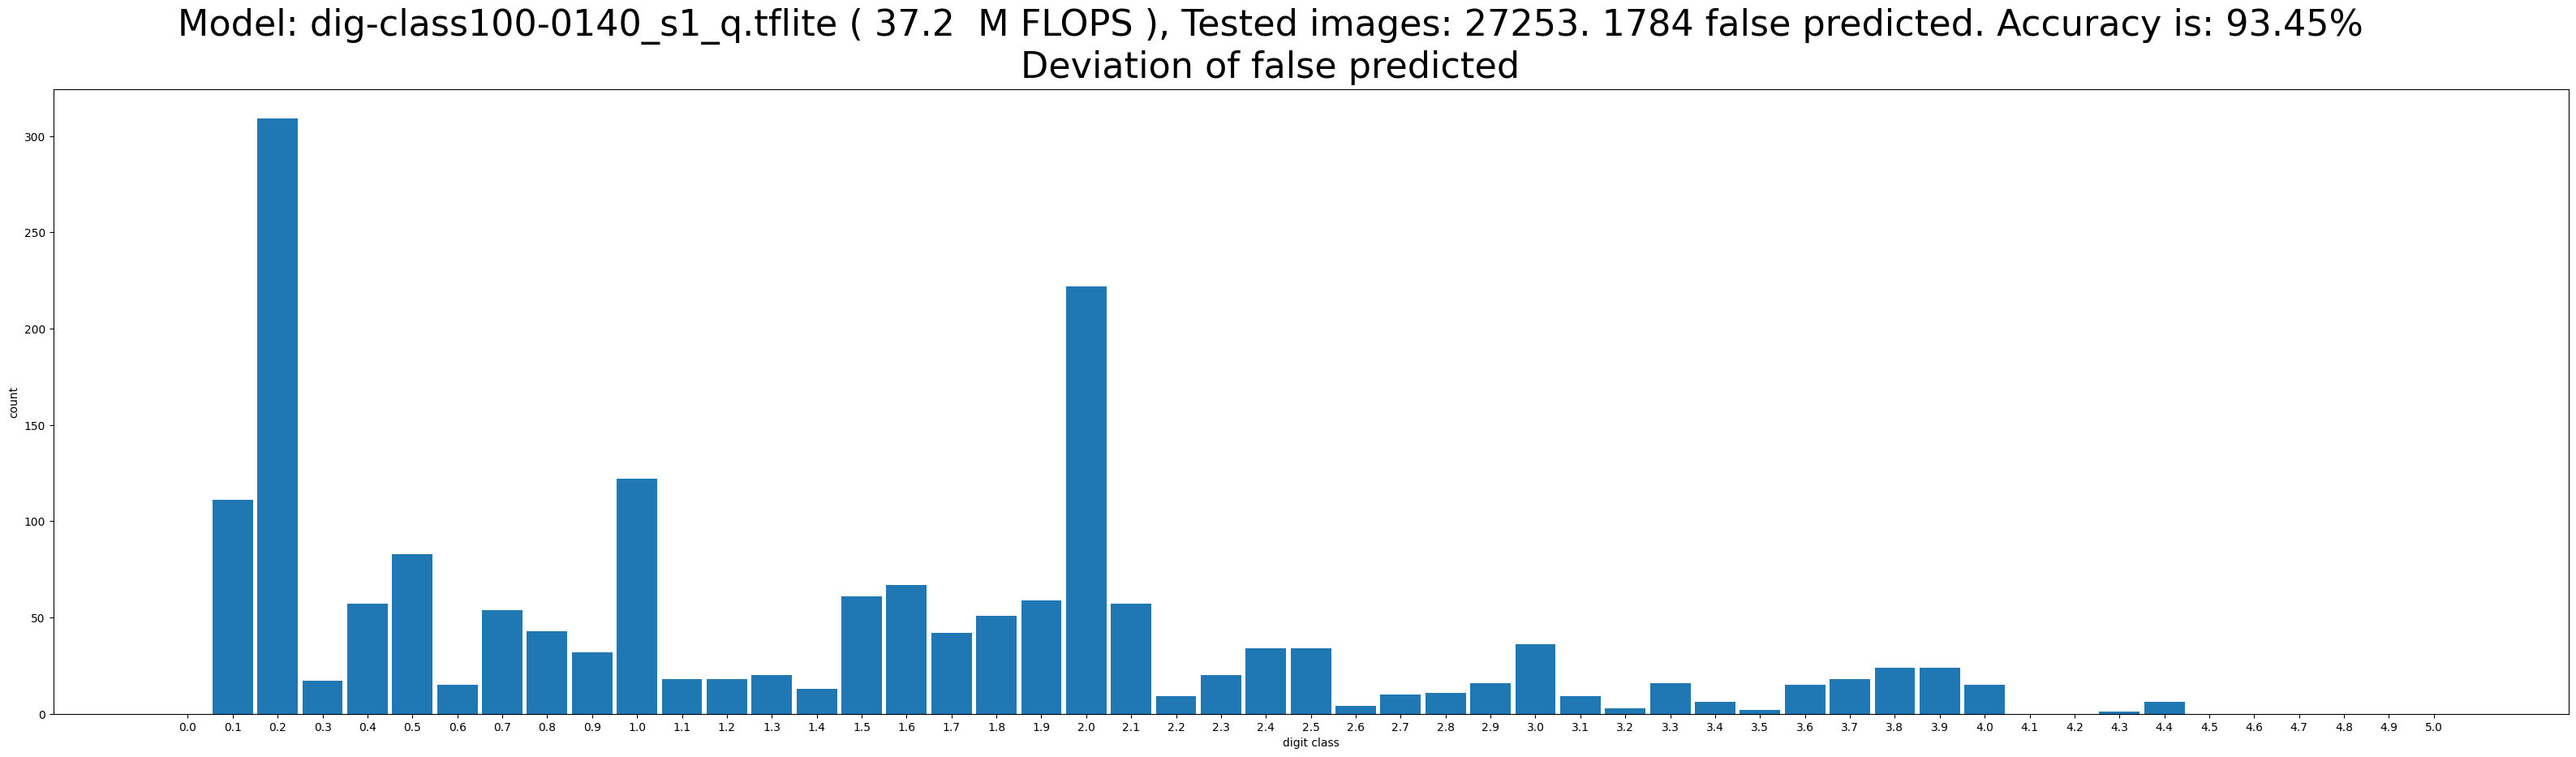

output/dig-class100-0130_s2_q.tflite
shape:[ 1 32 20  3] rgb


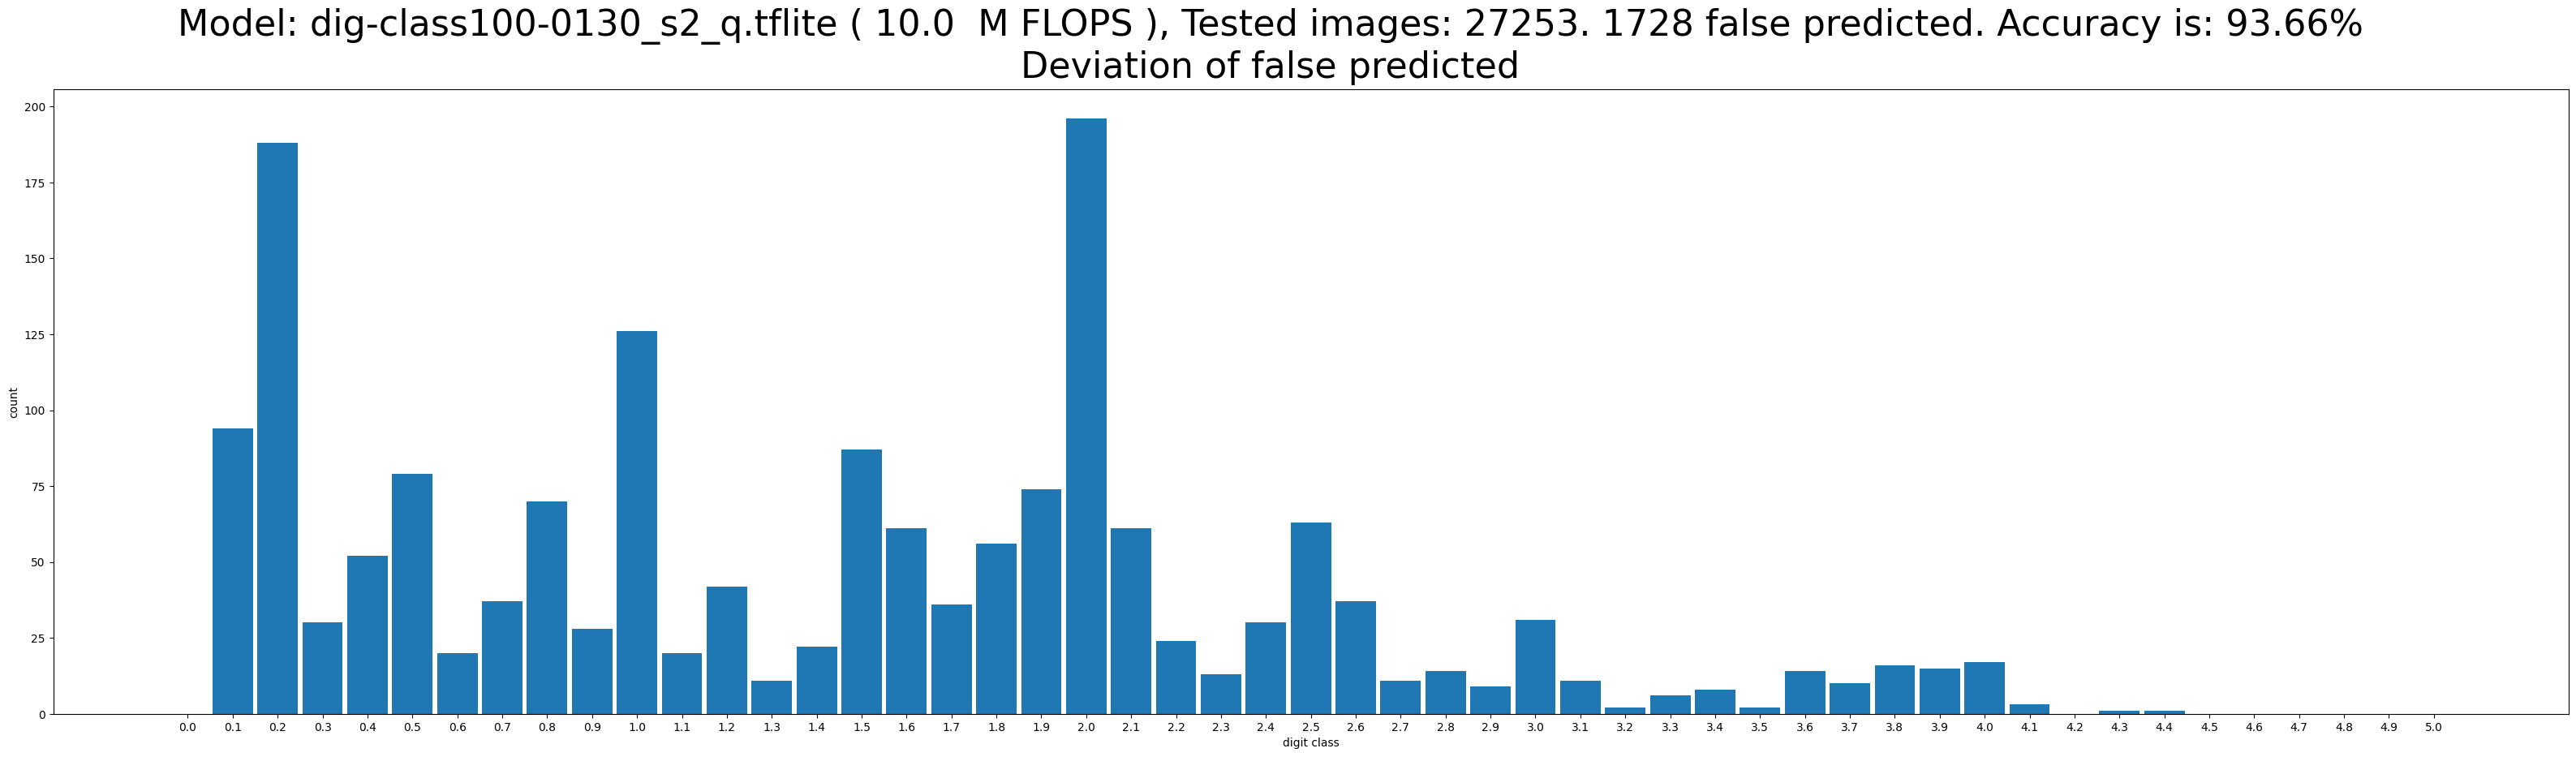

output/dig-class100-0120_s2_q.tflite
shape:[ 1 32 20  3] rgb


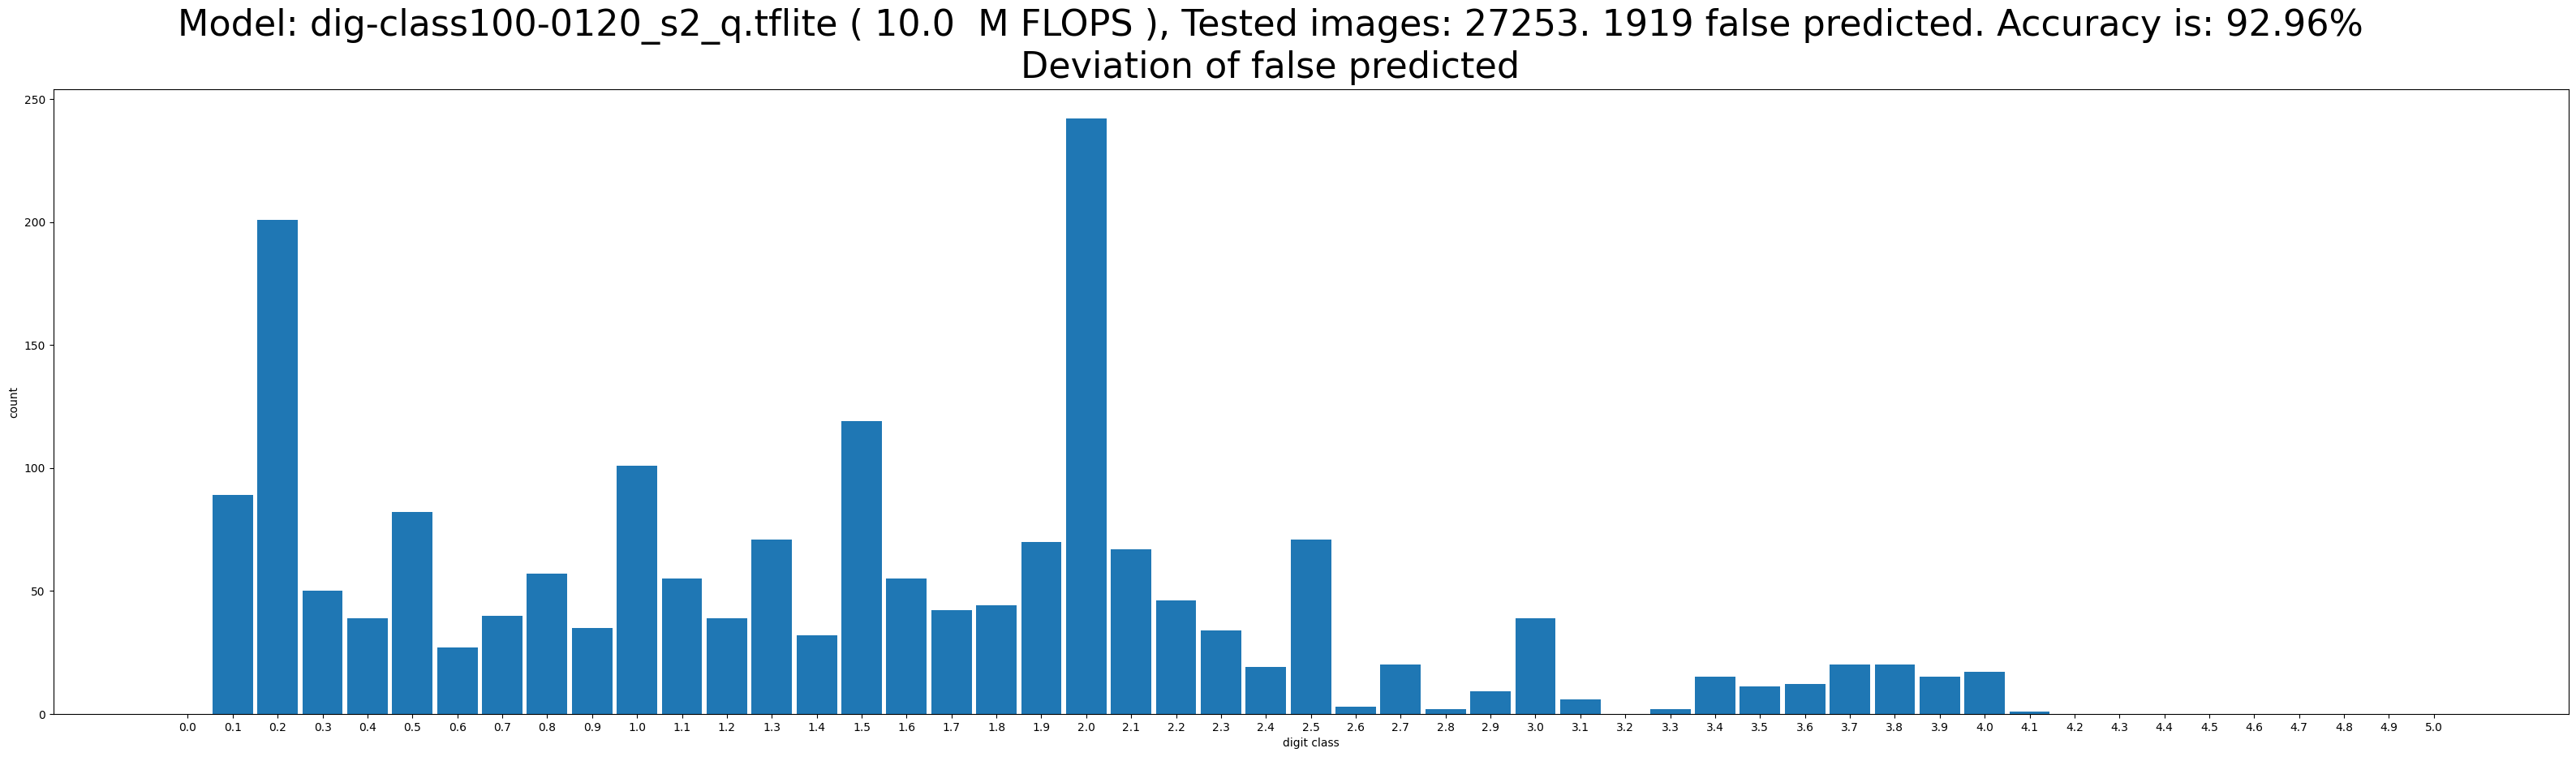

output/dig-class100-0101_s2_q.tflite
shape:[ 1 32 20  3] rgb


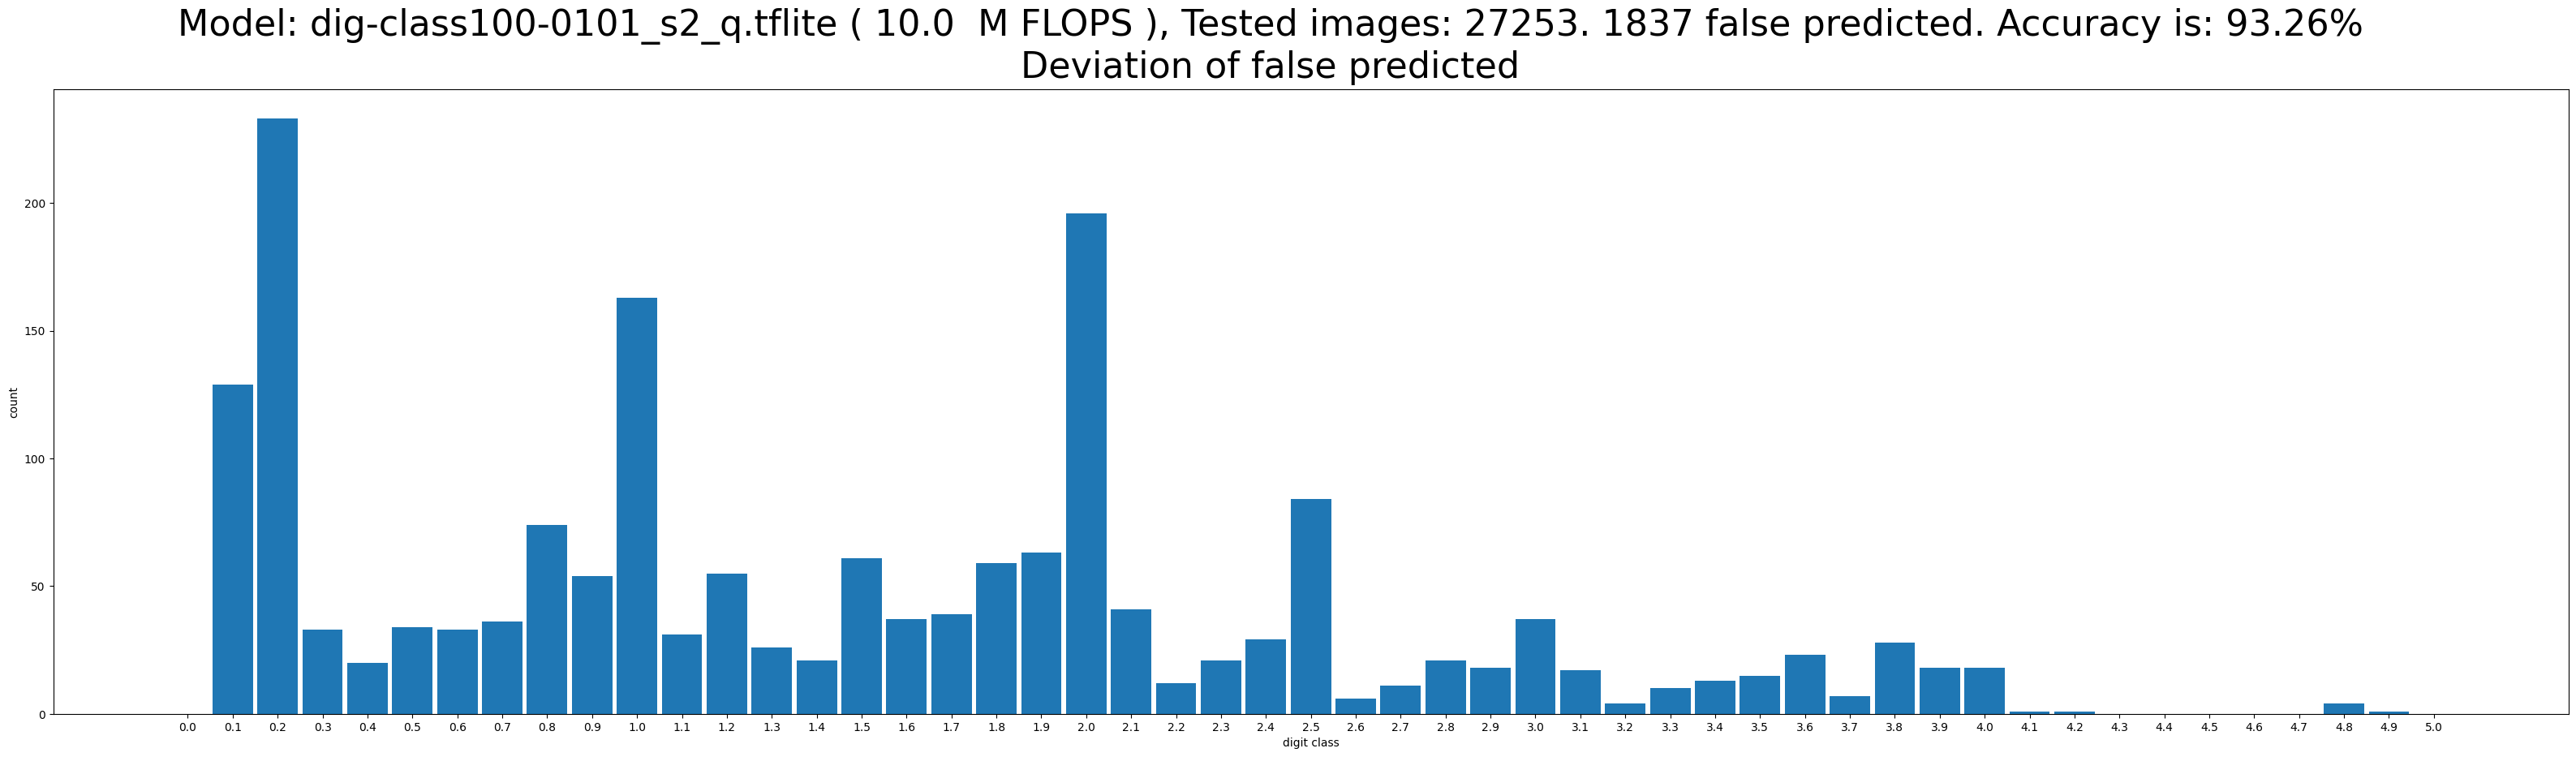

output/dig-class100-0100_s2_q.tflite
shape:[ 1 32 20  3] rgb


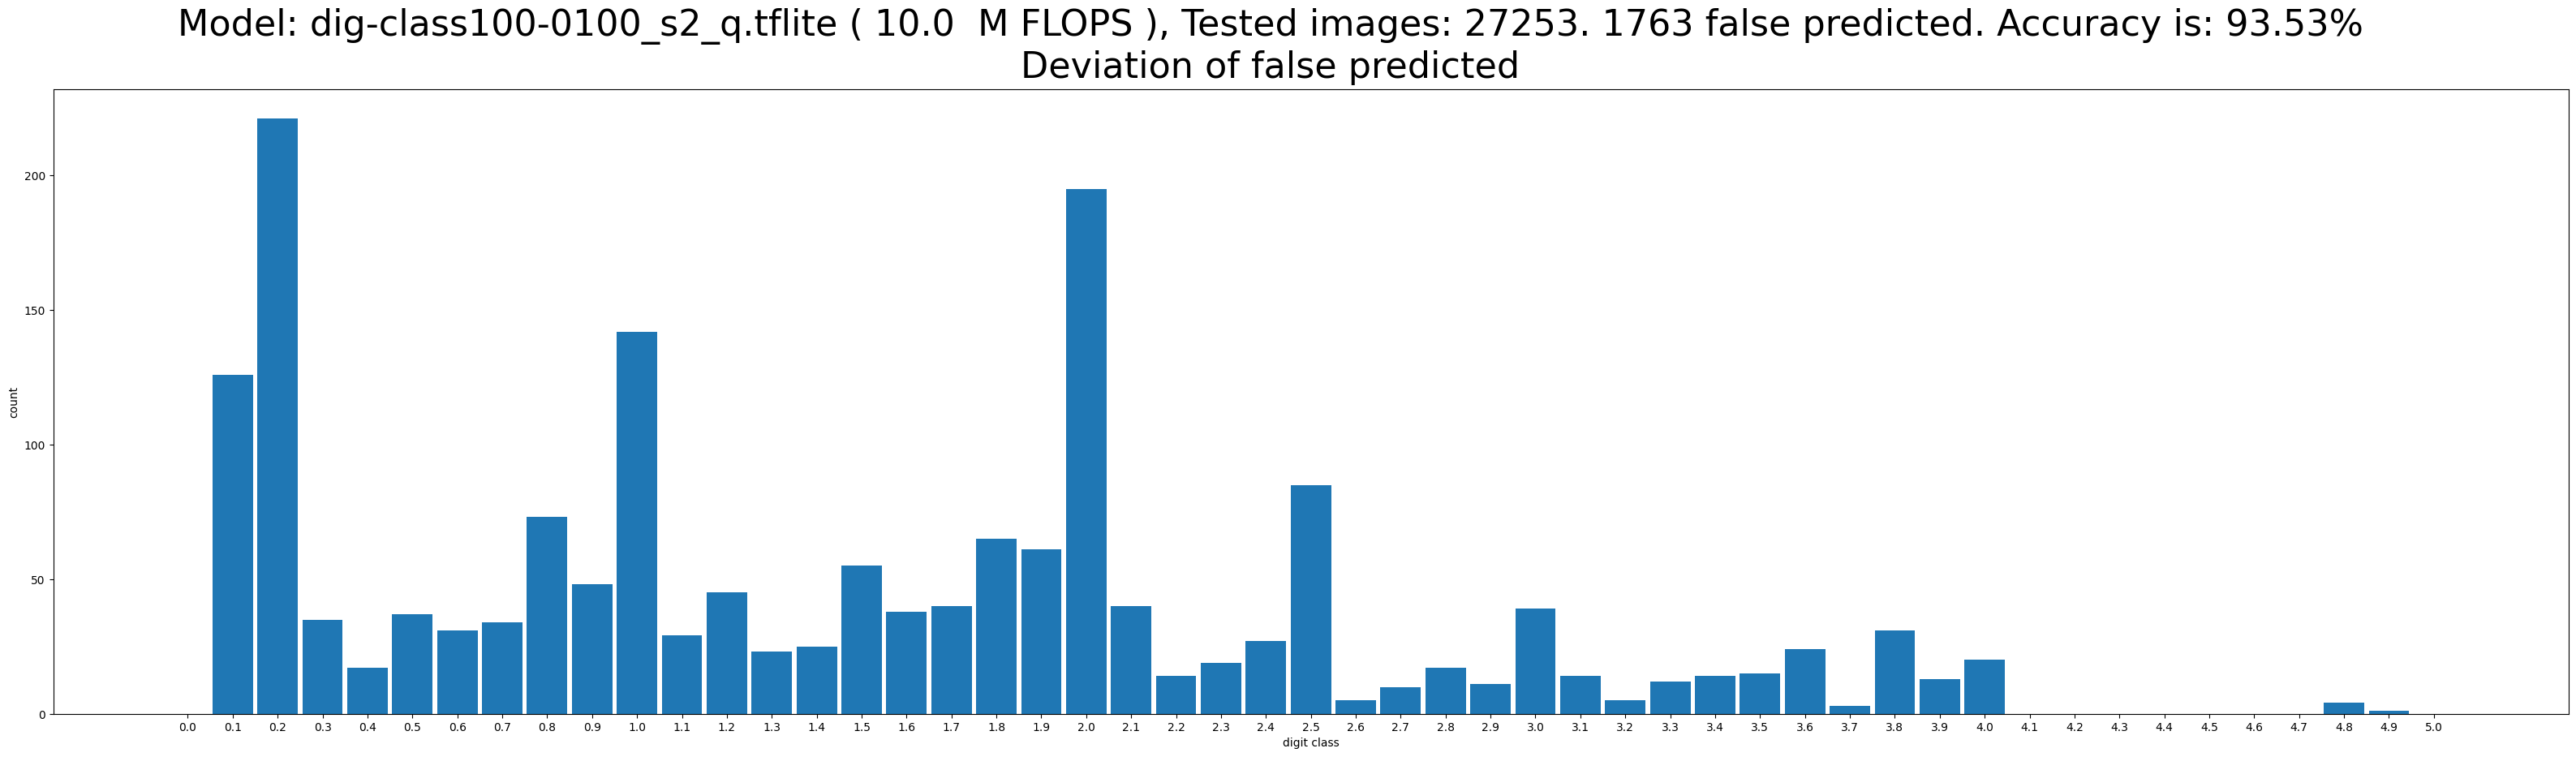

In [5]:
modelfiles = sorted(glob.glob('output/*.tflite'), reverse = True)
for modelfile in modelfiles:
    evaluate_ziffer_tflite(modelfile, x_data, x_data_gray, y_data, y_data10, f_data, title=modelfile, max_delta=0.11)

# Evaluate max_delta = 0

In [6]:
#modelfiles = sorted(glob.glob('output/*.tflite'), reverse= True)
#for modelfile in modelfiles:
#    evaluate_ziffer_tflite(modelfile, x_data, x_data_gray, y_data, y_data10, f_data, title=modelfile, max_delta=0.0)